In [1]:
# packages_to_have <- c('cowplot', 'reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'geomtextpath')

# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# packages = installed.packages()
# packages = packages[, "Package"]

# if (FALSE %in% (packages_to_have %in% packages)){
#     install.packages(packages_to_have)
# }

Sys.setenv(VROOM_TEMP_PATH = './vroom')
system("mkdir -p ./vroom")
system("rm ./vroom/*")

# To call python from R
library(archive)
library(dplyr)
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(geomtextpath)
library(cowplot)
library(scales)
library(vroom)
library(zoo)
library(ggdist)
library(gghighlight)
library(ggrepel)
library(ggbreak)
library(grid)
library(lemon)
library(ggprism)
library(ggh4x)
library(ggExtra)
library(tibbletime)
library(snakecase)
library(foreach)
library(doParallel)
library(ggside)
library(ggbeeswarm)

library(gifski)
library(gganimate)

library(intergraph)
library(network)
library(ggnetwork)

library(purrr)
library(future.apply)
future::plan("multicore", workers = 20L)

theme_set(theme_prism())



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.2     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The

In [2]:
fig <- function(width, heigth) {
  options(repr.plot.width = width, repr.plot.height = heigth)
}

[1] 5100

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'location', 'z', 'linear_slope', 'max_initial_price'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'x', 'location', 'ymin', 'ymax', 'linear_slope'. You can override using the `.groups` argument.


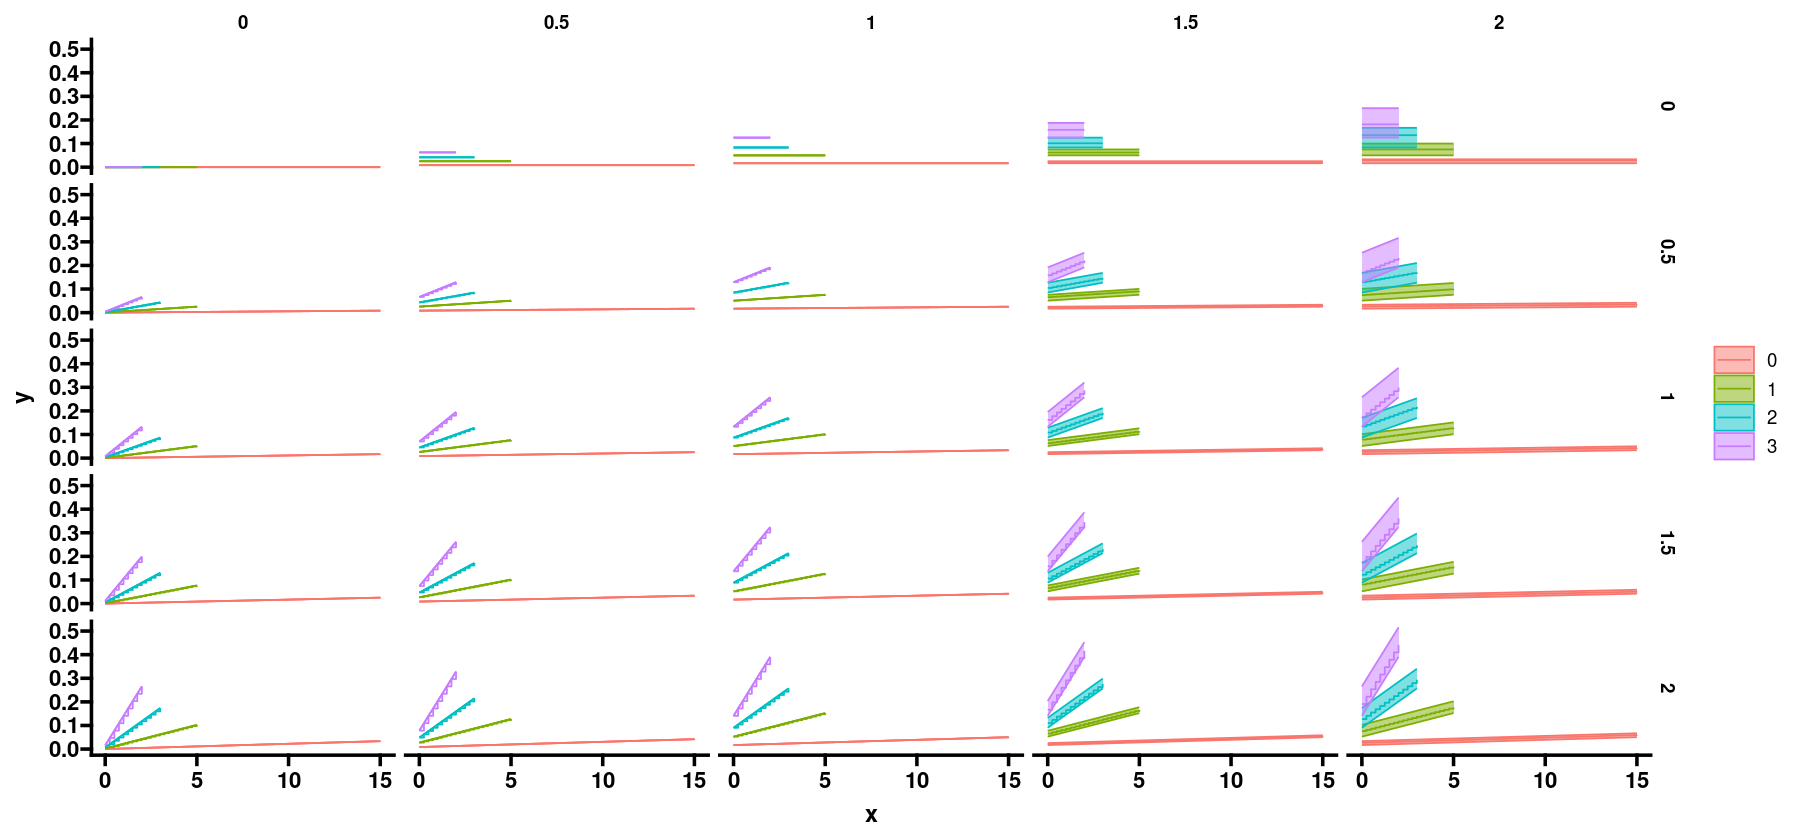

In [116]:
MAX_LOCATION <- 4
FUNCTION_SIZE <- 0.25

generate_init_price <- function(location, max_initial_price){
    location <- min(max(1, location), MAX_LOCATION)
    base_price <- max_initial_price - (max_initial_price * (location -1 ) / (MAX_LOCATION - 1))
    random_variation <- runif(1, -5, 5)
    price <- base_price + random_variation

    price <- min(max(1, price), max_initial_price)
    return(price)
}

price_function_linear <- function(initial_price, utilization, linear_slope){
    return(initial_price + linear_slope * utilization)
}


cost_linear <- function(used_capacity, initial_price, capacity, requirement, linear_slope){
       u1 <- used_capacity / capacity
       u2 <- (used_capacity+requirement) / capacity       
       integral <- (u2-u1)*(linear_slope * u2 + linear_slope * u1 + 2*initial_price ) / 2
       return(integral)
}

df <- NULL
    for (ii in seq(0, 2, by = 0.5)){
        for (jj in seq(0, 2, by = 0.5)){
for (zz in 0:50){
            df <- rbind(df,  data.frame(
            location = c(0,1,2,3),
            capacity = c(15, 5, 3, 2),
            requirement = c(FUNCTION_SIZE, FUNCTION_SIZE, FUNCTION_SIZE, FUNCTION_SIZE)
            ) %>%
            mutate(z =zz, linear_slope = ii, max_initial_price= jj))
        }
    }
}
nrow(df)

df <- df %>%
    rowwise() %>%
    mutate(initial_price = generate_init_price(location, max_initial_price ))
df.func <- df %>%
    group_by(location, z, linear_slope, max_initial_price) %>%
    summarize(
        x = seq(0, capacity, by = c(FUNCTION_SIZE)),
        y = cost_linear(x, initial_price, capacity, requirement, linear_slope)
    ) %>%
    group_by(x, location, linear_slope, max_initial_price) %>%
    mutate(ymin = min(y), ymax = max(y)) %>%
    group_by(x, location, ymin, ymax, linear_slope, max_initial_price) %>%
    summarise(y = mean(y)) %>%
    mutate(location = as.factor(location))
fig(15, 7)
ggplot(df.func, aes(x = x, y = y, ymin = ymin, ymax = ymax,  group = location, color = location, fill = location))+ 
   facet_grid(rows = vars(linear_slope), cols = vars(max_initial_price)) +
  geom_step() +
   geom_ribbon(alpha=0.5)

#   geom_point(data = df.points)

[1] 5100

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust
  accordingly.”
`summarise()` has grouped output by 'location', 'z', 'linear_slope', 'max_initial_price'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'x', 'location', 'ymin', 'ymax', 'linear_slope'. You can override using the `.groups` argument.


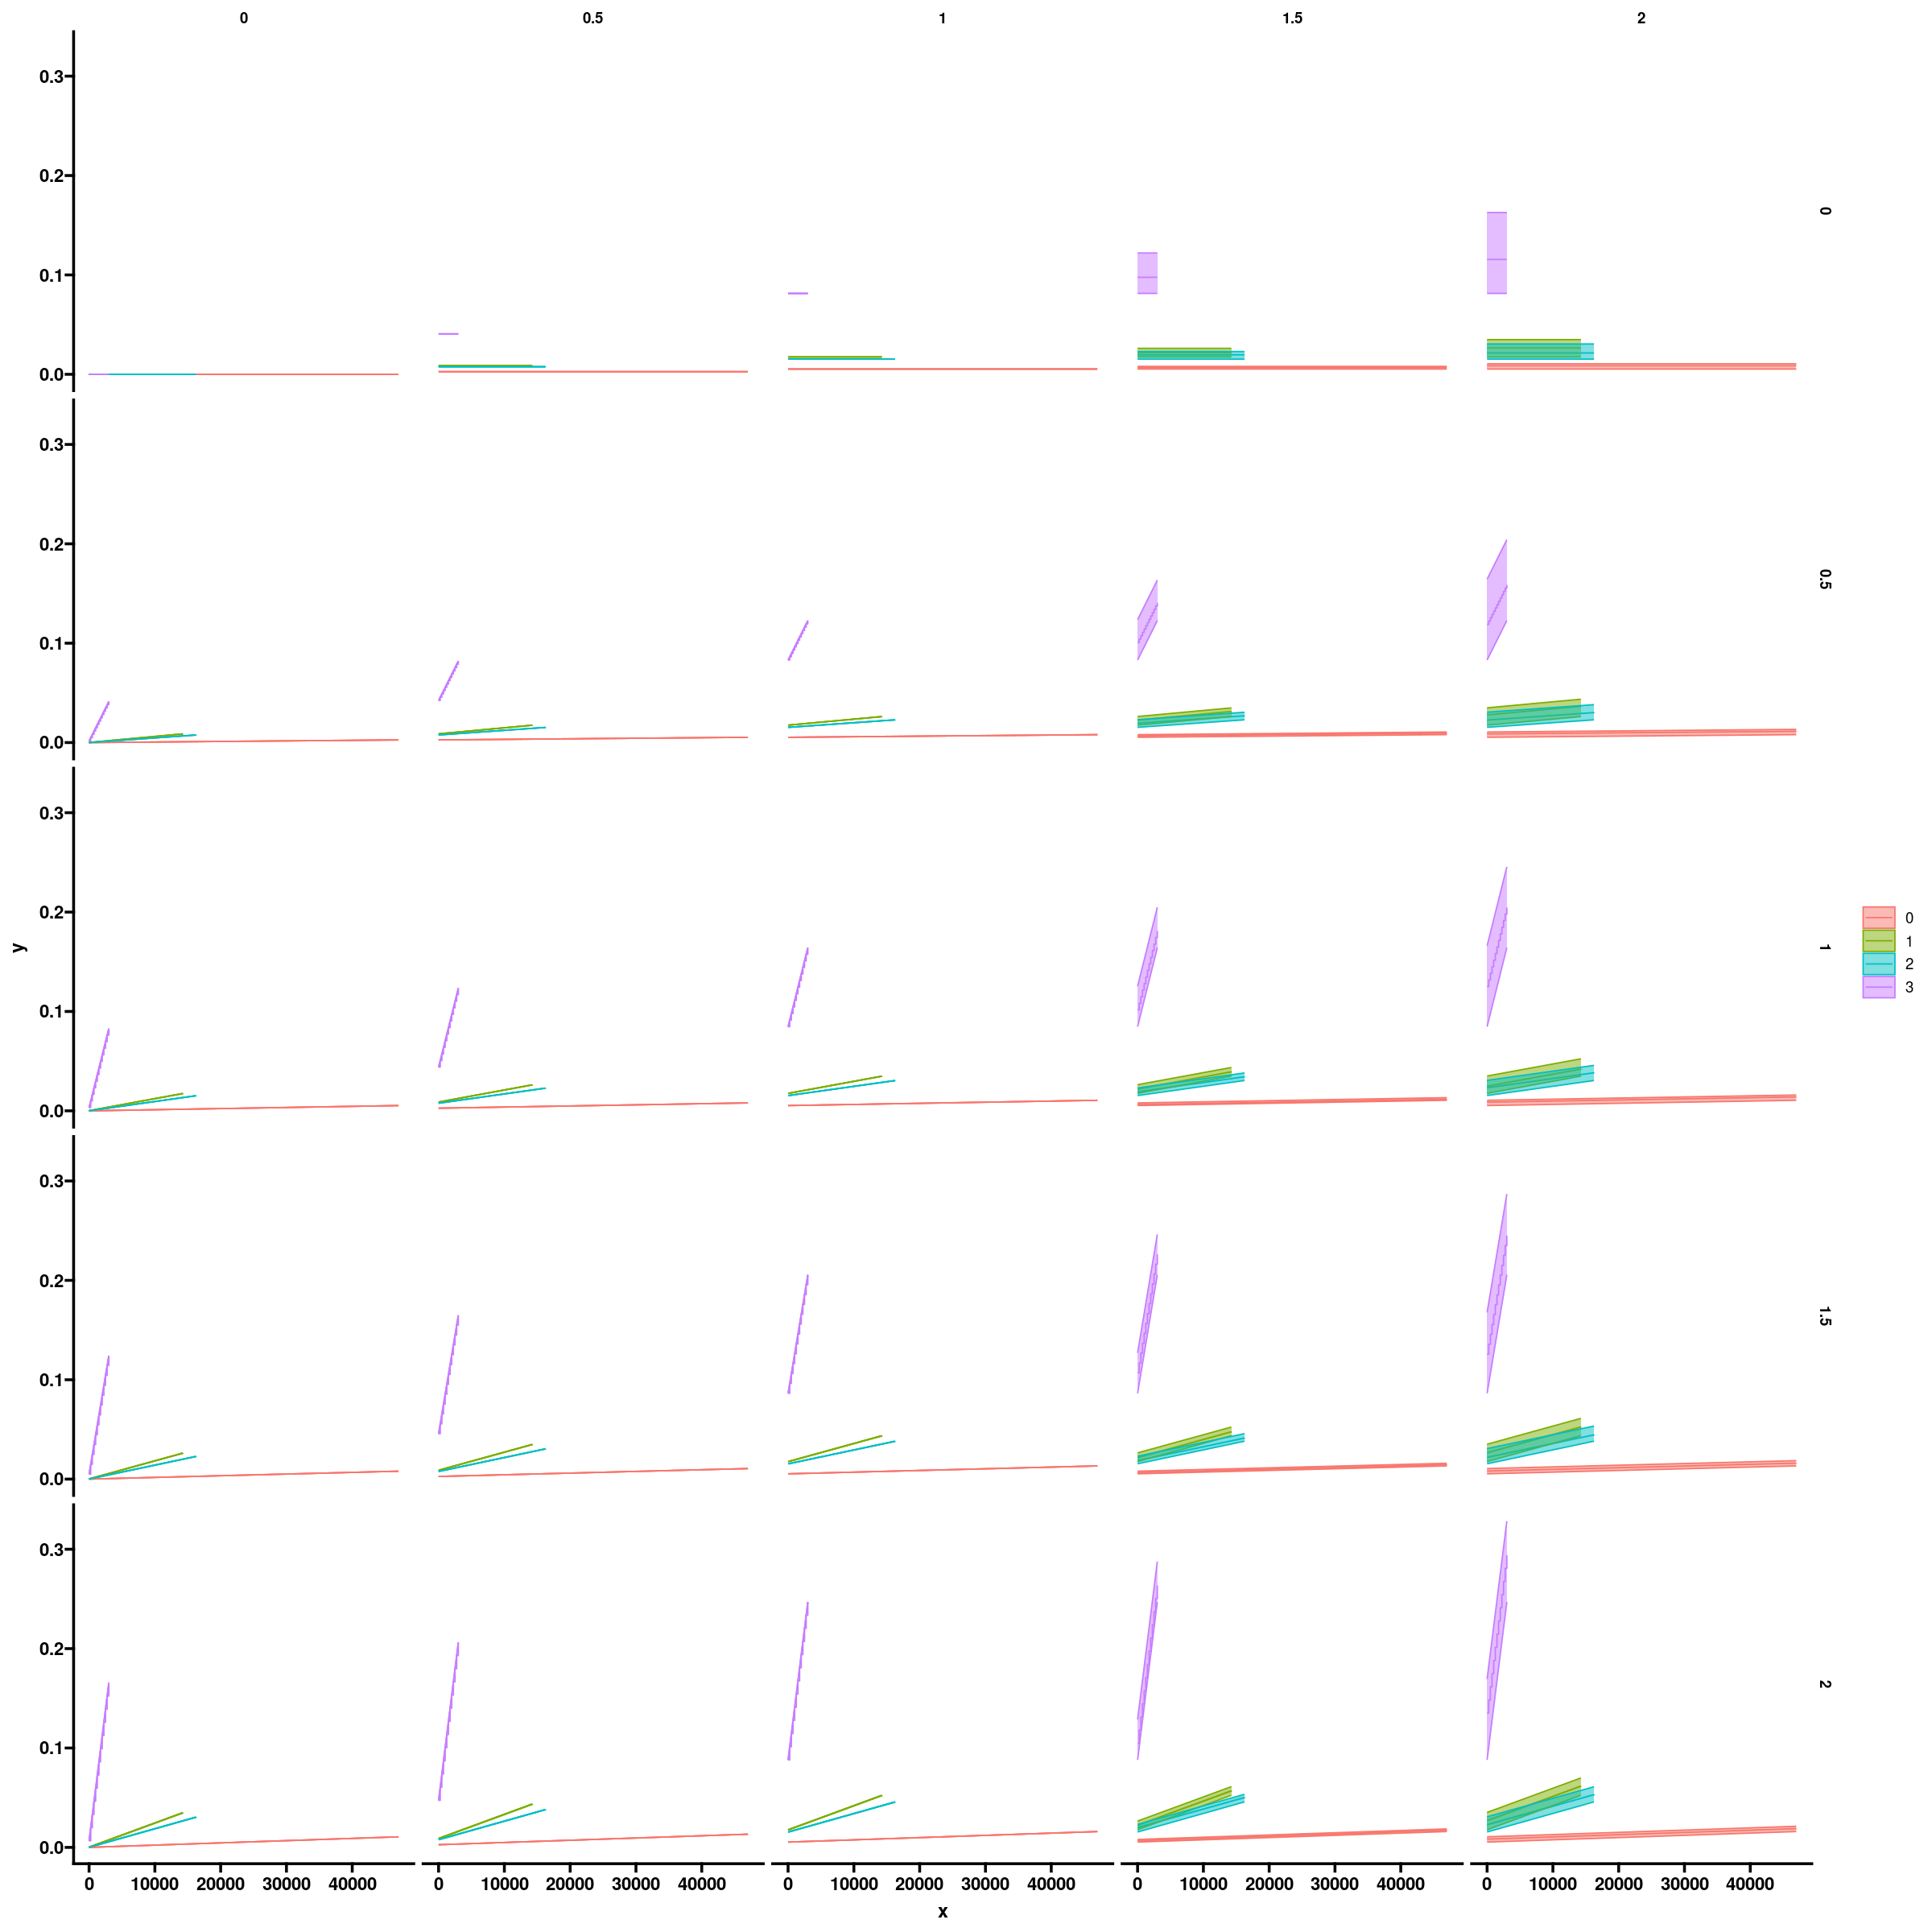

In [4]:
MAX_LOCATION <- 4
FUNCTION_SIZE <- 250

generate_init_price <- function(location, max_initial_price){
    location <- min(max(1, location), MAX_LOCATION)
    base_price <- max_initial_price - (max_initial_price * (location -1 ) / (MAX_LOCATION - 1))
    random_variation <- runif(1, -5, 5)
    price <- base_price + random_variation

    price <- min(max(1, price), max_initial_price)
    return(price)
}

price_function_linear <- function(initial_price, utilization, linear_slope){
    return(initial_price + linear_slope * utilization)
}


cost_linear <- function(used_capacity, initial_price, capacity, requirement, linear_slope){
       u1 <- used_capacity / capacity
       u2 <- (used_capacity+requirement) / capacity       
       integral <- (u2-u1)*(linear_slope * u2 + linear_slope * u1 + 2*initial_price ) / 2
       return(integral)
}

df <- NULL
    for (ii in seq(0, 2, by = 0.5)){
        for (jj in seq(0, 2, by = 0.5)){
for (zz in 0:50){
            df <- rbind(df,  data.frame(
            location = c(0,1,2,3),
            capacity = c(1024*46, 1024*14, 1024*16, 1024*3),
            requirement = c(FUNCTION_SIZE, FUNCTION_SIZE, FUNCTION_SIZE, FUNCTION_SIZE)
            ) %>%
            mutate(z =zz, linear_slope = ii, max_initial_price= jj))
        }
    }
}
nrow(df)

df <- df %>%
    rowwise() %>%
    mutate(initial_price = generate_init_price(location, max_initial_price ))
df.func <- df %>%
    group_by(location, z, linear_slope, max_initial_price) %>%
    summarize(
        x = seq(0, capacity, by = c(FUNCTION_SIZE)),
        y = cost_linear(x, initial_price, capacity, requirement, linear_slope)
    ) %>%
    group_by(x, location, linear_slope, max_initial_price) %>%
    mutate(ymin = min(y), ymax = max(y)) %>%
    group_by(x, location, ymin, ymax, linear_slope, max_initial_price) %>%
    summarise(y = mean(y)) %>%
    mutate(location = as.factor(location))
fig(20, 20)
ggplot(df.func, aes(x = x, y = y, ymin = ymin, ymax = ymax,  group = location, color = location, fill = location))+ 
   facet_grid(rows = vars(linear_slope), cols = vars(max_initial_price)) +
  geom_step() +
   geom_ribbon(alpha=0.5)

#   geom_point(data = df.points)

# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [5]:
generate_gif <- FALSE
reload_big_data <- TRUE
parallel_loading_datasets <- 2
parallel_loading_datasets_small <- 22

METRICS_PATH <- "metrics-arks"
METRICS_ARKS_BIGGER <- c(
# "metrics_paper_bigger_11-edge_first_v2_valuation_rates_no-telemetry_2023-07-09-14-53.tar.xz",
# "metrics_paper_bigger_12-auction_valuation_rates_no-telemetry_2023-07-09-12-03.tar.xz",
# "metrics_paper_bigger_12-edge_first_v2_valuation_rates_no-telemetry_2023-07-09-14-36.tar.xz",
# "metrics_paper_bigger_12-edge_ward_valuation_rates_no-telemetry_2023-07-09-13-15.tar.xz",
# "metrics_paper_bigger_14-auction_valuation_rates_no-telemetry_2023-07-09-13-48.tar.xz",
# "metrics_paper_bigger_14-edge_first_v2_valuation_rates_no-telemetry_2023-07-09-11-14.tar.xz",
# "metrics_paper_bigger_14-edge_ward_valuation_rates_no-telemetry_2023-07-09-12-24.tar.xz",
# "metrics_paper_bigger_15-edge_first_v2_valuation_rates_no-telemetry_2023-07-09-13-07.tar.xz",
# "metrics_paper_bigger_16-edge_first_v2_valuation_rates_no-telemetry_2023-07-09-10-01.tar.xz",
# "metrics_paper_bigger_2-auction_valuation_rates_no-telemetry_2023-07-09-14-45.tar.xz",
# "metrics_paper_bigger_3-auction_valuation_rates_no-telemetry_2023-07-09-15-04.tar.xz",
# "metrics_paper_bigger_3-edge_ward_valuation_rates_no-telemetry_2023-07-09-16-20.tar.xz",
# "metrics_paper_bigger_5-auction_valuation_rates_no-telemetry_2023-07-09-15-54.tar.xz",
# "metrics_paper_bigger_5-edge_first_v2_valuation_rates_no-telemetry_2023-07-09-18-20.tar.xz",
# "metrics_paper_bigger_5-edge_ward_valuation_rates_no-telemetry_2023-07-09-17-11.tar.xz",
# "metrics_paper_bigger_6-edge_ward_valuation_rates_no-telemetry_2023-07-09-10-08.tar.xz",
# "metrics_paper_bigger_7-auction_valuation_rates_no-telemetry_2023-07-09-10-01.tar.xz",
# "metrics_paper_bigger_7-edge_ward_valuation_rates_no-telemetry_2023-07-09-11-35.tar.xz",
# "metrics_paper_bigger_8-auction_valuation_rates_no-telemetry_2023-07-09-10-01.tar.xz",
# "metrics_paper_bigger_8-edge_first_v2_valuation_rates_no-telemetry_2023-07-09-11-34.tar.xz",
# "metrics_paper_bigger_9-auction_valuation_rates_no-telemetry_2023-07-09-16-08.tar.xz",
# "metrics_paper_bigger_9-edge_ward_valuation_rates_no-telemetry_2023-07-09-18-06.tar.xz",

#---
#---
#---
"last element that is here because last element should not have any comma in the end and that sucks bollocks hard time."
)
METRICS_ARKS_BIGGER <- METRICS_ARKS_BIGGER[-length(METRICS_ARKS_BIGGER)]
METRICS_GROUP_GROUP <- rep(list("bigger"), length(METRICS_ARKS_BIGGER))

METRICS_ARKS_SMALL <-c(
# "metrics_equal_linear_pricing.env.scenario_1-auction_valuation_rates_no-telemetry_2023-07-31-15-03.tar.xz",
# "metrics_equal_linear_pricing.env.scenario_1-edge_first_valuation_rates_no-telemetry_2023-07-31-15-16.tar.xz",
# "metrics_equal_linear_pricing.env.scenario_1-edge_ward_valuation_rates_no-telemetry_2023-07-31-14-51.tar.xz",
"metrics_equal_linear_pricing_big2.env.scenario_1-edge_first_valuation_rates_no-telemetry_2023-07-31-20-07.tar.xz",
"metrics_equal_linear_pricing_big2.env.scenario_1-edge_ward_valuation_rates_no-telemetry_2023-07-31-17-57.tar.xz",
"metrics_equal_linear_pricing_big2.env.scenario_2-auction_valuation_rates_no-telemetry_2023-08-01-00-00.tar.xz",
"metrics_equal_linear_pricing_big2.env.scenario_2-edge_first_valuation_rates_no-telemetry_2023-08-01-01-53.tar.xz",
"metrics_equal_linear_pricing_big2.env.scenario_2-edge_ward_valuation_rates_no-telemetry_2023-08-01-03-56.tar.xz",
"metrics_equal_linear_pricing_big2.env.scenario_3-auction_valuation_rates_no-telemetry_2023-07-31-19-57.tar.xz",
"metrics_equal_linear_pricing_big2.env.scenario_3-edge_first_valuation_rates_no-telemetry_2023-07-31-17-46.tar.xz",
# ---
# "metrics_linear_more_less_ll_1-auction_valuation_rates_no-telemetry_2023-07-22-20-59.tar.xz",
# "metrics_linear_more_less_ll_1-edge_first_valuation_rates_no-telemetry_2023-07-22-19-39.tar.xz",
# "metrics_linear_more_less_ll_1-edge_ward_valuation_rates_no-telemetry_2023-07-22-18-21.tar.xz",
# "metrics_linear_more_less_ll_2-auction_valuation_rates_no-telemetry_2023-07-22-20-58.tar.xz",
# "metrics_linear_more_less_ll_2-edge_first_valuation_rates_no-telemetry_2023-07-22-18-23.tar.xz",
# "metrics_linear_more_less_ll_2-edge_ward_valuation_rates_no-telemetry_2023-07-22-19-42.tar.xz",
# "metrics_linear_more_less_ll_3-auction_valuation_rates_no-telemetry_2023-07-22-21-01.tar.xz",
# "metrics_linear_more_less_ll_3-edge_first_valuation_rates_no-telemetry_2023-07-22-18-16.tar.xz",
# "metrics_linear_more_less_ll_3-edge_ward_valuation_rates_no-telemetry_2023-07-22-19-51.tar.xz",
# "metrics_linear_more_more_less_ll_1-auction_valuation_rates_no-telemetry_2023-07-22-23-44.tar.xz",
# "metrics_linear_more_more_less_ll_1-edge_first_valuation_rates_no-telemetry_2023-07-22-22-25.tar.xz",
# "metrics_linear_more_more_less_ll_1-edge_ward_valuation_rates_no-telemetry_2023-07-23-01-07.tar.xz",
# "metrics_linear_more_more_less_ll_2-auction_valuation_rates_no-telemetry_2023-07-22-22-28.tar.xz",
# "metrics_linear_more_more_less_ll_2-edge_first_valuation_rates_no-telemetry_2023-07-22-23-49.tar.xz",
# "metrics_linear_more_more_less_ll_2-edge_ward_valuation_rates_no-telemetry_2023-07-23-01-11.tar.xz",
# "metrics_linear_more_more_less_ll_3-auction_valuation_rates_no-telemetry_2023-07-22-23-25.tar.xz",
# "metrics_linear_more_more_less_ll_3-edge_first_valuation_rates_no-telemetry_2023-07-23-00-33.tar.xz",
# "metrics_linear_more_more_less_ll_3-edge_ward_valuation_rates_no-telemetry_2023-07-22-22-12.tar.xz",
# "metrics_linear_more_more_ll_1-auction_valuation_rates_no-telemetry_2023-07-22-18-14.tar.xz",
# "metrics_linear_more_more_ll_1-edge_first_valuation_rates_no-telemetry_2023-07-22-19-37.tar.xz",
# "metrics_linear_more_more_ll_1-edge_ward_valuation_rates_no-telemetry_2023-07-22-20-56.tar.xz",
# "metrics_linear_more_more_ll_2-auction_valuation_rates_no-telemetry_2023-07-22-19-33.tar.xz",
# "metrics_linear_more_more_ll_2-edge_first_valuation_rates_no-telemetry_2023-07-22-20-53.tar.xz",
# "metrics_linear_more_more_ll_2-edge_ward_valuation_rates_no-telemetry_2023-07-22-18-14.tar.xz",
# "metrics_linear_more_more_ll_3-auction_valuation_rates_no-telemetry_2023-07-22-19-32.tar.xz",
# "metrics_linear_more_more_ll_3-edge_first_valuation_rates_no-telemetry_2023-07-22-20-50.tar.xz",
# "metrics_linear_more_more_ll_3-edge_ward_valuation_rates_no-telemetry_2023-07-22-18-14.tar.xz",
# "metrics_linear_more_more_more_ll_1-auction_valuation_rates_no-telemetry_2023-07-22-23-47.tar.xz",
# "metrics_linear_more_more_more_ll_1-edge_first_valuation_rates_no-telemetry_2023-07-23-01-06.tar.xz",
# "metrics_linear_more_more_more_ll_1-edge_ward_valuation_rates_no-telemetry_2023-07-22-22-30.tar.xz",
# "metrics_linear_more_more_more_ll_2-auction_valuation_rates_no-telemetry_2023-07-23-01-11.tar.xz",
# "metrics_linear_more_more_more_ll_2-edge_first_valuation_rates_no-telemetry_2023-07-22-22-42.tar.xz",
# "metrics_linear_more_more_more_ll_2-edge_ward_valuation_rates_no-telemetry_2023-07-22-23-56.tar.xz",
# "metrics_linear_more_more_more_ll_3-auction_valuation_rates_no-telemetry_2023-07-22-22-32.tar.xz",
# "metrics_linear_more_more_more_ll_3-edge_first_valuation_rates_no-telemetry_2023-07-22-23-53.tar.xz",
# "metrics_linear_more_more_more_ll_3-edge_ward_valuation_rates_no-telemetry_2023-07-23-01-11.tar.xz",
# "metrics_linear_pricing_initial_1-auction_valuation_rates_no-telemetry_2023-07-21-21-23.tar.xz",
# "metrics_linear_pricing_initial_1-edge_first_valuation_rates_no-telemetry_2023-07-21-22-22.tar.xz",
# "metrics_linear_pricing_initial_1-edge_ward_valuation_rates_no-telemetry_2023-07-21-23-24.tar.xz",
# "metrics_linear_pricing_initial2_1-auction_valuation_rates_no-telemetry_2023-07-21-22-44.tar.xz",
# "metrics_linear_pricing_initial2_1-edge_first_valuation_rates_no-telemetry_2023-07-21-23-48.tar.xz",
# "metrics_linear_pricing_initial2_1-edge_ward_valuation_rates_no-telemetry_2023-07-21-21-38.tar.xz",
# "metrics_linear_pricing_initial2_2-auction_valuation_rates_no-telemetry_2023-07-21-21-39.tar.xz",
# "metrics_linear_pricing_initial2_2-edge_first_valuation_rates_no-telemetry_2023-07-21-22-42.tar.xz",
# "metrics_linear_pricing_initial2_2-edge_ward_valuation_rates_no-telemetry_2023-07-22-00-01.tar.xz",
# "metrics_linear_pricing_initial_less_ll_1-auction_valuation_rates_no-telemetry_2023-07-23-02-33.tar.xz",
# "metrics_linear_pricing_initial_less_ll_1-edge_first_valuation_rates_no-telemetry_2023-07-23-03-33.tar.xz",
# "metrics_linear_pricing_initial_less_ll_1-edge_ward_valuation_rates_no-telemetry_2023-07-23-04-36.tar.xz",
# "metrics_linear_pricing_initial_less_ll_2-auction_valuation_rates_no-telemetry_2023-07-23-04-43.tar.xz",
# "metrics_linear_pricing_initial_less_ll_2-edge_ward_valuation_rates_no-telemetry_2023-07-23-02-38.tar.xz",
# "metrics_linear_pricing_initial_less_ll_3-auction_valuation_rates_no-telemetry_2023-07-23-03-40.tar.xz",
# "metrics_linear_pricing_initial_less_ll_3-edge_first_valuation_rates_no-telemetry_2023-07-23-02-36.tar.xz",
# "metrics_linear_pricing_initial_less_ll_3-edge_ward_valuation_rates_no-telemetry_2023-07-23-04-40.tar.xz",
# "metrics_linear_pricing_initial_more_functions_1-auction_valuation_rates_no-telemetry_2023-07-22-09-36.tar.xz",
# "metrics_linear_pricing_initial_more_functions_1-edge_first_valuation_rates_no-telemetry_2023-07-22-12-01.tar.xz",
# "metrics_linear_pricing_initial_more_functions_1-edge_ward_valuation_rates_no-telemetry_2023-07-22-10-48.tar.xz",
# "metrics_linear_pricing_initial_more_functions_2-auction_valuation_rates_no-telemetry_2023-07-22-12-00.tar.xz",
# "metrics_linear_pricing_initial_more_functions_2-edge_first_valuation_rates_no-telemetry_2023-07-22-10-45.tar.xz",
# "metrics_linear_pricing_initial_more_functions_2-edge_ward_valuation_rates_no-telemetry_2023-07-22-09-35.tar.xz",
# "metrics_linear_pricing_initial_more_functions_3-auction_valuation_rates_no-telemetry_2023-07-22-10-46.tar.xz",
# "metrics_linear_pricing_initial_more_functions_3-edge_first_valuation_rates_no-telemetry_2023-07-22-12-01.tar.xz",
# "metrics_linear_pricing_initial_more_functions_3-edge_ward_valuation_rates_no-telemetry_2023-07-22-09-36.tar.xz",
# "metrics_linear_pricing_initial_more_more_functions_1-auction_valuation_rates_no-telemetry_2023-07-22-16-48.tar.xz",
# "metrics_linear_pricing_initial_more_more_functions_1-edge_first_valuation_rates_no-telemetry_2023-07-22-14-14.tar.xz",
# "metrics_linear_pricing_initial_more_more_functions_1-edge_ward_valuation_rates_no-telemetry_2023-07-22-15-35.tar.xz",
# "metrics_linear_pricing_initial_more_more_functions_2-auction_valuation_rates_no-telemetry_2023-07-22-15-33.tar.xz",
# "metrics_linear_pricing_initial_more_more_functions_2-edge_first_valuation_rates_no-telemetry_2023-07-22-16-50.tar.xz",
# "metrics_linear_pricing_initial_more_more_functions_2-edge_ward_valuation_rates_no-telemetry_2023-07-22-14-14.tar.xz",
# "metrics_linear_pricing_initial_more_more_functions_3-auction_valuation_rates_no-telemetry_2023-07-22-16-56.tar.xz",
# "metrics_linear_pricing_initial_more_more_functions_3-edge_first_valuation_rates_no-telemetry_2023-07-22-14-14.tar.xz",
# "metrics_linear_pricing_initial_more_more_functions_3-edge_ward_valuation_rates_no-telemetry_2023-07-22-15-48.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll2_1-auction_valuation_rates_no-telemetry_2023-07-25-22-51.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll2_1-edge_first_valuation_rates_no-telemetry_2023-07-26-00-03.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll2_1-edge_ward_valuation_rates_no-telemetry_2023-07-25-21-38.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll2_2-auction_valuation_rates_no-telemetry_2023-07-26-00-06.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll2_2-edge_first_valuation_rates_no-telemetry_2023-07-25-22-54.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll2_2-edge_ward_valuation_rates_no-telemetry_2023-07-25-21-40.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll2_3-edge_first_valuation_rates_no-telemetry_2023-07-25-21-41.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll3_1-auction_valuation_rates_no-telemetry_2023-07-26-20-01.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll3_1-edge_first_valuation_rates_no-telemetry_2023-07-26-21-15.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll3_1-edge_ward_valuation_rates_no-telemetry_2023-07-26-18-53.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll3_2-auction_valuation_rates_no-telemetry_2023-07-26-18-52.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll3_2-edge_first_valuation_rates_no-telemetry_2023-07-26-21-13.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll3_2-edge_ward_valuation_rates_no-telemetry_2023-07-26-20-04.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll3_3-auction_valuation_rates_no-telemetry_2023-07-26-19-42.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll3_3-edge_first_valuation_rates_no-telemetry_2023-07-26-18-34.tar.xz",
# "metrics_linear_pricing_initial_more_more_less_ll3_3-edge_ward_valuation_rates_no-telemetry_2023-07-26-20-49.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll2_1-auction_valuation_rates_no-telemetry_2023-07-25-21-41.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll2_2-auction_valuation_rates_no-telemetry_2023-07-25-21-41.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll2_3-auction_valuation_rates_no-telemetry_2023-07-25-21-24.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll2_3-edge_first_valuation_rates_no-telemetry_2023-07-25-22-37.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll3_1-edge_first_valuation_rates_no-telemetry_2023-07-26-20-31.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll3_1-edge_ward_valuation_rates_no-telemetry_2023-07-26-19-23.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll3_2-auction_valuation_rates_no-telemetry_2023-07-26-18-54.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll3_2-edge_ward_valuation_rates_no-telemetry_2023-07-26-20-06.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll3_3-edge_first_valuation_rates_no-telemetry_2023-07-26-23-33.tar.xz",
# "metrics_linear_pricing_initial_more_more_more_ll3_3-edge_ward_valuation_rates_no-telemetry_2023-07-26-22-24.tar.xz",
# "metrics_linear_pricing_lowlatency_1-auction_valuation_rates_no-telemetry_2023-07-22-14-18.tar.xz",
# "metrics_linear_pricing_lowlatency_1-edge_first_valuation_rates_no-telemetry_2023-07-22-16-37.tar.xz",
# "metrics_linear_pricing_lowlatency_1-edge_ward_valuation_rates_no-telemetry_2023-07-22-15-28.tar.xz",
# "metrics_linear_pricing_lowlatency_2-auction_valuation_rates_no-telemetry_2023-07-22-17-08.tar.xz",
# "metrics_linear_pricing_lowlatency_2-edge_first_valuation_rates_no-telemetry_2023-07-22-16-06.tar.xz",
# "metrics_linear_pricing_lowlatency_2-edge_ward_valuation_rates_no-telemetry_2023-07-22-15-05.tar.xz",
# "metrics_linear_pricing_lowlatency_3-auction_valuation_rates_no-telemetry_2023-07-22-14-17.tar.xz",
# "metrics_linear_pricing_lowlatency_3-edge_first_valuation_rates_no-telemetry_2023-07-22-16-39.tar.xz",
# "metrics_linear_pricing_lowlatency_3-edge_ward_valuation_rates_no-telemetry_2023-07-22-15-28.tar.xz",

#---
#---
#---
"last element that is here because last element should not have any comma in the end and that sucks bollocks hard time."
) # looks at "./*"
METRICS_ARKS_SMALL <- METRICS_ARKS_SMALL[-length(METRICS_ARKS_SMALL)]

METRICS_GROUP_GROUP <- as.character(c(METRICS_GROUP_GROUP, rep(list("small"), length(METRICS_ARKS_SMALL))))
METRICS_ARKS <- as.character(c(METRICS_ARKS_BIGGER, METRICS_ARKS_SMALL))


# METRICS_ARKS <- c(
#     "metrics_test_scalesreboot_1-auction_valuation_rates_no-telemetry_2023-07-18-10-00.tar.xz"
# )
# METRICS_GROUP_GROUP <- c("scales")

METRICS_GROUP <- str_match(METRICS_ARKS, "metrics_.*-(.*?)_valuation.*\\.tar\\.xz")
METRICS_GROUP <- METRICS_GROUP[, 2]
METRICS_GROUP_GROUP <- METRICS_GROUP_GROUP

length(METRICS_ARKS)
length(METRICS_GROUP)
length(METRICS_GROUP_GROUP)
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP))
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP_GROUP))

[1] 7

[1] 7

[1] 7

In [6]:
correct_names <- function(x) {
    return(
        x %>%
            mutate(metric_group_rich = case_when(
                metric_group == "auction" ~ "\\textit{Auction (ours)}",
                metric_group == "edge_ward" ~ "Edge ward",
                metric_group == "edge_ward_furthest" ~ "Edge ward furthest",
                metric_group == "edge_first" ~ "Edge first",
                metric_group == "edge_furthest" ~ "Edge furthest",
                TRUE ~ metric_group
            )) %>%
            mutate(metric_group = factor(metric_group, levels = c("edge_ward", "edge_ward_furthest", "edge_first", "edge_furthest", "auction"), ordered = TRUE)) %>%
            # mutate(metric_group_rich = factor(metric_group_rich, levels = unique(metric_group), ordered = TRUE)) %>%
            rename(`Placement method` = metric_group_rich)
        # mutate(`Placement method` = factor(`Placement method`, levels = factor(unique(metric_group), ordered = TRUE), ordered = TRUE))
    )
}


In [7]:
# All this is implemented (plus bugfixes!) in the ggnewscale package:
# https://github.com/eliocamp/ggnewscale
# If you have any issues, I prefer it if you send them as issues here:
# https://github.com/eliocamp/ggnewscale/issues

#' Allows to add another scale
#'
#' @param new_aes character with the aesthetic for which new scales will be
#' created
#'
new_scale <- function(new_aes) {
  structure(ggplot2::standardise_aes_names(new_aes), class = "new_aes")
}

#' Convenient functions
new_scale_fill <- function() {
  new_scale("fill")
}

new_scale_color <- function() {
  new_scale("colour")
}

new_scale_colour <- function() {
  new_scale("colour")
}

new_scale_alpha <- function() {
  new_scale("alpha")
}

#' Special behaviour of the "+" for adding a `new_aes` object
#' It changes the name of the aesthethic for the previous layers, appending
#' "_new" to them.
ggplot_add.new_aes <- function(object, plot, object_name) {
  plot$layers <- lapply(plot$layers, bump_aes, new_aes = object)
  plot$scales$scales <- lapply(plot$scales$scales, bump_aes, new_aes = object)
  plot$labels <- bump_aes(plot$labels, new_aes = object)
  plot
}


bump_aes <- function(layer, new_aes) {
  UseMethod("bump_aes")
}

bump_aes.Scale <- function(layer, new_aes) {
  old_aes <- layer$aesthetics[remove_new(layer$aesthetics) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")

  layer$aesthetics[layer$aesthetics %in% old_aes] <- new_aes

  if (is.character(layer$guide)) {
    layer$guide <- match.fun(paste("guide_", layer$guide, sep = ""))()
  }
  layer$guide$available_aes[layer$guide$available_aes %in% old_aes] <- new_aes
  layer
}

bump_aes.Layer <- function(layer, new_aes) {
  original_aes <- new_aes

  old_aes <- names(layer$mapping)[remove_new(names(layer$mapping)) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")

  old_geom <- layer$geom

  old_setup <- old_geom$handle_na
  new_setup <- function(self, data, params) {
    colnames(data)[colnames(data) %in% new_aes] <- original_aes
    old_setup(data, params)
  }

  new_geom <- ggplot2::ggproto(paste0("New", class(old_geom)[1]), old_geom,
    handle_na = new_setup
  )

  new_geom$default_aes <- change_name(new_geom$default_aes, old_aes, new_aes)
  new_geom$non_missing_aes <- change_name(new_geom$non_missing_aes, old_aes, new_aes)
  new_geom$required_aes <- change_name(new_geom$required_aes, old_aes, new_aes)
  new_geom$optional_aes <- change_name(new_geom$optional_aes, old_aes, new_aes)

  layer$geom <- new_geom

  old_stat <- layer$stat

  old_setup2 <- old_stat$handle_na
  new_setup <- function(self, data, params) {
    colnames(data)[colnames(data) %in% new_aes] <- original_aes
    old_setup2(data, params)
  }

  new_stat <- ggplot2::ggproto(paste0("New", class(old_stat)[1]), old_stat,
    handle_na = new_setup
  )

  new_stat$default_aes <- change_name(new_stat$default_aes, old_aes, new_aes)
  new_stat$non_missing_aes <- change_name(new_stat$non_missing_aes, old_aes, new_aes)
  new_stat$required_aes <- change_name(new_stat$required_aes, old_aes, new_aes)
  new_stat$optional_aes <- change_name(new_stat$optional_aes, old_aes, new_aes)

  layer$stat <- new_stat

  layer$mapping <- change_name(layer$mapping, old_aes, new_aes)
  layer
}

bump_aes.list <- function(layer, new_aes) {
  old_aes <- names(layer)[remove_new(names(layer)) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")

  names(layer)[names(layer) %in% old_aes] <- new_aes
  layer
}

change_name <- function(list, old, new) {
  UseMethod("change_name")
}

change_name.character <- function(list, old, new) {
  list[list %in% old] <- new
  list
}

change_name.default <- function(list, old, new) {
  nam <- names(list)
  nam[nam %in% old] <- new
  names(list) <- nam
  list
}

change_name.NULL <- function(list, old, new) {
  NULL
}

remove_new <- function(aes) {
  stringi::stri_replace_all(aes, "", regex = "(_new)*")
}


Then, the dependencies

Load the the Python `integration.py` script to use its variable in R

In [8]:
# # use_virtualenv('.venv/', required = TRUE)
# # Always throws an error because it is a CLI tool; it is not made to be loaded in R
# use_python(system("which python", TRUE))
# try(source_python("definitions.py"))


The graph of the network

In [9]:
# raw <- py$ADJACENCY

# adjancy_transform <- function(x) {
#   ret <- matrix(0, nrow = length(x), ncol = length(x))
#   rownames(ret) <- c(sort(to_snake_case(names(x))))
#   colnames(ret) <- c(sort(to_snake_case(names(x))))

#   for (ii in seq_along(x)) {
#     for (jj in seq_along(x[[ii]])) {
#       ret[to_snake_case(names(x)[[ii]]), to_snake_case(x[[ii]][[jj]][[1]])] <- strtoi(x[[ii]][[jj]][[2]])
#     }
#   }
#   return(ret)
# }

# graph_matrix <- adjancy_transform(raw)
# # graph_matrix


Load the names of the node and their correspondance in their IP on the virtual network

In [10]:
# names_raw <- load_csv("names.csv")
# addresses <- stringr::str_match(names_raw$instance, "(.+):([0-9]+)")
# names_raw$instance <- addresses[, 2]
# names_raw <- names_raw %>% filter(name != "marketplace")
# missing <- data.frame(instance = names_raw$name, n = 0)

# names_raw


In [11]:


fig(20, 20)

adjust_timestamps <- function(x) {
  # Careful where we put this, as the first measurement may not be the same accross all of the combined values for the same folder
  return(
    x %>%
      group_by(folder) %>%
      mutate(timestamp = timestamp - min(timestamp)) %>%
      ungroup()
  )
}

prepare <- function(x) {
  return(
    x %>%
      rename(timestamp = "_time") %>%
      rename(field = "_field") %>%
      rename(value = "_value") %>%
      mutate(value = as.numeric(value)) %>%
      # filter (timestamp != "_time") %>% # TODO remove this fix, it is here bnecause I forgot to remove the headers each time i concatenated the different influx outputs
      {
        .
      }
  )
}
prepare_convert <- function(x) {
  return(
    x %>%
      mutate(instance = to_snake_case(instance)) %>%
      {
        .
      }
  )
}

extract_function_name_info <- function(x) {
  # The first element is the input string
  info <- stringr::str_match(x$function_name, "(.+)-([0-9]+)-([0-9]+)-([0-9]+)-([0-9]+)-([a-z]+)-([a-z]+)-([0-9]+)-([0-9]+)")
  return(
    x %>%
      ungroup() %>%
      mutate(docker_fn_name = info %>% .[, 2]) %>%
      mutate(function_index = info %>% .[, 3]) %>%
      mutate(latency = as.numeric(info %>% .[, 4])/ 1000) %>%
      mutate(cpu =  as.numeric(info %>% .[, 5])) %>%
      mutate(mem =  as.numeric(info %>% .[, 6])) %>%
      mutate(load_type = info %>% .[, 7]) %>%
      mutate(latency_type = info %>% .[, 8]) %>%
      mutate(nb_fn_low_interval_low_latency = info %>% .[, 9]) %>%
      mutate(nb_fn_high_interval_low_latency = info %>% .[, 10]) %>%
      mutate(latency_type = case_when(
        latency_type == "low" ~ "Low latency",
        latency_type == "high" ~ "High latency"
      )) %>%
      mutate(load_type = case_when(
        load_type == "low" ~ "High load",
        load_type == "high" ~ "Low load"
      ))
  )
}


In [12]:
load_csv <- function(filename) {
    all_data <- purrr::map_df(METRICS_ARKS, ~ mutate(vroom(archive_read(paste(METRICS_PATH, .x, sep = "/"), file = filename), progress = FALSE, col_types = cols(), col_names = TRUE, delim = "\t", .name_repair = "unique") %>% distinct(),
        folder = tools::file_path_sans_ext(tools::file_path_sans_ext(.x)),
        metric_group = METRICS_GROUP[which(METRICS_ARKS == .x)],
        metric_group_group = METRICS_GROUP_GROUP[which(METRICS_ARKS == .x)]
    ))
    return(all_data)
}

load_single_csv <- function(arkfile, filename) {
    all_data <- vroom(archive_read(paste(METRICS_PATH, arkfile, sep = "/"), file = filename), progress = FALSE, col_types = cols(), col_names = TRUE, delim = "\t", .name_repair = "unique") %>%
        distinct() %>%
        mutate(
            folder = tools::file_path_sans_ext(tools::file_path_sans_ext(arkfile)),
            metric_group = METRICS_GROUP[which(METRICS_ARKS == arkfile)],
            metric_group_group = METRICS_GROUP_GROUP[which(METRICS_ARKS == arkfile)]
        )
    return(all_data)
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [13]:
names_raw <- load_csv("names.csv") %>%
  rename(instance_address = instance, instance = name) %>%
  select(instance, instance_address, folder) %>%
  distinct()

colnames(names_raw)

[1] "instance"         "instance_address" "folder"

In [14]:

registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
raw.latency <- bind_rows(foreach (ark = METRICS_ARKS) %dopar% {
  load_single_csv(ark, "neighbor_latency.csv") %>%
    prepare() %>%
    prepare_convert() %>%
    inner_join(names_raw %>% rename(instance_to = instance_address, destination_name = instance), c("instance_to", "folder")) %>%
    mutate(destination_name = to_snake_case(destination_name))
})

gc()

colnames(raw.latency)
# latency %>% select(instance, destination_name) %>% distinct()


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2697278,144.1,4713860,251.8,4713860,251.8
Vcells,27454539,209.5,58626516,447.3,51658802,394.2


[1] "...1"               "result"             "table"             
 [4] "_start"             "_stop"              "timestamp"         
 [7] "value"              "field"              "_measurement"      
[10] "instance"           "instance_address"   "instance_to"       
[13] "folder"             "metric_group"       "metric_group_group"
[16] "destination_name"

In [15]:
node_connections <- load_csv("network_shape.csv") %>%
  mutate(latency = as.numeric(latency)) %>%
  mutate(source = to_snake_case(source), destination = to_snake_case(destination)) 

node_levels <- load_csv("node_levels.csv") %>% 
  rename(name = source, level_value = level) %>%
  mutate(
    name = to_snake_case(name),
    level = case_when(
      level_value == 0 ~ "Cloud",
      level_value == max(level_value) - 1 ~ "Edge+1",
      level_value == max(level_value) ~ "Edge",
      TRUE ~ paste("Cloud", as.character(level_value), sep = "+")
    )
  ) 
  # add_row(values = 0, name = "marketplace", level = "Cloud") %>%
  # mutate(level = factor(level, levels = unique(level_value), ordered = TRUE))
colnames(node_levels)

[1] "name"               "level_value"        "folder"            
[4] "metric_group"       "metric_group_group" "level"

In [16]:
latency <- raw.latency %>%
  select(destination_name, field, value, instance, timestamp, folder, metric_group, metric_group_group) %>%
  inner_join(node_connections %>% rename(instance= source, destination_name = destination, goal = latency), by = c("instance", "destination_name", "folder", "metric_group", "metric_group_group")) %>%
  mutate(diff = value - goal)


# latency_goals <- latency %>%
#   ungroup() %>%
#   select(destination_name, instance) %>%
#   distinct() %>%
#   rowwise() %>%
#   mutate(goal = max(graph_matrix[instance, destination_name], graph_matrix[destination_name, instance]))
# colnames(latency_goals)

# # latency %>% select(instance, destination_name) %>% distinct()

# latency <- latency %>%
#   select(destination_name, field, value, instance, timestamp, folder, metric_group) %>%
#   inner_join(latency_goals, by = c("instance", "destination_name")) %>%
#   mutate(diff = value - goal)
# colnames(latency)

In [17]:
# net_connected <- graph_from_data_frame(node_connections %>% rename(from = source, to = destination, weight = latency), directed = TRUE)

# colors <- c("#FF0000", "#FF0000", "#FFAA00", "#FFFF00", "#FFFF00")
# node_level_map <- setNames(node_levels$level, node_levels$name)
# color_map <- setNames(colors, unique(node_levels$level))
# node_names <- merge(data.frame(name = V(net_connected)$name, stringsAsFactors = FALSE), node_levels, by.x = "name", by.y = "name")
# node_names$name <- paste(node_names$name, paste("(", node_names$level, ")", sep = ""), sep = "\n")

# V(net_connected)$color <- color_map[node_level_map[V(net_connected)$name]]
# # V(net_connected)$name <- node_names$name
# # V(net_connected)$name <- ""
# fig(15, 5)
# coords <- layout_as_tree(net_connected)
# # spacingfactor <- 40
# # coords[, 1] <- coords[, 1] * spacingfactor
# # coords[, 2] <- coords[, 2] * spacingfactor
# node_graph <- plot(net_connected, layout = coords, asp = 0.22, margin = -0, vertex.label = E(net_connected)$name, edge.label = E(net_connected)$weight, edge.width = 1, vertex.size = 5, vertex.size2 = 3, vertex.label.cex = 1, vertex.dist = 20, edge.arrow.size = 0.5, edge.label.cex = 0.8, edge.label.dist = 1.5)
# node_graph
# fig(10, 10)


## Distribution of the functions in the network

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

In [18]:
# latency_data_raw <- latency %>%
#   full_join(latency %>% filter(field == "interquartile_range") %>% rowwise() %>% mutate(field = "std_var", diff = value / 1.349)) %>%
#   inner_join(node_levels %>% select(name, level) %>% rename(destination_name = name, destination_level = level), by = c("destination_name")) %>%
#   inner_join(node_levels %>% select(name, level) %>% rename(instance = name, instance_level = level), by = c("instance"))

# latency_data <- latency_data_raw %>%
#   group_by(instance, destination_name, folder, metric_group, metric_group_group, field) %>%
#   summarise(
#     quantile = scales::percent(c(0.01, 0.25, 0.5, 0.75, 0.95, 0.99)),
#     diff = quantile(diff, c(0.01, 0.25, 0.5, 0.75, 0.95, 0.99))
#   ) %>%
#   # pivot_longer(cols = -c("instance", "instance_to", "folder"), names_to = c("quantile")) %>%
#   {
#     .
#   }
# # head(latency)
# fig(20, 15)

# latency_data_raw %>%
#   adjust_timestamps() %>%
#   group_by(folder, instance, destination_name) %>%
#   filter(any(abs(diff) > 1)) %>%
#   ggplot(
#     aes(
#       x = timestamp,
#       group = factor(str_replace(interaction(instance, destination_name), "\\.", " -> "), ordered = TRUE),
#       color = factor(str_replace(interaction(instance_level, destination_level), "\\.", " -> "), ordered = TRUE),
#       y = diff,
#     )
#   ) +
#   geom_line() +
#   geom_point() +
#   facet_grid(cols = vars(folder), rows = vars(field), scale = "free") +
#   # facet_grid(cols = vars(folder), rows = vars(type), scale = "free") +
#   theme(
#     # legend.position = "none"
#   )


## Bids

In [19]:
functions <- tryCatch(
    {
        load_csv("refused_function_gauge.csv") %>%
            prepare() %>%
            prepare_convert() %>%
            extract_function_name_info() %>%
            select(instance, sla_id, folder, metric_group, metric_group_group, load_type, latency_type) %>%
            distinct() %>%
            mutate(status = "refused") %>%
            group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
            summarise(n = n())
    },
    error = function(cond) {
        # columns <- c("instance", "sla_id", "folder", "metric_group", "metric_group_group", "load_type", "latency_type", "n")
        df <- data.frame(instance = character(0), sla_id = character(0), folder = character(0), metric_group = character(0), metric_group_group = character(0), load_type = character(0), latency_type = character(0), status = character(0), n = numeric(0))
        return(df)
    }
)

functions <- load_csv("provisioned_function_gauge.csv") %>%
    prepare() %>%
    prepare_convert() %>%
    extract_function_name_info() %>%
    select(instance, sla_id, folder, metric_group, metric_group_group, load_type, latency_type) %>%
    distinct() %>%
    mutate(status = "provisioned") %>%
    group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
    summarise(n = n()) %>%
    full_join(functions, by = c("instance", "folder", "metric_group", "metric_group_group", "load_type", "latency_type", "status", "n")) %>%
    {
        .
    }

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
`summarise()` has grouped output by 'instance', 'folder', 'metric_group', 'metric_group_group', 'load_type', 'latency_type'. You can
override using the `.groups` argument.
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
`summarise()` has grouped output by 'instance', 'folder', 'metric_group', 'metric_group_group', 'load_type', 'latency_type'. You can
override using the `.groups` argument.


In [20]:
total <- functions %>%
    group_by(folder, instance, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(n))

# total %>% group_by(folder, metric_group, metric_group_group) %>%
#     summarise(tot = sum(total))

functions_total <- functions %>%
    inner_join(total, by = c("instance", "folder", "metric_group", "metric_group_group", "load_type", "latency_type")) %>%
    # inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
    group_by(folder, status, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(total), n = sum(n)) %>%
    mutate(ratio = n / total) %>%
    {
        .
    }

`summarise()` has grouped output by 'folder', 'instance', 'metric_group', 'metric_group_group', 'load_type'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'folder', 'status', 'metric_group', 'metric_group_group', 'load_type'. You can override using
the `.groups` argument.


Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”


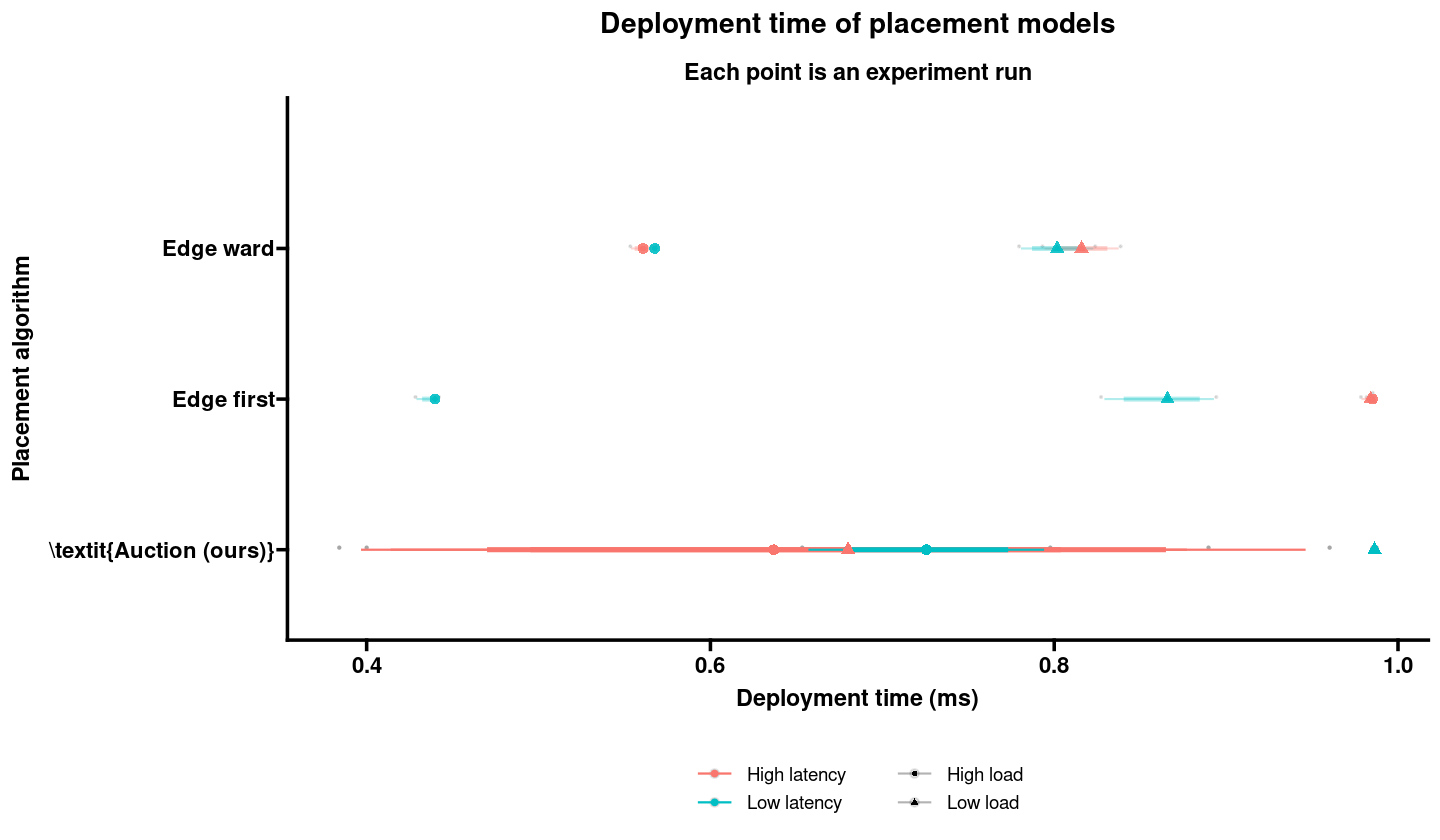

In [21]:

fig(12, 7)

# functions_total %>% select(metric_group) %>%
functions_total %>%
    # ungroup() %>%
    filter(status == "provisioned") %>%
    correct_names() %>%
    # adjust_timestamps() %>%
    ggplot(
        aes(
            y = `Placement method`,
            x = ratio,
            # color = factor(str_replace(interaction(load_type, latency_type), "\\.", ", ")),
            # shape = factor(str_replace(interaction(load_type, latency_type), "\\.", ", "))
            color = latency_type,
            shape = load_type,
        )
    ) +
    # geom_point()  +
    stat_dotsinterval() +
    # stat_dotsinterval(position = "dodge", point_interval = mode_hdci, point_alpha = 1) +
    gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
    # facet_grid(cols = vars(average_type), scales = "free") +
    labs(
        x = "Deployment time (ms)",
        y = "Placement algorithm",
        title = "Deployment time of placement models",
        subtitle = "Each point is an experiment run",
        color = "Function type",
        shape = "Function type",
    ) +
    theme(
        legend.position = "bottom",
        legend.direction = "vertical",
    )


In [22]:
bids_raw <- load_csv("bid_gauge.csv") %>% prepare() %>% prepare_convert()
# bids_raw %>% filter(value <= 0) %>% select(folder) %>% distinct()

bids_raw <- bids_raw %>% mutate(value = ifelse(value < 0 & value >= -0.001, 0, value))
bids_raw %>% filter(value < 0)
stopifnot(bids_raw %>% filter(value < 0) %>% summarise(n = n()) == 0)


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


New names:
• `` -> `...1`


...1,result,table,_start,_stop,timestamp,value,field,_measurement,bid_id,function_name,instance,sla_id,folder,metric_group,metric_group_group
<lgl>,<lgl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


`summarise()` has grouped output by 'sla_id', 'folder', 'metric_group', 'metric_group_group', 'latency_type'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”


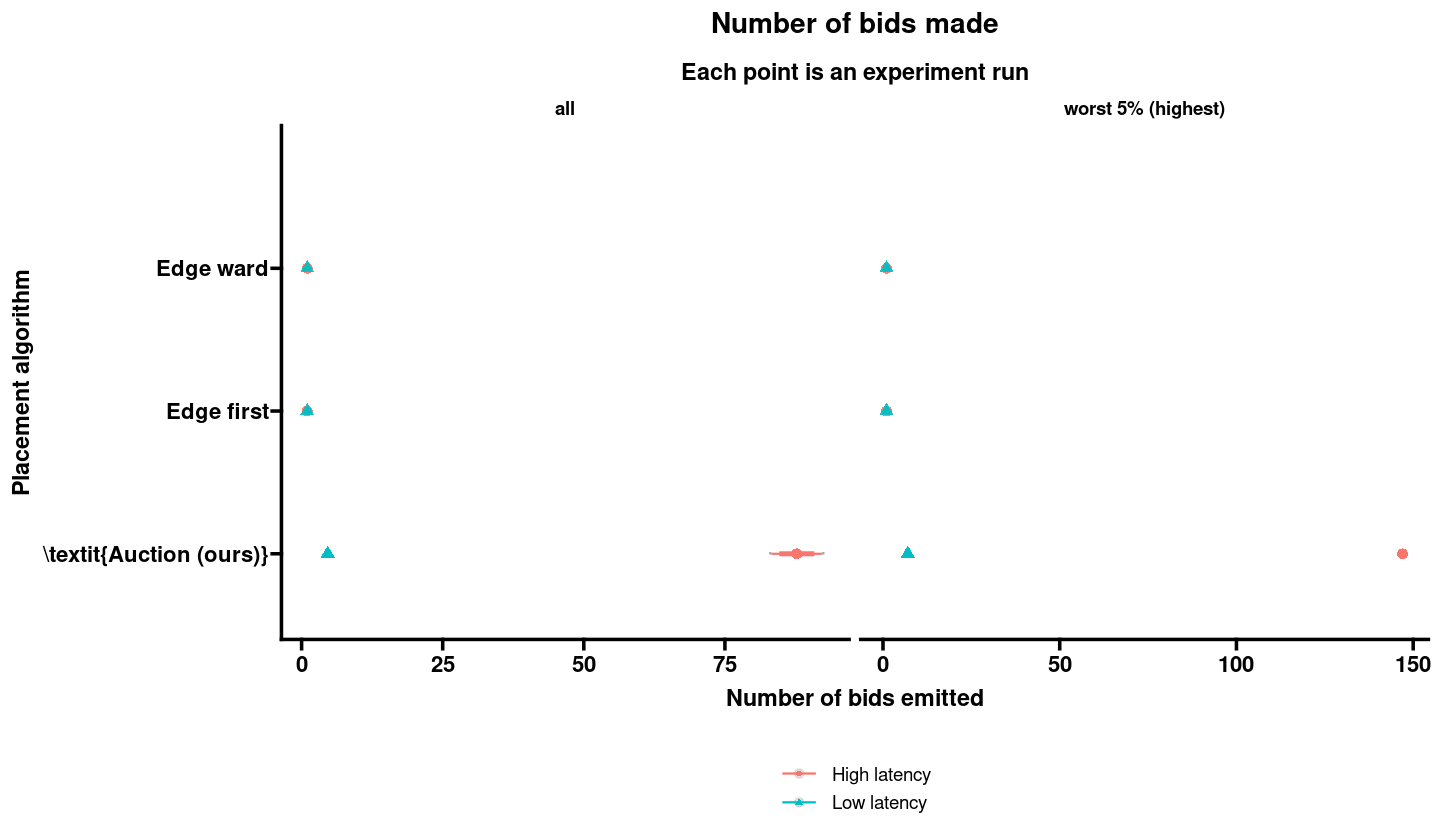

In [23]:
bids_function <- bids_raw %>%
  # inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
  select(instance, folder, metric_group, metric_group_group, function_name, sla_id, bid_id) %>%
  ungroup() %>%
  distinct() %>%
  extract_function_name_info() %>%
  group_by(sla_id, folder, metric_group, metric_group_group, latency_type, load_type) %>%
  summarise(n = n()) %>%
  {
    .
  }


top_1_percent <- bids_function %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  arrange(desc(n), .by_group = T) %>%
  mutate(rank = row_number()) %>%
  filter(rank <= ceiling(n() * 0.05)) %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(n_1_percent = mean(n))

bids_function <- bids_function %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(n = mean(n)) %>%
  inner_join(top_1_percent, by = c("folder", "metric_group", "latency_type")) %>%
  gather(key = "n_type", value = "n", n, n_1_percent) %>%
  mutate(n_type = case_when(
    n_type == "n" ~ "all",
    n_type == "n_1_percent" ~ "worst 5% (highest)",
  )) %>%
  {
    .
  }


# bids_function
# fig(12, 5)
# bids_function_graph <- bids_function %>%
#   mutate(latency_load = factor(str_replace(interaction(load_type, latency_type), "\\.", ", "))) %>%
#   ggplot(
#     aes(
#       x = metric_group,
#       y = n,
#       fill = latency_load,
#       group = interaction(latency_load, metric_group),
#     )
#   ) +
#   labs(
#     title = "Number of bids (total) made by each placement models",
#     x = "placement models",
#     y = "Number of bids"
#   ) +
#   geom_boxplot(alpha = 0.3, position = position_dodge2()) +
#   # geom_violin(width = 0.85) +
#   # geom_boxplot(
#   #   position = position_dodge(width = 0.85),
#   #   width = 0.1,
#   #   color = "white"
#   #   # fill=transp,
#   #   # alpha = 0.2
#   # ) +
#   scale_color_viridis(discrete = TRUE, option = "E") +
#   scale_fill_viridis(discrete = TRUE) +
#   theme(
#     # legend.position = "top",
#     # axis.title.x = element_blank(),
#     axis.text.x = element_text(angle = 45)
#   )
# bids_function_graph

bids_function_plot <- bids_function %>%
  correct_names() %>%
  ggplot(
    aes(
      y = `Placement method`,
      x = n,
      color = latency_type,
      shape = latency_type
      # dotsize = 0.6,
      # bindwidth=0.5,
      # # group = average_type,
      # linewidth=0,
    )
  ) +
  stat_dotsinterval() +
  # stat_dotsinterval(position = "dodge", point_interval = mode_hdci, point_alpha = 0.1) +
  # gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, scale = 0.8, bindwidth = 0.6, dotsize = 0.6, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  facet_grid(cols = vars(n_type), scales = "free") +
  labs(
    x = "Number of bids emitted",
    y = "Placement algorithm",
    title = "Number of bids made",
    subtitle = "Each point is an experiment run",
    color = "Function type",
    shape = "Function type",
  ) +
  theme(
    legend.position = "bottom",
    legend.direction = "vertical",
  )
bids_function_plot


In [24]:
provisioned_sla <- load_csv("function_deployment_duration.csv") %>%
  prepare() %>%
  prepare_convert() %>%
  select(bid_id, sla_id, folder, metric_group, metric_group_group) %>%
  distinct() %>%
  {
    .
  }
colnames(provisioned_sla)
# slice_sample(provisioned_sla, n=5)


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


[1] "bid_id"             "sla_id"             "folder"            
[4] "metric_group"       "metric_group_group"

In [25]:
bids_won_function <- bids_raw %>%
  select(sla_id, bid_id, instance, function_name, folder, metric_group, metric_group_group, value) %>%
  distinct() %>%
  inner_join(provisioned_sla, by = c("bid_id", "sla_id", "folder", "metric_group", "metric_group_group")) %>%
  # group_by(sla_id, instance, function_name, folder, metric_group, metric_group_group) %>%
  # arrange(desc(value), .by_group = TRUE) %>%
  # mutate(second_price = lag(value)) %>%
  # mutate(second_price = ifelse(is.na(second_price), value, second_price)) %>%
  # slice(which.min(value)) %>%
  mutate(winner = instance) %>%
  mutate(cost = value) %>%
  select(sla_id, function_name, folder, metric_group, metric_group_group, winner, cost) %>%
  {
    .
  }
# bids_won_function
# bids_won_function %>% group_by(sla_id, function_name, folder, metric_group, metric_group_group) %>% filter(n() > 1)
# head(bids_won_function %>% filter(sla_id=="466f56bb-9fa5-443d-9862-86d8c13a01bf"))


In [26]:
# # raw.cpu.observed_from_fog_node <- load_csv("cpu_observed_from_fog_node.csv") %>% prepare() %>%prepare_convert() 
# # raw.mem.observed_from_fog_node <- load_csv("memory_observed_from_fog_node.csv") %>% prepare() %>%prepare_convert() 
# registerDoParallel(parallel_loading_datasets_small)
# raw.cpu.observed_from_fog_node <- foreach (ark = METRICS_ARKS) %dopar% {
#         cpu <- load_single_csv(ark, "cpu_observed_from_fog_node.csv") %>%
#                 prepare() %>%
#                 prepare_convert()
#         cpu %>%
#                 filter(field == "initial_allocatable") %>%
#                 rename(initial_allocatable = value) %>%
#                 inner_join(cpu %>% filter(field == "used") %>% rename(used = value), by = c("timestamp", "folder", "instance", "metric_group", "metric_group_group")) %>%
#                 mutate(usage = used / initial_allocatable) %>%
#                 select(instance, timestamp, usage, folder, metric_group, metric_group_group)
# }
# raw.cpu.observed_from_fog_node <- bind_rows(raw.cpu.observed_from_fog_node)
# # cpu_observed_from_platform <- load_csv("fog_node_cpu_used.csv") %>% prepare()
# # colnames(cpu_observed_from_fog_node)


In [27]:
get_usage <- function(df_raw) {
    max_timestamp <- df_raw %>%
        select(timestamp, instance, folder) %>%
        group_by(instance, folder) %>%
        summarise(total_time = max(timestamp) - min(timestamp))

    df <- df_raw %>%
        filter(field == "initial_allocatable") %>%
        rename(initial_allocatable = value) %>%
        inner_join(df_raw %>% filter(field == "used") %>% rename(used = value), by = c("timestamp", "folder", "instance", "metric_group", "metric_group_group")) %>%
        mutate(usage = used / initial_allocatable) %>%
        select(instance, timestamp, usage, folder, metric_group, metric_group_group)
    stopifnot(nrow(df) * 2 == nrow(df_raw))

    df <- df %>%
        drop_na() %>%
        distinct() %>%
        group_by(instance, folder, metric_group, metric_group_group) %>%
        arrange(timestamp, .by_group = TRUE) %>%
        summarise(usage = sum(as.numeric(diff(timestamp), units = "secs") * rollmean(usage, 2))) %>%
        inner_join(max_timestamp, by = c("instance", "folder")) %>%
        mutate(usage_ratio = usage / as.numeric(total_time, units = "secs")) %>% # * 100%
        {
            .
        }

    folders <- df %>%
        ungroup() %>%
        select(folder, metric_group, metric_group_group) %>%
        distinct()

    missing_data <- expand.grid(
        instance = node_levels$name,
        folder = folders$folder
    ) %>%
        # inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
        inner_join(folders, by = c("folder"))

    df <- df %>%
        ungroup() %>%
        full_join(missing_data, by = c("instance", "folder", "metric_group", "metric_group_group")) %>%
        ungroup() %>%
        {
            .
        }

    df$usage_ratio[is.na(df$usage_ratio)] <- 0

    df
}

In [28]:

registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
raw.auc_usage.cpu <- bind_rows(foreach (ark = METRICS_ARKS) %dopar% {
        load_single_csv(ark, "cpu_observed_from_fog_node.csv") %>%
                prepare() %>%
                prepare_convert() %>%
                get_usage()
})

gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3161762,168.9,7474672,399.2,7474672,399.2
Vcells,43571959,332.5,70431819,537.4,70431808,537.4


In [30]:
raw.auc_usage.mem <- bind_rows(foreach (ark = METRICS_ARKS) %dopar% {
        load_single_csv(ark, "memory_observed_from_fog_node.csv") %>%
                prepare() %>%
                prepare_convert() %>%
                get_usage()
})

gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3161749,168.9,7474672,399.2,7474672,399.2
Vcells,43627049,332.9,70431819,537.4,70431808,537.4


In [29]:
total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group, winner) %>%
    summarise(earnings = sum(cost)) %>%
    {
        .
    }


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.


In [31]:
# fig(12, 7)
# value_of_bids <- bids_won_function %>%
#     extract_function_name_info() %>%
#     group_by(folder, metric_group, metric_group_group, winner, latency_type, load_type) %>%
#     summarise(function_cost = mean(cost), nb_functions = n()) %>%
#     inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
#     group_by(folder, metric_group, metric_group_group, latency_type, load_type, level) %>%
#     summarise(function_cost = mean(function_cost), nb_functions = sum(nb_functions)) %>%
#     {
#         .
#     }

# value_of_bids %>% filter(metric_group == "auction" & latency_type == "High latency" & load_type == "High load" & level == "Edge")

# value_of_bids %>%
#     correct_names() %>%
#     ggplot(aes(
#         x = function_cost,
#         y = `Placement method`,
#         color = level,
#         shape = level
#     )) +
#     stat_dotsinterval() +
#     # stat_dotsinterval(position = "dodge", point_interval = mode_hdci, point_alpha = 0.1) +
#     gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
#     facet_grid(cols = vars(interaction(load_type, latency_type))) +
#     #   labs(
#     #     x = "Deployment time (ms)",
#     #     y = "Placement algorithm",
#     #     title = "Deployment time of placement models",
#     #     subtitle = "Each point is an experiment run",
#     #     color = "Function type",
#     #     shape = "Function type",
#     #   ) +
#     theme(
#         legend.position = "bottom",
#         legend.direction = "vertical",
#     )


In [32]:
grand_total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group) %>%
    summarise(grand_total = sum(cost))


`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.


In [33]:
# transform_ratio_graph <- auc_usage %>%
#     mutate(winner = instance) %>%
#     ungroup() %>%
#     select(-instance) %>%
#     inner_join(grand_total_gains, by = c("folder", "metric_group", "metric_group_group")) %>%
#     inner_join(total_gains, by = c("folder", "metric_group", "metric_group_group", "winner")) %>%
#     mutate(gains_ratio = earnings / grand_total) %>%
#     inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
#     {
#         .
#     }


# folders <- transform_ratio_graph %>%
#     select(folder, metric_group, metric_group_group) %>%
#     distinct()
# missing_data <- expand.grid(
#     winner = node_levels$name,
#     folder = folders$folder
# ) %>%
#     inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
#     inner_join(folders, by = c("folder"))

# transform_ratio_graph <- transform_ratio_graph %>%
#     full_join(missing_data, by = c("winner", "level", "folder", "metric_group", "metric_group_group")) %>%
#     ungroup() %>%
#     {
#         .
#     }
# transform_ratio_graph$gains_ratio[is.na(transform_ratio_graph$gains_ratio)] <- 0

# top_1_percent <- transform_ratio_graph %>%
#     group_by(folder, metric_group, metric_group_group, level) %>%
#     arrange(desc(gains_ratio), .by_group = TRUE) %>%
#     mutate(rank = row_number()) %>%
#     filter(rank <= ceiling(n() * 0.05)) %>%
#     group_by(folder, metric_group, metric_group_group, level) %>%
#     summarize(gains_ratio_1_percent = mean(gains_ratio))

# transform_ratio_graph <- transform_ratio_graph %>%
#     group_by(metric_group, level, folder) %>%
#     summarise(gains_ratio = mean(gains_ratio)) %>%
#     inner_join(top_1_percent, by = c("folder", "metric_group", "level")) %>%
#     gather(key = "gains_ratio_type", value = "gains_ratio", gains_ratio, gains_ratio_1_percent) %>%
#     mutate(gains_ratio_type = case_when(
#         gains_ratio_type == "gains_ratio" ~ "all",
#         gains_ratio_type == "gains_ratio_1_percent" ~ "5% highest",
#     ))


# transform_ratio_graph_plot_earnings <- transform_ratio_graph %>%
#     filter(gains_ratio_type == "all") %>%
#     correct_names() %>%
#     ggplot(aes(
#         x = gains_ratio,
#         y = `Placement method`,
#         color = metric_group,
#         fill = metric_group,
#         shape = metric_group
#     )) +
#     # stat_dotsinterval(binwidth = 0.0015, scale = 0.95, size = 7, slab_linewidth = 0) +
#     stat_dotsinterval() +
#     # stat_dotsinterval(position = "dodge", binwidth = 0.0015, scale = 0.95, size = 7, slab_linewidth = 0) +
#     gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
#     scale_x_continuous(label = scales::percent) +
#     facet_grid2(cols = vars(level), rows = vars(gains_ratio_type), axes = "all", remove_labels = "y") +
#     labs(
#         y = "Placement algorithm",
#         x = "% of the total earnings",
#         title = "Ratio of earnings per fog node averaged in layers",
#         subtitle = "\\textit{Each point is an experiment run}",
#         fill = "Function type",
#         color = "Function type",
#         shape = "Function type"
#     ) +
#     theme(
#         legend.position = "none",
#         strip.text.y = element_blank()
#     ) +
#     coord_capped_cart(bottom = "both") +
#     scale_y_discrete(guide = guide_prism_bracket(width = 0.15))
# fig(12, 4)
# transform_ratio_graph_plot_earnings


In [34]:
grand_total_gains_local <- grand_total_gains %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(earnings = sum(grand_total))
categorize_x <- function(x) {
  if (x <= 130000) {
    return("b1")
  } else {
    return("b2")
  }
}

grand_total_gains_local$x_category <- as.factor(sapply(grand_total_gains_local$earnings, categorize_x))

maxmin <- grand_total_gains_local %>%
  group_by(x_category) %>%
  summarise(min = min(earnings), max = max(earnings), med = median(earnings)) %>%
  mutate(min = -1 * round(-1 * min, 2), max = round(max, 2)) %>%
  mutate(size = max - min)

maxmin <- maxmin %>%
  full_join(maxmin %>% ungroup() %>% summarise(max_size = max(size)), by = character()) %>% # cross join
  mutate(max_size = round(max_size * 1.33, 2), med = round(med, 2)) %>%
  mutate(min = -1 * round(-1 * (med - max_size / 2), 2), max = round(med + max_size / 2, 2)) %>%
  rowwise() %>%
  mutate(scale = c(scale_x_continuous(limits = c(min, max), breaks = seq(min, max, max_size / 2))))

# maxmin
# grand_total_gains_local
transform_ratio_graph_plot_sum_earnings <- grand_total_gains_local %>%
  correct_names() %>%
  ggplot(aes(
    x = earnings,
    y = `Placement method`,
    color = metric_group,
    fill = metric_group,
    shape = metric_group
  )) +
  stat_dotsinterval(position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 7, slab_linewidth = 0) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  # scale_x_continuous(label = scales::percent) +
  # facet_grid2(rows = vars(earnings_type), axes = "all", remove_labels = "y", scales="free_x") +
  labs(
    y = "Placement algorithm",
    x = "Earnings",
    title = "Total earnings per placement method",
    subtitle = "\\textit{Each point is an experiment run}",
    fill = "Function type",
    color = "Function type",
    shape = "Function type"
  ) +
  theme(
    legend.position = "none",
    strip.text.x = element_blank()
  ) +
  # facet_grid2(cols = vars(x_category), scales = "free_x") +
  # facetted_pos_scales(
  #   x = list(
  #     maxmin$scale[[1]],
  #     maxmin$scale[[2]]
  #   )
  # ) +
  # coord_cartesian(clip = "off") +
  # guides(x = guide_axis_truncated(trunc_lower = c(maxmin$min[[2]], maxmin$min[[1]]), trunc_upper = c(maxmin$max[[2]], maxmin$max[[1]]))) +
  # annotate("text", x = c(0, maxmin$max[[1]]), y = 0, label = "/ /", size = 10, vjust = 0.5) +
  scale_y_discrete(guide = guide_prism_bracket(width = 0.1)) +
  coord_capped_cart(bottom = "both")

# guides(x = guide_axis_truncated(trunc_lower = maxmin$min, trunc_upper = maxmin$max))



fig(9, 4)
# transform_ratio_graph_plot_sum_earnings


`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.
Warning message:
“Using `by = character()` to perform a cross join was deprecated in dplyr 1.1.0.
ℹ Please use `cross_join()` instead.”
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”


In [35]:
# # Define a function to calculate Jain's Faisrness Index
# jains_index <- function(allocations) {
#   num_users <- length(allocations)
#   sum_allocations <- sum(allocations)
#   sum_square_allocations <- sum(allocations^2)

#   index <- (sum_allocations^2) / (num_users * sum_square_allocations)
#   return(index)
# }

# transform_ratio_graph <- auc_usage %>%
#   mutate(winner = instance) %>%
#   ungroup() %>%
#   select(-instance) %>%
#   inner_join(grand_total_gains, by = c("folder", "metric_group", "metric_group_group")) %>%
#   inner_join(total_gains, by = c("folder", "metric_group", "metric_group_group", "winner")) %>%
#   mutate(gains_ratio = earnings / grand_total) %>%
#   {
#     .
#   }


# folders <- transform_ratio_graph %>%
#   select(folder, metric_group, metric_group_group) %>%
#   distinct()
# missing_data <- expand.grid(
#   winner = node_levels$name,
#   folder = folders$folder
# ) %>%
#   inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
#   inner_join(folders, by = c("folder"))

# transform_ratio_graph <- transform_ratio_graph %>%
#   full_join(missing_data, by = c("winner", "folder", "metric_group", "metric_group_group")) %>%
#   ungroup() %>%
#   {
#     .
#   }
# transform_ratio_graph$gains_ratio[is.na(transform_ratio_graph$gains_ratio)] <- 0

# # Calculate Jain's Fairness Index for each group using dplyr
# transform_ratio_graph <- transform_ratio_graph %>%
#   group_by(metric_group, folder) %>%
#   summarise(jains_index = jains_index(gains_ratio), n = n())

# # top_1_percent <- transform_ratio_graph %>%
# #   group_by(folder, metric_group, metric_group_group, level) %>%
# #   arrange(desc(gains_ratio), .by_group = TRUE) %>%
# #   mutate(rank = row_number()) %>%
# #   filter(rank <= ceiling(n() * 0.05)) %>%
# #   group_by(folder, metric_group, metric_group_group, level) %>%
# #   summarize(gains_ratio_1_percent = mean(gains_ratio))

# # transform_ratio_graph <- transform_ratio_graph %>%
# #   # group_by(metric_group, level, folder) %>%
# #   # summarise(gains_ratio = mean(gains_ratio)) %>%
# #   # inner_join(top_1_percent, by = c("folder", "metric_group", "level")) %>%
# #   gather(key = "gains_ratio_type", value = "gains_ratio", gains_ratio, gains_ratio_1_percent) %>%
# #   mutate(gains_ratio_type = case_when(
# #     gains_ratio_type == "gains_ratio" ~ "all",
# #     gains_ratio_type == "gains_ratio_1_percent" ~ "5% highest",
# #   ))

# # transform_ratio_graph
# categorize_x <- function(x) {
#   if (x <= 0.56) {
#     return("b1")
#   } else {
#     return("b2")
#   }
# }

# transform_ratio_graph$x_category <- as.factor(sapply(transform_ratio_graph$jains_index, categorize_x))

# maxmin <- transform_ratio_graph %>%
#   group_by(x_category) %>%
#   summarise(min = min(jains_index), max = max(jains_index), med = median(jains_index)) %>%
#   mutate(min = -1 * round(-1 * min, 2), max = round(max, 2)) %>%
#   mutate(size = max - min)

# maxmin <- maxmin %>%
#   full_join(maxmin %>% ungroup() %>% summarise(max_size = max(size)), by = character()) %>%
#   mutate(max_size = round(max_size * 1.33, 2), med = round(med, 2)) %>%
#   mutate(min = -1 * round(-1 * (med - max_size / 2), 2), max = round(med + max_size / 2, 2)) %>%
#   rowwise() %>%
#   mutate(scale = c(scale_x_continuous(limits = c(min, max), breaks = seq(min, max, max_size / 2), label = scales::percent)))
# # mutate(scale = c(scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.10), label = scales::percent)))

# # transform_ratio_graph
# fig(12, 6)
# transform_ratio_graph_plot_jain <- transform_ratio_graph %>%
#   correct_names() %>%
#   ggplot(aes(
#     x = jains_index,
#     y = `Placement method`,
#     color = metric_group,
#     fill = metric_group,
#     shape = metric_group
#   )) +
#   stat_dotsinterval(position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 7, slab_linewidth = 0) +
#   gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
#   labs(
#     y = "Placement algorithm",
#     x = "Jain's index in %",
#     title = "Jain's index of earning ratios per fog node",
#     subtitle = "\\textit{Each point is an experiment run}",
#     fill = "Function type",
#     color = "Function type",
#     shape = "Function type"
#   ) +
#   theme(
#     legend.position = "none",
#     strip.text.x = element_blank()
#   ) +
#   # facet_grid2(cols = vars(x_category), scales = "free_x") +
#   # facetted_pos_scales(
#   #   x = list(
#   #     maxmin$scale[[1]],
#   #     maxmin$scale[[2]]
#   #   )
#   # ) +
#   coord_cartesian(clip = "off") +
#   # guides(x = guide_axis_truncated(trunc_lower = maxmin$min, trunc_upper = maxmin$max)) +
#   # annotate("text", x = maxmin$max[[1]] + 0.003, y = 0, label = "/ /", size = 10, vjust = 0.5) +
#   scale_y_discrete(guide = guide_prism_bracket(width = 0.1))

# fig(9, 4)
# transform_ratio_graph_plot_jain
# # theme(
# #   legend.position = "none",
# #   # axis.line.x = element_blank()
# #   plot.margin = margin(l = 0),
# #   axis.line.y = element_blank()
# # )


## Latencies and SLAs

In [36]:
# # echo_sum <-
# #   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_sum.csv") %>%
# #   prepare()

# # echo_count <-
# #   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_count.csv") %>%
# #   prepare()

# echo_bucket_raw <-  load_csv_heavy("latency.csv") %>%
#   prepare() %>%
#   rename(function_name = tag)
# colnames(echo_bucket_raw)


In [37]:
# echo_bucket_raw <-  load_csv_heavy("latency.csv") %>%
#   prepare() %>%
#   rename(function_name = tag)
# colnames(echo_bucket_raw)

# latency_data <- echo_bucket_raw %>%
#     extract_function_name_info() %>%
#     inner_join(bids_won_function %>% select(sla_id, function_name, metric_group, metric_group_group, folder, winner), by = c("sla_id", "function_name", "folder", "metric_group_group", "metric_group")) %>%
#     {
#         .
#     }


In [38]:
errors <- tryCatch(
    {
        load_csv("iot_emulation_http_request_to_processing_echo_fails.csv") %>%
            prepare() %>%
            prepare_convert() %>%
            extract_function_name_info() %>%
            distinct()
    },
    error = function(cond) {
        columns <- c("instance", "job", "timestamp", "tag", "period", "folder", "metric_group", "latency", "value")
        df <- data.frame(instance = character(0), job = character(0), period = numeric(0), folder = character(0), metric_group = character(0), latency = character(0), value = numeric(0))
        return(df)
    }
)


In [39]:
# colnames(latency_data)
# apdex_data <- latency_data %>%
#     group_by(sla_id, folder, metric_group, instance) %>%
#     summarise(satisfied_count = sum(value <= latency), value_tolerated = sum(value <= latency + 0.003), total = n()) %>%
#     # summarise(across(satisfied_count = sum(value <= latency), value_tolerated = sum(value <= latency + 0.003))) %>%
#     distinct() %>%
#     mutate(tolerating_count = value_tolerated - satisfied_count) %>%
#     mutate(apdex = (satisfied_count + 0.5 * tolerating_count) / total) %>%
#     mutate(apdex_inv = 1 - apdex) %>%
#     inner_join(node_levels %>% rename(winner = name), by = c("winner")) %>%
#     {
#         .
#     }
# colnames(apdex_data)


In [40]:
# apdex_radar_data <- echo_bucket_raw %>%
#   # filter(metric_group == "auction1") %>%
#   rename(measured_latency = value, source = instance) %>%
#   select(sla_id, folder, metric_group, metric_group_group, source, timestamp, latency, measured_latency, latency_type, load_type) %>%
#   group_by(sla_id, folder, metric_group, source, latency_type, load_type) %>%
#   summarise(satisfied_count = sum(measured_latency <= latency), tolerating_count = sum(measured_latency > latency & measured_latency <= latency + 0.003), total = n()) %>%
#   mutate(apdex = (satisfied_count + 0.5 * tolerating_count) / total) %>%
#   mutate(apdex_category = interaction(load_type, latency_type)) %>%
#   inner_join(node_levels %>% mutate(name = to_snake_case(name)) %>% rename(source = name), by = ("source")) %>%
#   mutate(source = interaction(source, level, sep = "\n")) %>%
#   group_by(metric_group, folder, apdex_category, level, source) %>%
#   summarise(apdex = mean(apdex)) %>%
#   group_by(metric_group, folder, apdex_category, level) %>%
#   summarise(apdex = mean(apdex)) %>%
#   group_by(metric_group, apdex_category, level) %>%
#   summarise(apdex = mean(apdex)) %>%
#   ungroup() %>%
#   select(metric_group, apdex_category, apdex, level) %>%
#   # mutate(apdex = rescale(apdex-0.5, c(0, 1), from=c(0, 0.5))) %>%
#   pivot_wider(names_from = level, values_from = apdex) %>%
#   {
#     .
#   }

# apdex_radar_data <- apdex_radar_data %>%
#   rename(group = metric_group, facet = apdex_category) %>%
#   ungroup() %>%
#   select(group, everything())

# plots <- lapply(unique(apdex_radar_data$facet), function(facet_value) {
#   subset_data <- subset(apdex_radar_data, facet == facet_value, select = -c(facet)) %>%
#     `row.names<-`(., NULL) %>%
#     column_to_rownames(var = "group")
#   # fig(5, 5)
#   ggradar2(subset_data) + theme(legend.position = "none") + ggtitle(facet_value)
# })

# legend_b <- get_legend(
#   plots[[1]] +
#     guides(color = guide_legend(ncol = 1)) +
#     theme(legend.position = "left")
# )
# plots <- align_plots(plotlist = plots, align = "v", axis = "l")
# fig(15, 15)
# plots <- plot_grid(plotlist = plots)
# plot_grid(plots, legend_b, nrow = 2, rel_heights = c(1, 0.1))
# # Arrange and display the faceted plots
# # plot_grid(plotlist = plots, ncol = 1)


In [41]:
time_interval <- 15 # secs

smooth_timestamps <- function(data) {
  return(
    data %>%
      mutate(timestamp_group = as.difftime((as.numeric(round(timestamp)) %/% time_interval + 1) * time_interval, units = "secs")) %>%
      ungroup()
  )
}
if (generate_gif) {
data <- latency %>%
  filter(field == "raw") %>%
  ungroup() %>%
  rename(source = instance, destination = destination_name, latency_value = value) %>%
  select(timestamp, source, destination, folder, latency_value, diff) %>%
  smooth_timestamps() %>%
  group_by(timestamp_group, source, destination, folder) %>%
  summarise(latency_value = mean(latency_value), diff = mean(diff)) %>%
  rename(timestamp = timestamp_group) %>%
  ungroup() %>%
  {
    .
  }

# head(load_csv("provisioned_functions.csv") %>%
#   prepare() %>%
#   arrange(timestamp, .by_group = TRUE) %>%
#   filter(instance == "rennes"))

nodes <- load_csv("provisioned_functions.csv") %>%
  prepare() %>%
  group_by(timestamp, folder, instance) %>%
  mutate(provisioned = ifelse(value == 0, -1, value)) %>%
  summarise(provisioned = sum(provisioned), value = sum(value)) %>%
  group_by(folder, instance) %>%
  arrange(timestamp, .by_group = TRUE) %>%
  mutate(provisioned = lag(cumsum(provisioned), default = 0), total_provisioned = lag(cumsum(value), default = 0)) %>%
  rename(source = instance) %>%
  select(source, timestamp, folder, provisioned, total_provisioned) %>%
  smooth_timestamps() %>%
  group_by(timestamp_group, folder, source) %>%
  summarise(provisioned = last(provisioned), total_provisioned = last(total_provisioned)) %>%
  rename(timestamp = timestamp_group) %>%
  ungroup() %>%
  {
    .
  }
# nodes %>% filter(source == "rennes")
# nodes %>% filter(source == "st_greg_3_in")

cpu <- raw.cpu.usage %>%
  rename(source = instance) %>%
  select(timestamp, source, folder, usage) %>%
  smooth_timestamps() %>%
  group_by(timestamp_group, folder, source) %>%
  summarise(usage = mean(usage)) %>%
  rename(timestamp = timestamp_group) %>%
  ungroup()

gif.apdex.raw <- load_csv("latency.csv") %>%
    prepare() %>%
    rename(function_name = tag) %>%
    extract_function_name_info() %>%
    smooth_timestamps() %>%
    inner_join(bids_won_function %>% select(sla_id, function_name, metric_group, metric_group_group, folder, winner), by = c("sla_id", "function_name", "folder", "metric_group_group", "metric_group")) %>%
    rename(measured_latency = value, source = winner) %>%
    mutate(apdex_category = interaction(load_type, latency_type)) %>%
    group_by(timestamp_group, sla_id, folder, source, apdex_category) %>%
    summarise(satisfied_count = sum(measured_latency <= latency), tolerating_count = sum(measured_latency > latency & measured_latency <= latency + 0.003), total = n()) %>%
    mutate(apdex = (satisfied_count + 0.5 * tolerating_count) / total)

gif.apdex.by_node <- gif.apdex.raw %>%
    group_by(timestamp_group, folder, source) %>%
    summarise(apdex = mean(apdex)) %>%
    rename(timestamp = timestamp_group) %>%
    ungroup()

gif.apdex.by_function_and_node <- gif.apdex.raw %>%
    group_by(timestamp_group, folder, source, apdex_category) %>%
    summarise(apdex = mean(apdex)) %>%
    rename(timestamp = timestamp_group) %>%
    pivot_wider(names_from = apdex_category, values_from = apdex) %>%
    fill(everything(), .direction = "downup") %>%
    distinct() %>%
    ungroup()

all_combinations <- data %>%
  select(folder, source, destination) %>%
  distinct() %>%
  full_join(
    data %>%
      select(timestamp) %>%
      distinct() %>%
      full_join(nodes %>%
        select(timestamp) %>%
        distinct(), by = "timestamp") %>%
      full_join(gif.apdex.by_node %>%
        select(timestamp) %>%
        distinct(), by = "timestamp") %>%
      full_join(gif.apdex.by_function_and_node %>%
        select(timestamp) %>%
        distinct(), by = "timestamp") %>%
      full_join(cpu %>%
        select(timestamp) %>%
        distinct(), by = "timestamp"),
    by = character()
  )

data <- all_combinations %>%
  left_join(data, by = c("timestamp", "folder", "source", "destination")) %>%
  left_join(nodes, by = c("source", "timestamp", "folder")) %>%
  left_join(gif.apdex.by_node, by = c("source", "timestamp", "folder")) %>%
  left_join(cpu, by = c("source", "timestamp", "folder")) %>%
  left_join(gif.apdex.by_function_and_node, by = c("source", "timestamp", "folder")) %>%
  group_by(folder, source, destination) %>%
  arrange(timestamp, .by_group = TRUE) %>%
  fill(diff, provisioned, total_provisioned) %>%
  # mutate(provisioned = ifelse(is.na(provisioned), 0, provisioned)) %>%
  # mutate(total_provisioned = ifelse(is.na(total_provisioned), 0, total_provisioned)) %>%
  # mutate(diff = ifelse(is.na(diff), 0, diff)) %>%
  # mutate(cpu_usage = ifelse(is.na(cpu_usage), 0, cpu_usage)) %>%
  ungroup() %>%
  {
    .
  }

globally_provisioned <- data %>%
  select(source, folder, timestamp, total_provisioned) %>%
  distinct() %>%
  group_by(folder, timestamp) %>%
  summarise(globally_provisioned = sum(total_provisioned)) %>%
  ungroup()


data <- data %>%
  inner_join(globally_provisioned, by = c("folder", "timestamp")) %>%
  filter(source != destination) %>%
  select(source, destination, everything()) %>%
  rename(from = source, to = destination) %>%
  adjust_timestamps()

nrow(data)
}


In [42]:
fig(10, 10)

create_plot <- function(data) {
  net <- network(data, directed = TRUE, multiple = TRUE)
  net <- ggnetwork(net)
  name <- as.character(data$folder[1])
  duration <- max(data$timestamp) / time_interval
  print(duration)

  nudge_offset_x <- 0.05
  nudge_offset_y <- -0.3 / 2

  pggnetwork <-
    ggplot(
      net,
      aes(x = x, y = y, xend = xend, yend = yend)
    ) + # mapping for edges
    geom_edges(
      arrow = arrow(length = unit(3, "pt"), type = "open"), # if directed
      curvature = 0.1,
      aes(size = diff, alpha = latency_value, color = diff)
    ) +
    scale_colour_gradient(low = "green", high = "red", na.value = "grey50") +
    scale_alpha_continuous() +
    new_scale_color() +
    geom_nodes(aes(size = provisioned, color = apdex),
      alpha = 0.5,
    ) +
    scale_colour_gradient(low = "white", high = "darkblue", na.value = "grey50") +
    new_scale_color() +
    geom_nodes(aes(size = provisioned / 16, color = usage),
      alpha = 1,
    ) +
    scale_colour_gradient(low = "green", high = "red", na.value = "grey50") +
    new_scale_color() +
    scale_color_manual(values = c("grey40", "grey80")) +
    geom_nodetext(aes(label = sprintf("a: %1.2f", apdex)), color = "black", nudge_x = nudge_offset_x, nudge_y = nudge_offset_y + 0.3) +
    geom_nodetext(aes(label = sprintf("ll: %1.2f", `Low load.Low latency`), colour = is.na(`Low load.Low latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = nudge_offset_y + 0.25) +
    geom_nodetext(aes(label = sprintf("lh: %1.2f", `Low load.High latency`), colour = is.na(`Low load.High latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = nudge_offset_y + 0.2) +
    geom_nodetext(aes(label = sprintf("hh: %1.2f", `High load.High latency`), colour = is.na(`High load.High latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = nudge_offset_y + 0.15) +
    geom_nodetext(aes(label = sprintf("hl: %1.2f", `High load.Low latency`), colour = is.na(`High load.Low latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = nudge_offset_y + 0.1) +
    geom_nodetext(aes(label = sprintf("f: %02d/%02d", provisioned, total_provisioned)), color = "black", nudge_x = nudge_offset_x, nudge_y = nudge_offset_y + 0.05) +
    geom_nodetext(aes(label = sprintf("%s", vertex.names)), color = "grey80", nudge_x = nudge_offset_x, nudge_y = nudge_offset_y + 0) +
    geom_text(x = 0.05, y = 0.95, aes(label = paste0("Globally provisioned:", globally_provisioned)), color = "grey50", check_overlap = TRUE) +
    labs(title = "Time: {as.integer(frame_time)}") +
    transition_time(timestamp) +
    ease_aes("linear") +
    enter_fade() +
    exit_fade() +
    theme_blank() +
    theme(legend.position = "bottom")
  # +
  # facet_grid(cols = vars(folder))

  # out <- ggplot_build(pggnetwork)

  # rows <- max(out$layout$layout$ROW)
  # cols <- max(out$layout$layout$COL)
  print(duration)

  # print(pggnetwork[1])

  anim_save(filename = sprintf("%s.gif", name), animation = pggnetwork, renderer = gifski_renderer(), nframes = duration, fps = 60, height = 400, width = 1000)
}

if (generate_gif) {
  data_grouped <- data %>%
    group_by(folder) %>%
    group_split()

  animations <- lapply(data_grouped, FUN = create_plot)
}
# create_plot(data_grouped[[1]])


In [43]:
total_low_latency <- functions_total %>%
  filter(status == "provisioned") %>%
  filter(latency_type == "Low latency") %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarise(total = sum(total))

total <- functions_total %>%
  filter(status == "provisioned") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(total = sum(total))

total_low_latency <- total_low_latency %>%
  group_by(folder, metric_group, metric_group_group) %>%
  inner_join(total, by = c("folder", "metric_group", "metric_group_group")) %>%
  mutate(ratio_low_latency_functions = total.x / total.y) %>%
  select(folder, metric_group, metric_group_group, ratio_low_latency_functions)


ratio_low_latency <- functions_total %>%
  filter(status == "provisioned") %>%
  filter(latency_type == "Low latency") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(n = sum(n)) %>%
  inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
  mutate(ratio_low_latency = n / total)

ratio_total <- functions_total %>%
  filter(status == "provisioned") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(n = sum(n)) %>%
  inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
  mutate(ratio_total = n / total)


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.


In [44]:
colnames(total_low_latency)
# colnames(apdex_data)


[1] "folder"                      "metric_group"               
[3] "metric_group_group"          "ratio_low_latency_functions"

In [45]:


# apdex_data_line <- apdex_data %>%
#   inner_join(total_low_latency, by = c("folder", "metric_group", "metric_group_group")) %>%
#   mutate(satisfied = 1 - satisfied_count / total) %>%
#   ungroup()

# auc_usage_here <- auc_usage %>%
#   group_by(metric_group, folder, metric_group_group) %>%
#   summarise(usage = mean(usage_ratio))

# apdex_plot_data <- apdex_data_line %>%
#   inner_join(ratio_low_latency, by = c("metric_group", "metric_group_group", "folder")) %>%
#   group_by(metric_group, folder, metric_group_group, ratio_low_latency, ratio_low_latency_functions) %>%
#   summarise(apdex = mean(apdex)) %>%
#   inner_join(auc_usage_here, by = c("metric_group", "metric_group_group", "folder")) %>%
#   {
#     .
#   }

# apdex_plot_1_percent <- apdex_data_line %>%
#   inner_join(ratio_low_latency, by = c("metric_group", "metric_group_group", "folder")) %>%
#   group_by(metric_group, folder, metric_group_group, ratio_low_latency, ratio_low_latency_functions) %>%
#   arrange(apdex, .by_group = T) %>%
#   mutate(rank = row_number()) %>%
#   filter(rank <= ceiling(n() * 0.05)) %>%
#   summarise(apdex = mean(apdex)) %>%
#   inner_join(auc_usage %>%
#     group_by(metric_group, folder, metric_group_group) %>%
#     arrange(usage, .by_group = T) %>%
#     mutate(rank = row_number()) %>%
#     filter(rank <= ceiling(n() * 0.05)) %>%
#     summarise(usage = mean(usage_ratio)), by = c("metric_group", "metric_group_group", "folder"))
# finish_touch <- function(x) {
#   return(x %>%
#     mutate(diff = ratio_low_latency / ratio_low_latency_functions) %>%
#     mutate(total_score = 1 / 3 * (diff + apdex + usage)) %>%
#     group_by(metric_group, folder) %>%
#     select(total_score, usage, diff, apdex, metric_group, folder) %>%
#     gather(key = "score_type", value = "score", apdex, diff, usage) %>%
#     mutate(score_type_rich = case_when(
#       score_type == "apdex" ~ "$apdexScore$",
#       score_type == "diff" ~ "Ratio of aimed low latency functions deployed",
#       score_type == "usage" ~ "Ratio of total CPU reservation space used",
#       score_type == "total_score" ~ "Average of all scores"
#     )) %>%
#     {
#       .
#     })
# }

# apdex_plot_data <- finish_touch(apdex_plot_data) %>%
#   mutate(data_focus = "all") %>%
#   full_join(finish_touch(apdex_plot_1_percent) %>% filter(score_type != "diff") %>% mutate(data_focus = "worst 5%"), by = c("folder", "metric_group", "data_focus", "score_type", "score", "score_type_rich"))

# # apdex_plot
# fig(16, 8)
# apdex_plot <- apdex_plot_data %>%
#   correct_names() %>%
#   ggplot(
#     aes(
#       y = `Placement method`,
#       x = score,
#       color = score_type_rich,
#       shape = score_type_rich,
#       fill = score_type_rich,
#     )
#   ) +
#   # stat_dotsinterval(dotsize = 0.6, position = "dodge") +
#   # gghighlight(metric_group == "auction", unhighlighted_params = list(dotsize = 0.6, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10)) +
#   # stat_dotsinterval(quantiles=100,position = "dodge", bindwidth = 1.6, dotsize = 1.6, scale = 0.9) +
#   # gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, scale = 0.9, bindwidth = 1.6, dotsize = 1.6, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
#   stat_dotsinterval(slab_alpha = 0.6, position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 10, slab_linewidth = 0) +
#   gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
#   facet_grid2(rows = vars(data_focus), cols = vars(score_type_rich), scales = "free_x", axes = "all", remove_labels = "y") +
#   scale_x_continuous(label = scales::percent) +
#   coord_cartesian(clip = "off") +
#   labs(
#     x = "Score in %",
#     y = "Placement algorithm",
#     title = "Scores of placement models",
#     subtitle = "\\textit{Each point is an experiment run}",
#     color = "Score type",
#     fill = "Score type",
#     shape = "Score type"
#   ) +
#   theme(
#     legend.position = "bottom",
#     # panel.border=element_blank(), axis.line=element_line()
#     # legend.direction = "vertical",
#   ) +
#   coord_capped_cart(bottom = "both") +
#   # capped_horizontal(capped = c("both", "left", "right", "none")) +
#   # scale_x_continuous(guide = capped_horizontal(capped = c("both", "left", "right", "none"))) +
#   scale_y_discrete(guide = guide_prism_bracket(width = 0.15))

# apdex_plot


In [46]:
ggspider <- function(p_data,
                     ci = NULL,
                     mins_and_maxs = NULL,
                     polygon = TRUE,
                     scaled = FALSE,
                     draw_axis = TRUE,
                     background_color = "gray99",
                     area_fill = TRUE,
                     fill_opacity = 0.05,
                     central_distance = 0.2,
                     axis_name_offset = 0.2,
                     digit_rounding = 2) {
  legend_title <- names(p_data)[[1]]
  p_data <- p_data %>%
    dplyr::rename(group = 1) %>%
    dplyr::mutate(group = factor(group))
  ci_was_null <- FALSE
  if (is.null(ci)) {
    ci <- rbind(p_data %>% mutate(type = "h"), p_data %>% mutate(type = "l"))
    ci_was_null <- TRUE
  }
  ci <- ci %>%
    dplyr::rename(group = 1) %>%
    dplyr::mutate(group = factor(group))
  ci.h <- ci %>%
    filter(type == "h") %>%
    select(-type)
  ci.l <- ci %>%
    filter(type == "l") %>%
    select(-type)

  if (is.null(mins_and_maxs)) {
    mins_and_max <- rbind(p_data, ci.h, ci.l)
  }

  circle_coords <- function(r, n_axis = ifelse(polygon == TRUE, ncol(p_data) - 1, 100)) {
    fi <- seq(0, 2 * pi, (1 / n_axis) * 2 * pi) + pi / 2
    x <- r * cos(fi)
    y <- r * sin(fi)

    tibble::tibble(x, y, r)
  }

  # Grid
  (step_1 <- purrr::map_df(seq(0, 1, 0.25) + central_distance, circle_coords) %>%
    ggplot2::ggplot(ggplot2::aes(x, y)) +
    ggplot2::geom_polygon(data = circle_coords(1 + central_distance), alpha = 1, fill = background_color, lty = 2) +
    ggplot2::geom_path(ggplot2::aes(group = r), lty = 2, alpha = 0.5) +
    ggplot2::theme_void())


  axis_coords <- function(n_axis) {
    fi <- seq(0, (1 - 1 / n_axis) * 2 * pi, (1 / n_axis) * 2 * pi) + pi / 2
    x1 <- central_distance * cos(fi)
    y1 <- central_distance * sin(fi)
    x2 <- (1 + central_distance) * cos(fi)
    y2 <- (1 + central_distance) * sin(fi)

    tibble::tibble(x = c(x1, x2), y = c(y1, y2), id = rep(1:n_axis, 2))
  }

  text_data <- mins_and_maxs %>%
    dplyr::select(-group) %>%
    purrr::map_df(~ min(., na.rm = TRUE) + (max(., na.rm = TRUE) - min(., na.rm = TRUE)) * seq(0, 1, 0.25)) %>%
    dplyr::mutate(r = seq(0, 1, 0.25)) %>%
    tidyr::pivot_longer(-r, names_to = "parameter", values_to = "value")

  text_coords <- function(r, n_axis = ncol(p_data) - 1) {
    fi <- seq(0, (1 - 1 / n_axis) * 2 * pi, (1 / n_axis) * 2 * pi) + pi / 2 + 0.01 * 2 * pi / r
    x <- r * cos(fi)
    y <- r * sin(fi)

    tibble::tibble(x, y, r = r - central_distance)
  }

  labels_data <- purrr::map_df(seq(0, 1, 0.25) + central_distance, text_coords) %>%
    dplyr::bind_cols(text_data %>% dplyr::select(-r))


  rescaled_coords <- function(r, n_axis) {
    fi <- seq(0, 2 * pi, (1 / n_axis) * 2 * pi) + pi / 2
    tibble::tibble(r, fi) %>%
      dplyr::mutate(x = r * cos(fi), y = r * sin(fi)) %>%
      dplyr::select(-fi)
  }
  
  rescaled_data <- rbind(p_data %>% mutate(type = "v"), ci.h %>% mutate(type = "h"), ci.l %>% mutate(type = "l"), mins_and_maxs %>% mutate(type = "nope")) %>%
    dplyr::mutate(across(-c(group, type), scales::rescale))
    
  ci.rescaled_data.h <- rescaled_data %>%
    filter(type == "h") %>%
    select(-type)
  ci.rescaled_data.l <- rescaled_data %>%
    filter(type == "l") %>%
    select(-type)
  rescaled_data <- rescaled_data %>%
    filter(type == "v") %>%
    select(-type)

  rescaled_data <- rescaled_data %>%
    dplyr::mutate(copy = dplyr::pull(., 2)) %>% # da se moze geom_path spojiti opet na pocetnu tocku
    tidyr::pivot_longer(-group, names_to = "parameter", values_to = "value") %>%
    dplyr::group_by(group) %>%
    dplyr::mutate(coords = rescaled_coords(value + central_distance, ncol(p_data) - 1)) %>%
    tidyr::unnest(cols = c(coords))
  ci.rescaled_data.l <- ci.rescaled_data.l %>%
    dplyr::mutate(copy = dplyr::pull(., 2)) %>% # da se moze geom_path spojiti opet na pocetnu tocku
    tidyr::pivot_longer(-group, names_to = "parameter", values_to = "value") %>%
    dplyr::group_by(group) %>%
    dplyr::mutate(coords = rescaled_coords(value + central_distance, ncol(ci.l) - 1)) %>%
    tidyr::unnest(cols = c(coords))
  ci.rescaled_data.h <- ci.rescaled_data.h %>%
    dplyr::mutate(copy = dplyr::pull(., 2)) %>% # da se moze geom_path spojiti opet na pocetnu tocku
    tidyr::pivot_longer(-group, names_to = "parameter", values_to = "value") %>%
    dplyr::group_by(group) %>%
    dplyr::mutate(coords = rescaled_coords(value + central_distance, ncol(ci.h) - 1)) %>%
    tidyr::unnest(cols = c(coords))

  # ci.rescaled_data = rbind(ci.rescaled_data.h, ci.rescaled_data.l)

  step_1 +
    {
      if (draw_axis == TRUE) ggplot2::geom_line(data = axis_coords(ncol(p_data) - 1), ggplot2::aes(x, y, group = id), alpha = 0.3)
    } +
    # Normal points
    ggplot2::geom_point(data = rescaled_data, ggplot2::aes(x, y, shape = group, group = group, col = group), size = 4) +
    ggplot2::geom_path(data = rescaled_data, ggplot2::aes(x, y, group = group, col = group), size = 0.75) +
    # ggplot2::geom_errorbar(data = ci.rescaled_data, aes(ymin=len-sd, ymax=len+sd), width=.2,position=position_dodge(0.05)) +
    # Lower
    ggplot2::geom_point(data = ci.rescaled_data.l, ggplot2::aes(x, y, shape = group, group = group, col = group), size = 1) +
    # ggplot2::geom_path(data = ci.rescaled_data.l, ggplot2::aes(x, y, group = group, col = group), size = 0.2) +
    # Upper
    ggplot2::geom_point(data = ci.rescaled_data.h, ggplot2::aes(x, y, shape = group, group = group, col = group), size = 1) +
    # ggplot2::geom_path(data = ci.rescaled_data.h, ggplot2::aes(x, y, group = group, col = group), size = 0.2) +
    {
      if (area_fill == TRUE) {
        if (ci_was_null) {
          ggplot2::geom_polygon(data = rescaled_data, ggplot2::aes(x, y, group = group, col = group, fill = group), size = 1, alpha = fill_opacity, show.legend = FALSE)
        } else {
          # ggplot2::geom_mark_hull(data = rbind(ci.rescaled_data.h, ci.rescaled_data.l  %>% dplyr::arrange(-dplyr::row_number())), concavity = 5,expand=0,radius=0,aes(fill=age))
          ggplot2::geom_polygon(data = rbind(ci.rescaled_data.h, ci.rescaled_data.l %>% dplyr::arrange(-dplyr::row_number())), ggplot2::aes(x, y, group = group, col = group, fill = group), size = 0, alpha = fill_opacity, show.legend = FALSE)
        }
      }
    } +
    {
      if (scaled == TRUE) {
        ggplot2::geom_text(
          data = labels_data %>% dplyr::filter(parameter == labels_data$parameter[[1]]), ggplot2::aes(x, y, label = r), alpha = 0.65,
          family = theme_get()$text[["family"]],
          # size = theme_get()$text[["size"]] / 2.75,
          size = theme_get()$text[["size"]] / 3,
          fontface = "plain"
        )
      } else {
        ggplot2::geom_text(
          data = labels_data, ggplot2::aes(x, y, label = round(value, digit_rounding)), alpha = 0.65,
          family = theme_get()$text[["family"]],
          size = theme_get()$text[["size"]] / 3,
          # size = theme_get()$text[["size"]] / 2.75,
          fontface = "plain"
        )
      }
    } +
    ggplot2::geom_text(
      data = text_coords(1 + central_distance + axis_name_offset), ggplot2::aes(x, y), label = labels_data$parameter[1:(ncol(p_data) - 1)],
      family = theme_get()$text[["family"]],
      size = theme_get()$text[["size"]] / 2.75,
      fontface = "plain"
    ) +
    ggplot2::labs(col = legend_title) +
    ggplot2::theme(
      legend.position = "bottom",
      legend.text = ggplot2::element_text(size = 12),
      legend.title = ggplot2::element_text(size = 12)
    )
}

worst_5 <- function(df) {
  return(
    df %>%
      arrange(score, .by_group = T) %>%
      mutate(rank = row_number()) %>%
      filter(rank <= ceiling(n() * 0.05)) %>%
      # filter(rank <= ifelse(ceiling(n() * 0.05) == 0, 1, ceiling(n() * 0.05))) %>%
      mutate(data_focus = "Worst 5%") %>%
      full_join(df %>% mutate(data_focus = "All"))
  )
}


summarySE <- function(data = NULL, measurevar, groupvars = NULL, se = NULL, sd= NULL, na.rm = FALSE,
                      conf.interval = .95, .drop = TRUE) {


  # New version of length which can handle NA's: if na.rm==T, don't count them
  length2 <- function(x, na.rm = FALSE) {
    if (na.rm) sum(!is.na(x))
    else       length(x)
  }

  groupvars  <- rlang::syms(groupvars)
  measurevar <- rlang::sym(measurevar)
  se_raw <- se
  se <- rlang::sym(ifelse(is.null(se_raw), "se", se_raw))
  sd_raw <- sd
  sd <- rlang::sym(ifelse(is.null(sd_raw), "sd", sd_raw))

  datac <- data %>%
    dplyr::group_by(!!!groupvars) %>%
    dplyr::summarise(
      N             = length2(!!measurevar, na.rm = na.rm),
      # sd            = sd     (!!measurevar, na.rm = na.rm),
      !!sd            := ifelse(is.null(sd_raw) || any(is.na(!!sd)) , sd(!!measurevar, na.rm = na.rm), sqrt(sum(((!!sd)) ** 2, na.rm = na.rm))),
      !!measurevar := mean   (!!measurevar, na.rm = na.rm),
      # se            = ifelse(is.null(se_raw), sd / sqrt(N), sqrt(sum(((!!se) / N) ** 2, na.rm = na.rm))),
      !!se            := !!sd / sqrt(N),
      # Confidence interval multiplier for standard error
      # Calculate t-statistic for confidence interval:
      # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
      ci            = !!se * qt(conf.interval/2 + .5, N - 1)
    ) %>%
    dplyr::ungroup() %>%
    # Rearrange the columns so that sd, se, ci are last
    dplyr::select(seq_len(ncol(.) - 4), ncol(.) - 2, !!sd, !!se, ci)

  datac
}

In [47]:
raw.deployment_times <-  load_csv("function_deployment_duration.csv") %>%
  prepare() %>%
  prepare_convert() %>%
  extract_function_name_info()
colnames(raw.deployment_times)
# head(deployment_times_raw)


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


[1] "...1"                            "result"                         
 [3] "table"                           "_start"                         
 [5] "_stop"                           "timestamp"                      
 [7] "value"                           "field"                          
 [9] "_measurement"                    "bid_id"                         
[11] "function_name"                   "instance"                       
[13] "sla_id"                          "folder"                         
[15] "metric_group"                    "metric_group_group"             
[17] "docker_fn_name"                  "function_index"                 
[19] "latency"                         "cpu"                            
[21] "mem"                             "load_type"                      
[23] "latency_type"                    "nb_fn_low_interval_low_latency" 
[25] "nb_fn_high_interval_low_latency"

`summarise()` has grouped output by 'folder', 'metric_group_group', 'metric_group', 'load_type'. You can override using the
`.groups` argument.
Joining with `by = join_by(folder)`
Adding missing grouping variables: `metric_group_group`
Adding missing grouping variables: `load_type`


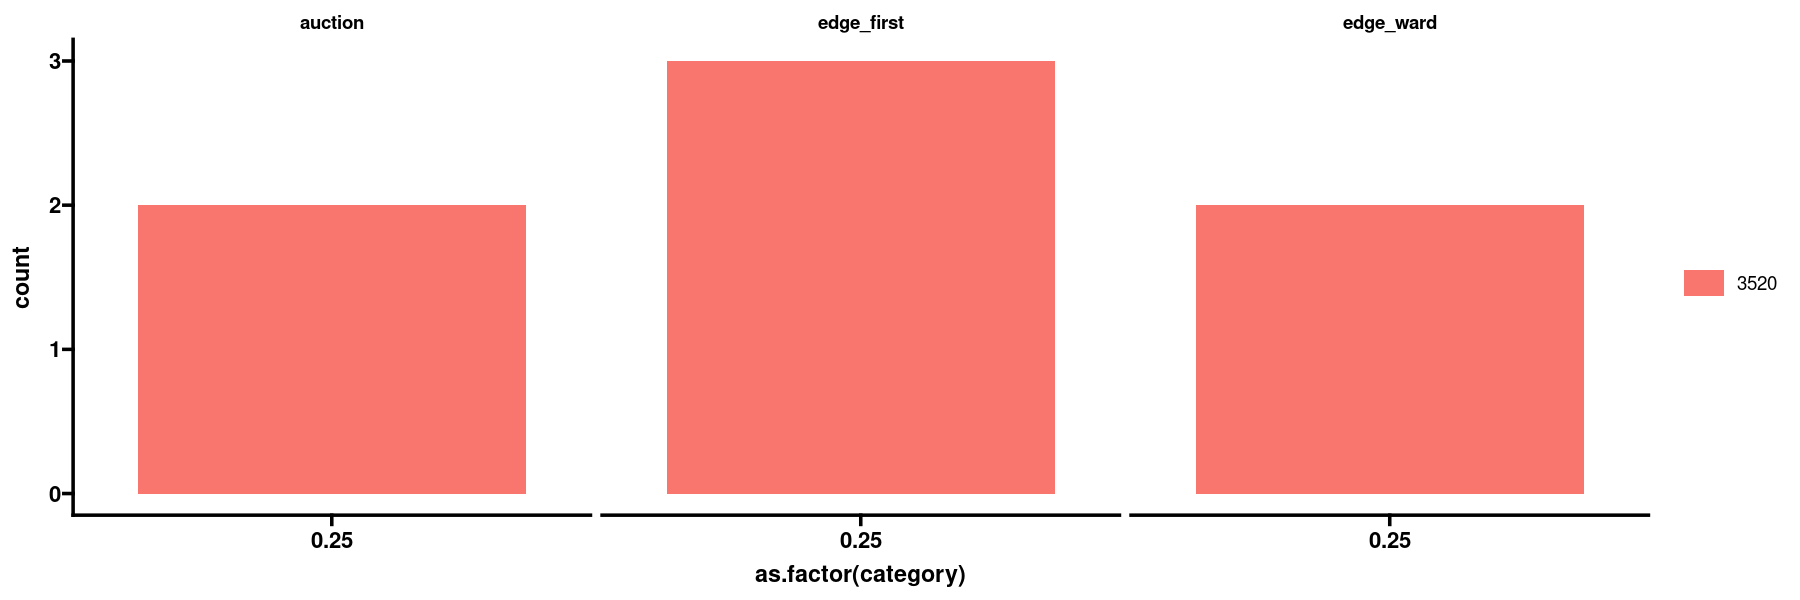

In [48]:
raw.nb_functions <- load_csv("nb_functions.csv") %>%
    rename(load_type = load, latency_type = latency) %>%
    mutate(
    instance = to_snake_case(instance),
    load_type = case_when(
        load_type == "low" ~ "Low load",
        load_type == "high" ~ "High load",
        TRUE ~ "unimplemented",
    ),
    latency_type = case_when(
        latency_type == "low" ~ "Low latency",
        latency_type == "high" ~ "High latency",
        TRUE ~ "unimplemented",
    ))


raw.nb_functions.total <- raw.nb_functions %>%
    group_by(folder, metric_group_group, metric_group, load_type, latency_type) %>%
    summarise(total = sum(value)) %>%
    mutate(folder = gsub(".tar.xz","", folder))

count.total <- raw.nb_functions.total  %>% 
    inner_join(raw.nb_functions.total %>% 
        ungroup() %>%
        select(folder, total, latency_type, load_type) %>%
        distinct() %>%
        group_by(folder) %>%
        summarise(sum = sum(total))) %>%
    select(folder, metric_group, sum, total, latency_type, load_type) %>%
    mutate(ratio = total/sum)



raw.function_low_latency_load_category <- count.total %>%
    filter(latency_type == "Low latency" & load_type == "High load") %>%
    select(-c(latency_type, load_type)) %>%
    ungroup() %>%
    select(folder, metric_group, ratio, sum) %>%
    distinct() %>%
    rename(category = ratio, requests = sum)

    # raw.function_low_latency_load_category  %>% group_by(request, category, metric_group) %>% summarise(tot = n())
# count.total
fig(15,5)
raw.function_low_latency_load_category %>%
    ggplot(aes(x = as.factor(category), group = factor(requests), fill = factor(requests))) +
    geom_bar(position = "dodge") +
    facet_wrap(~metric_group)


In [49]:
if (reload_big_data) {
    registerDoParallel(cl = parallel_loading_datasets, cores = parallel_loading_datasets)
    spider_all.apdex <- foreach (ark = METRICS_ARKS) %dopar% {
    load_single_csv(ark, "latency.csv") %>%
        prepare() %>%
        rename(function_name = tag) %>%
        extract_function_name_info() %>%
        inner_join(bids_won_function %>% select(sla_id, function_name, metric_group, metric_group_group, folder, winner), by = c("sla_id", "function_name", "folder", "metric_group_group", "metric_group")) %>%
        rename(measured_latency = value, source = winner) %>%
        select(sla_id, folder, metric_group, metric_group_group, source, timestamp, latency, measured_latency, latency_type, load_type) %>%
        group_by(sla_id, folder, metric_group, metric_group_group, source, latency_type, load_type) %>%
        summarise(satisfied_count = sum(measured_latency <= latency), tolerating_count = sum(measured_latency > latency & measured_latency <= latency + 0.003), total = n()) %>%
        mutate(score = (satisfied_count + 0.5 * tolerating_count) / total) %>%
        mutate(score_type_rich = sprintf("$apdex$\n%s %s", load_type, latency_type)) %>%
        group_by(metric_group, metric_group_group, folder, score_type_rich, source, load_type, latency_type) %>%
        worst_5() %>%
        summarySE("score", c("metric_group", "metric_group_group", "folder", "score_type_rich", "source", "data_focus"))
    }

    spider_all.apdex <- bind_rows(spider_all.apdex)
    spider_all.apdex %>% write.csv(.,file = "./save_apdex.csv")
}

gc()

Warning message in mclapply(argsList, FUN, mc.preschedule = preschedule, mc.set.seed = set.seed, :
“scheduled core 1 did not deliver a result, all values of the job will be affected”


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3192735,170.6,7474672,399.2,7474672,399.2
Vcells,44201167,337.3,70431819,537.4,70431808,537.4


In [50]:
spider_all.apdex <- read.csv("./save_apdex.csv")

In [51]:
jains_index <- function(allocations) {
  num_users <- length(allocations)
  sum_allocations <- sum(allocations)
  sum_square_allocations <- sum(allocations^2)
  index <- (sum_allocations^2) / (num_users * sum_square_allocations)
  return(index)
}

earnings.total_per_instance <- bids_won_function %>%
  group_by(folder, metric_group, metric_group_group, winner) %>%
  summarise(earnings = sum(cost))

folders <- earnings.total_per_instance %>%
  ungroup() %>%
  select(folder, metric_group, metric_group_group) %>%
  distinct()

missing_data <- expand.grid(
  winner = node_levels$name,
  folder = folders$folder
) %>%
  inner_join(folders) %>%
  anti_join(earnings.total_per_instance %>% ungroup() %>% select(folder, winner))

earnings.total_per_instance <- earnings.total_per_instance %>%
  full_join(missing_data, by = c("winner", "folder", "metric_group", "metric_group_group")) %>%
  mutate(earnings = ifelse(is.na(earnings), 0, earnings)) %>%
  ungroup() 

earnings.total <- earnings.total_per_instance %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(earnings = sum(earnings))

earnings.jain <- earnings.total_per_instance %>%
  inner_join(earnings.total %>% rename(total = earnings), by = c("folder", "metric_group", "metric_group_group")) %>%
  mutate(earnings_ratio = earnings / total)

# Calculate Jain's Fairness Index for each group using dplyr
spider_all.earnings.ratio <- earnings.jain %>%
  group_by(metric_group, folder, winner, metric_group_group) %>%
  rename (score = earnings_ratio) %>%
  mutate(score_type_rich = "Earning shares") 
  
spider_all.earnings.ratio.highest <- spider_all.earnings.ratio %>%
  group_by(metric_group, folder, metric_group_group) %>%
  mutate(score = 1/score) %>%
  worst_5() %>%
  mutate(score = 1/score) %>%
  filter(data_focus == "Worst 5%") %>%
  mutate(score_type_rich = "Earning shares\n(highest)") %>%
  summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE)

 spider_all.earnings.ratio <-  spider_all.earnings.ratio %>%
  group_by(metric_group, folder, metric_group_group) %>%
  worst_5() %>%
  summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE)

spider_all.earnings.jain <- earnings.jain %>%
  group_by(metric_group, folder, metric_group_group) %>%
  summarise(jains_index = jains_index(earnings_ratio), n = n()) %>%
  rename(score = jains_index ) %>%
  mutate(score_type_rich = "Jain's index") %>%
  mutate(data_focus = "All") %>%
  summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE) 

spider_all.auc_usage.cpu <- raw.auc_usage.cpu %>%
  select(metric_group, folder, instance, usage_ratio, metric_group_group) %>%
  rename(source = instance, score = usage_ratio) %>%
  mutate(score = as.numeric(score)) %>%
  mutate(score_type_rich = "CPU Usage") %>%
  group_by(score_type_rich, metric_group, folder, metric_group_group) %>%
  worst_5() %>%
  ungroup %>%
  summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE) 



spider_all.auc_usage.mem <- raw.auc_usage.mem %>%
  select(metric_group, folder, instance, usage_ratio, metric_group_group) %>%
  rename(source = instance, score = usage_ratio) %>%
  mutate(score = as.numeric(score)) %>%
  mutate(score_type_rich = "Mem Usage") %>%
  group_by(score_type_rich, metric_group, folder, metric_group_group) %>%
  worst_5() %>%
  summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE) 

spider_all.functions_total <- functions_total %>%
    filter(status == "provisioned") %>%
    inner_join(raw.nb_functions.total %>% rename(all = total)) %>%
    mutate (score = n / all) %>%
    mutate(score_type_rich = sprintf("Provisioned fns\n%s %s", load_type, latency_type)) %>%
    ungroup() %>%
    select(score, score_type_rich, folder, metric_group, metric_group_group)  %>%
    mutate(data_focus = "All") 


spider_all.deployment_times <- raw.deployment_times %>%
  ungroup() %>%
  select(load_type, sla_id, load_type, latency_type, function_name, folder,  metric_group, value, metric_group_group) %>%
  mutate(score = 1000/value) %>%
  mutate(score_type_rich = sprintf("Deployment time\n%s %s", load_type, latency_type)) %>%
  select(score, score_type_rich, folder, metric_group, sla_id, metric_group_group) %>%
  group_by(folder, metric_group, score_type_rich, metric_group_group) %>%
  worst_5() %>%
  mutate(score = 1/score) %>%
  summarySE("score", c("folder", "score_type_rich", "metric_group", "data_focus", "metric_group_group"), na.rm = TRUE) 

bounds <- function(df){
  df %>% 
    # mutate(ci = ifelse(is.na(ci), 0, ci)) %>%
    # mutate(se = ifelse(is.na(se), 0, se)) %>%
    # mutate(sd = ifelse(is.na(sd), 0, sd)) %>%
    mutate(lower.ci.score = score - ci) %>%
    mutate(upper.ci.score = score + ci) 
}
spider_all.together <- spider_all.earnings.ratio.highest %>%
  full_join(spider_all.deployment_times)%>%
  ungroup() %>%
  summarySE("score", c("data_focus", "metric_group", "score_type_rich", "metric_group_group"), se = "se", sd = "sd", na.rm = TRUE, conf.interval = 0.99) %>%
  bounds() %>%
  mutate(lower.ci.score =  ifelse(lower.ci.score < 0, 0, lower.ci.score)) %>%
    full_join(spider_all.apdex %>% 
      full_join(spider_all.functions_total) %>% 
      full_join(spider_all.earnings.ratio)%>%
      full_join(spider_all.earnings.jain) %>%
      full_join(spider_all.auc_usage.cpu) %>% 
      full_join(spider_all.auc_usage.mem) %>% 
      inner_join(raw.function_low_latency_load_category) %>%
      summarySE("score", c("data_focus", "metric_group", "score_type_rich", "category"), se = "se", sd ="sd", na.rm = TRUE, conf.interval = 0.99) %>%
      bounds() %>%
      mutate(lower.ci.score = ifelse(lower.ci.score < 0, 0, lower.ci.score)) %>%
      mutate(upper.ci.score = ifelse(upper.ci.score > 1, 1, upper.ci.score))
  ) %>%  
  rename(mean.score = score) %>%
  ungroup()

spider_all.ci.lower <- spider_all.together %>%
  select(data_focus, lower.ci.score, metric_group, score_type_rich, category) %>%
  pivot_wider(names_from = score_type_rich, values_from = lower.ci.score) %>%
  mutate(type = "l")

spider_all.ci.upper <- spider_all.together %>%
  select(data_focus, upper.ci.score, metric_group, score_type_rich, category) %>%
  pivot_wider(names_from = score_type_rich, values_from = upper.ci.score) %>%
  mutate(type = "h") 

spider_all.ci <- rbind(spider_all.ci.lower, spider_all.ci.upper)


spider_all.together <- spider_all.together %>%
  ungroup() %>%
  select(data_focus, metric_group, score_type_rich, mean.score, category) %>%
  pivot_wider(names_from = score_type_rich, values_from = mean.score)
  
spider_all.together <- spider_all.together %>%
  ungroup() %>%
  rename(group = metric_group) %>%
  mutate(facet = sprintf("%s: %s", category, data_focus)) %>%
  select(-c(category, data_focus)) %>%
  select(group, everything())

spider_all.ci <- spider_all.ci %>%
  ungroup() %>%
  rename(group = metric_group) %>%
  mutate(facet = sprintf("%s: %s", category, data_focus, sep = ":")) %>%
  select(-c(category, data_focus)) %>%
  select(group, everything())

# apdex_plot_data_radar
# spider_all.plots <- lapply(unique(spider_all.together$facet), function(facet_value) {
#   subset_data.data <- subset(spider_all.together, facet == facet_value, select = -c(facet)) %>%
#     select(group, everything())
#   subset_data.ci <- subset(spider_all.ci, facet == facet_value, select = -c(facet)) 
#   mins_and_maxs =  spider_all.ci %>% select(-c(facet, type)) 

#   subset_data.ci <- subset_data.ci[,colSums(is.na(subset_data.ci))<nrow(subset_data.ci)]
#   mins_and_maxs <- mins_and_maxs[,colSums(is.na(subset_data.data))<nrow(subset_data.data)]
#   subset_data.data <- subset_data.data[,colSums(is.na(subset_data.data))<nrow(subset_data.data)]

#   plot <- ggspider(subset_data.data, ci = subset_data.ci, mins_and_maxs = mins_and_maxs , polygon = FALSE, fill_opacity=0.1, draw_axis = TRUE, axis_name_offset = 0.4, central_distance = 0.4) + 
#   theme(legend.position = "none") +
#   ggtitle(facet_value)+
#   coord_cartesian(clip = 'off', expand =   TRUE) +
#   theme(plot.margin = margin(2, 2, 2, 2, "cm"))
#   plot
#   # gg_table <- ggplot_gtable(ggplot_build(plot))
#   # gg_table$layout$clip[gg_table$layout$name=="panel"] <- "off"
#   # grid.draw(gg_table)
# })

# legend_b <- get_legend(
#   spider_all.plots[[1]] +
#     guides(color = guide_legend(nrow = 1)) +
#     theme(legend.position = "bottom"
# ))
# spider_all.plots <- align_plots(plotlist = spider_all.plots, align = "v", axis = "l")
# fig(20, 22)
# spider_all.plots <- plot_grid(plotlist = spider_all.plots)
# plots.spider_all <- plot_grid(spider_all.plots, legend_b, nrow = 2, rel_heights = c(1, 0.1))
# plots.spider_all


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
Joining with `by = join_by(folder)`
Joining with `by = join_by(winner, folder)`
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.


Joining with `by = join_by(folder, metric_group, metric_group_group, winner, earnings, total, score, score_type_rich, data_focus)`
`summarise()` has grouped output by 'data_focus', 'folder', 'score_type_rich', 'metric_group'. You can override using the `.groups`
argument.
Joining with `by = join_by(folder, metric_group, metric_group_group, winner, earnings, total, score, score_type_rich, data_focus)`
`summarise()` has grouped output by 'data_focus', 'folder', 'score_type_rich', 'metric_group'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'metric_group', 'folder'. You can override using the `.groups` argument.
Warning message:
“There were 7 warnings in `dplyr::summarise()`.
The first warning was:
ℹ In argument: `ci = se * qt(conf.interval/2 + 0.5, N - 1)`.
ℹ In group 1: `data_focus = "All"`, `folder =
  "metrics_equal_linear_pricing_big2.env.scenario_1-edge_first_valuation_rates_no-telemetry_2023-07-31-20-07"`, `score_type_rich =
  "Jain's index"`, 

In [52]:
fig(15, 15)

ecdf.earnings <- earnings.jain %>%
    # group_by(metric_group, folder, winner, metric_group_group) %>%
    rename (score = earnings_ratio) %>%
    inner_join(raw.function_low_latency_load_category) 
    # filter(data_focus == "All") %>%
    # mutate(lower = score - ci, upper = score + ci) %>%
    # group_by(category, metric_group) %>%
    # do(data.frame(., score1 = ecdf(.$score)(.$score))) %>%
    # do(data.frame(., lower1 = ecdf(.$lower)(.$score))) %>%
    # do(data.frame(., upper1 = ecdf(.$upper)(.$score)))


# ecdf.earnings %>%
#     group_by(winner) %>%
#     ggplot(aes(x = score, group = metric_group, color = metric_group, linetype = metric_group)) +
#     stat_ecdf() +
#     # stat_ecdf(aes(y = score,  color = metric_group), geom = "step") +
#     # stat_ecdf(aes(y = lower), geom = "step") +
#     # stat_ecdf(aes(y = upper), geom = "step") +
#     # geom_ribbon(aes(ymin=lower1,ymax=upper1),alpha=0.15) +
#     # geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) +
#     facet_grid(rows = vars(requests), cols = vars(category)) 


Joining with `by = join_by(folder, metric_group)`


`summarise()` has grouped output by 'folder', 'winner'. You can override using the `.groups` argument.
Joining with `by = join_by(winner, folder, metric_group)`
`summarise()` has grouped output by 'metric_group'. You can override using the `.groups` argument.
Joining with `by = join_by(metric_group, folder)`
`summarise()` has grouped output by 'category', 'requests'. You can override using the `.groups` argument.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


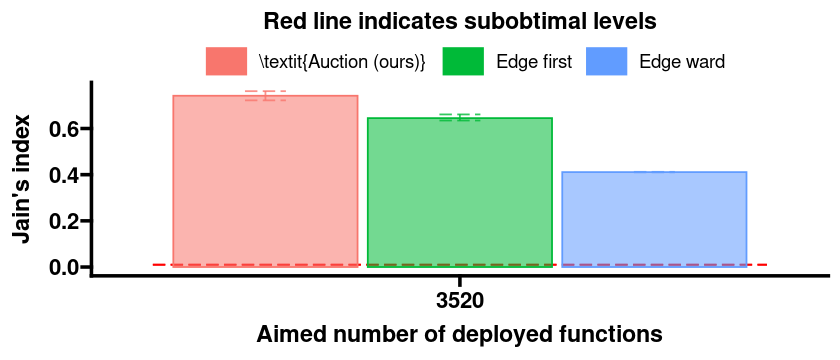

In [53]:
earnings.jains.plot.data.raw <- node_levels %>%
    rename(winner = name) %>%
    full_join(bids_won_function %>% group_by(folder, winner, metric_group) %>% summarise(earnings = sum(cost))) %>%
    mutate(earnings = ifelse(is.na(earnings), 0, earnings)) %>%
    group_by(metric_group, folder) %>%
    summarise(jains_index = jains_index(earnings), worst_case = round(1 / n(), 2), n = n()) %>%
    inner_join(raw.function_low_latency_load_category) %>%
    rename(score = jains_index)

earnings.jains.plot.data.worst_case <- earnings.jains.plot.data.raw %>%
    ungroup() %>%
    select(requests, category, worst_case) %>%
    distinct()

# earnings.jains.plot.data.worst_case

earnings.jains.plot.data <- earnings.jains.plot.data.raw %>%
    summarySE("score", c("category", "requests", "metric_group"))

plots.jains.w <- 7
plots.jains.h <- 3
plots.jains.caption <- "Jain's index by target ratio of low latency and \n load deployed functions and target deployment sizes"
fig(plots.jains.w, plots.jains.h)

# plots.jains <- earnings.jains.plot.data %>%
#     correct_names() %>%
#     ggplot(aes(x = factor(category), y = score,  group = `Placement method`, fill = `Placement method`)) +
#     geom_col(position = "dodge") +
#     geom_errorbar(data=earnings.jains.plot.data.worst_case, aes(x = factor(requests), ymax = worst_case, ymin = worst_case),
#                size=0.5, linetype = "longdash", inherit.aes = F, width = 1, color = "red") +
#     labs(title = "Jain's index by target number of functions deployed",
#     subtitle = "Red line indicates subobtimal levels",
#     x = "Aimed number of deployed functions",
#     y = "Jain's index") +
#     theme(legend.position = "bottom") +
#     theme(legend.position = c(.5, .99)) +
#     guides(fill = guide_legend(nrow = 1))
# plots.jains

plots.jains <- earnings.jains.plot.data.raw %>%
    correct_names() %>%
    ggplot(aes(alpha = 1, x = factor(requests), y = score, shape = `Placement method`, fill = `Placement method`, color = `Placement method`)) +
    geom_errorbar(
        data = earnings.jains.plot.data.worst_case, aes(x = factor(requests), ymax = worst_case, ymin = worst_case),
        size = 0.5, linetype = "longdash", inherit.aes = F, width = 1, color = "red"
    ) +
    stat_summary(
        geom = "errorbar",
        fun.min = function(z) quantile(z, .025),
        fun = mean,
        fun.max = function(z) quantile(z, 0.975),
        position = position_dodge(width = .95),
        size = 0.5, width = .2, linetype = "longdash", alpha = .8
    ) +
    stat_summary(fun.y = mean, position = position_dodge(width = .95), geom = "col") +
    # stat_summary(fun.y=mean,position=position_dodge(width=.95),geom="point", size = 2)+
    labs(
        subtitle = "Red line indicates subobtimal levels",
        x = "Aimed number of deployed functions",
        y = "Jain's index"
    ) +
    scale_alpha_continuous(guide = "none") +
    guides(color = guide_legend(nrow = 1), shape = guide_legend(nrow = 1), size = guide_legend(nrow = 1)) +
    theme(legend.background = element_rect(
        fill = alpha("white", .7),
        size = 0.2, color = "white"
    )) +
    theme(legend.position = "top", legend.box = "vertical") +
    theme(legend.spacing.y = unit(0, "cm"), legend.margin = margin(0, 0, 0, 0), legend.box.margin = margin(0, -10, -10, -10), )
plots.jains


In [54]:
if (reload_big_data) {
    registerDoParallel(cl = parallel_loading_datasets, cores = parallel_loading_datasets)
    apdex.jitter <- foreach (ark = METRICS_ARKS) %dopar% {
    tmp <- load_single_csv(ark, "latency.csv")%>%
        prepare() %>%
        rename(function_name = tag) %>%
        extract_function_name_info() %>%
        rename(measured_latency = value) %>%
        select(sla_id, folder, timestamp, measured_latency, latency) %>%
        group_by(sla_id, folder)

        jitter_sla <- tmp %>% filter(measured_latency > latency) %>%
            summarise(jitter_above = mean(abs(measured_latency - mean(measured_latency))),
            jitter_above_sla = mean(abs(measured_latency - latency)),
            mean_above_sla = mean(measured_latency))


        tmp %>%
        summarise(
            jitter = mean(abs(measured_latency - mean(measured_latency))),
            satisfied_count = sum(measured_latency <= latency),
            tolerating_count = sum(measured_latency > latency & measured_latency <= latency + 0.003), 
            total = n()) %>%
        mutate(apdex = (satisfied_count + 0.5 * tolerating_count) / total) %>%
        inner_join(jitter_sla)
        # summarySE("score", c("metric_group", "metric_group_group", "folder", "score_type_rich", "source", "data_focus"))
    }

    apdex.jitter <- bind_rows(apdex.jitter)
    apdex.jitter %>% write.csv(.,file = "./save_jitter.csv")
}

gc()

Warning message in mclapply(argsList, FUN, mc.preschedule = preschedule, mc.set.seed = set.seed, :
“scheduled core 1 did not deliver a result, all values of the job will be affected”


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3224107,172.2,7474672,399.2,7474672,399.2
Vcells,44367061,338.5,70431819,537.4,70431808,537.4


In [55]:
apdex.jitter <- read.csv("./save_jitter.csv")

[1] "X"                  "metric_group"       "metric_group_group"
 [4] "folder"             "score_type_rich"    "source"            
 [7] "data_focus"         "N"                  "score"             
[10] "sd"                 "se"                 "ci"

Joining with `by = join_by(metric_group, folder)`


Warning message:
“Removed 6 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 6 rows containing non-finite values (`stat_density()`).”


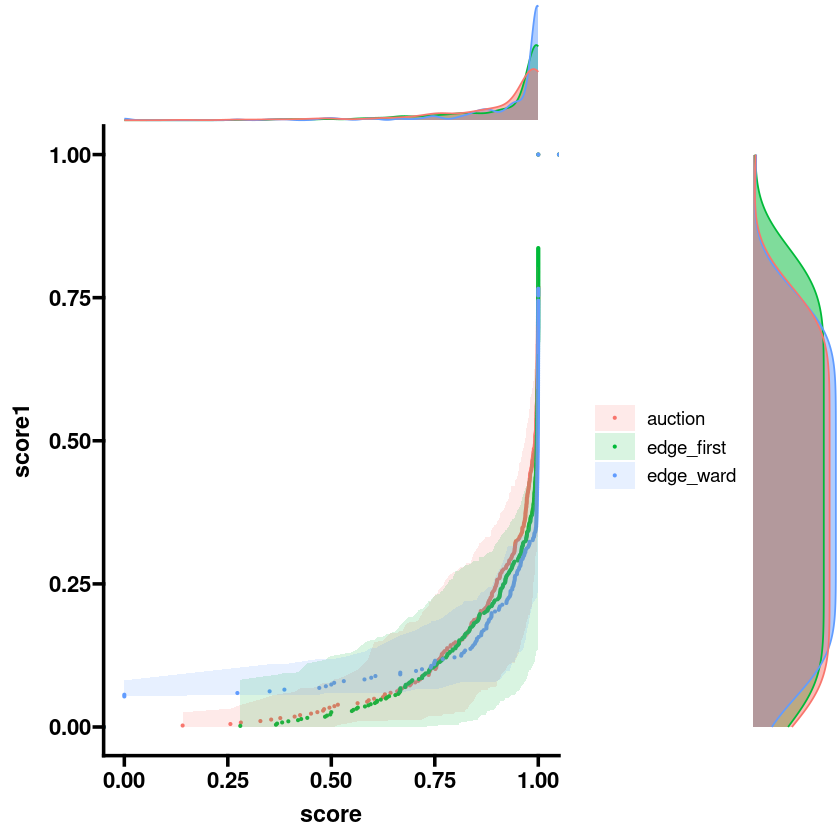

In [56]:
fig(7, 7)
colnames(spider_all.apdex)

ecdf.apdex <- spider_all.apdex %>%
    inner_join(raw.function_low_latency_load_category) %>%
    filter(data_focus == "All") %>%
    mutate(lower = score - ci, upper = score + ci) %>%
    # group_by(category, metric_group) %>%
    group_by(metric_group) %>%
    do(data.frame(., score1 = ecdf(.$score)(.$score))) %>%
    do(data.frame(., lower1 = ecdf(.$lower)(.$score))) %>%
    do(data.frame(., upper1 = ecdf(.$upper)(.$score)))


ecdf.apdex.plot <- ecdf.apdex %>%
    ggplot(aes(x = score, group = metric_group, fill = metric_group, linetype = metric_group)) +
    stat_ecdf(aes(y = score1,  color = metric_group), geom = "point", size = .5) +
    # stat_ecdf(aes(y = lower), geom = "step") +
    # stat_ecdf(aes(y = upper), geom = "step") +
    geom_ribbon(aes(ymin=lower1,ymax=upper1),alpha=0.15) 
    # geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) +
    # facet_grid(rows = vars(requests), cols = vars(category)) +
    # theme(legend.position = "none")

ggMarginal(ecdf.apdex.plot, type = "density", groupColour = TRUE, groupFill = TRUE)


[1] "folder"             "metric_group"       "metric_group_group"
[4] "winner"             "earnings"           "total"             
[7] "earnings_ratio"

[1] "...1"                            "result"                         
 [3] "table"                           "_start"                         
 [5] "_stop"                           "timestamp"                      
 [7] "value"                           "field"                          
 [9] "_measurement"                    "bid_id"                         
[11] "function_name"                   "instance"                       
[13] "sla_id"                          "folder"                         
[15] "metric_group"                    "metric_group_group"             
[17] "docker_fn_name"                  "function_index"                 
[19] "latency"                         "cpu"                            
[21] "mem"                             "load_type"                      
[23] "latency_type"                    "nb_fn_low_interval_low_latency" 
[25] "nb_fn_high_interval_low_latency"

Joining with `by = join_by(folder, metric_group)`


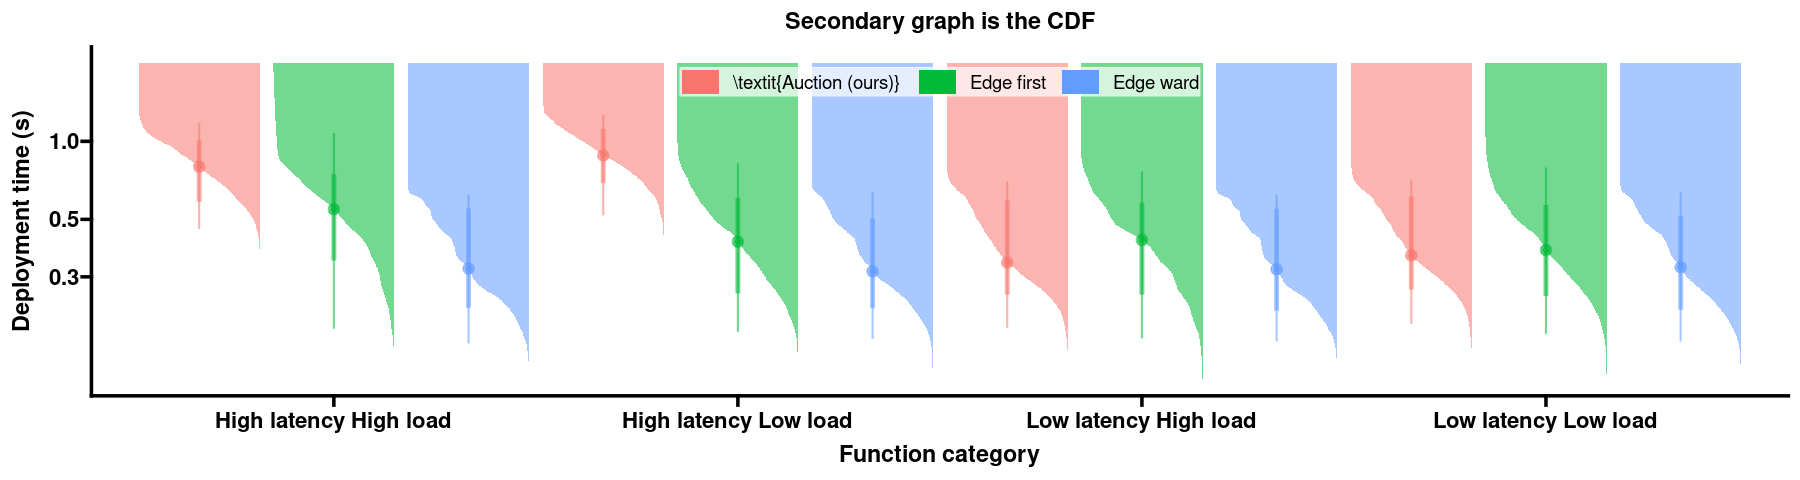

In [57]:
colnames(earnings.jain)

center_reduction <- function(data, colvar) {
    colvar <- rlang::sym(colvar)
    data %>%
        inner_join(data %>% summarise(mean = mean(!!colvar), sd = sd(!!colvar))) %>%
        mutate(!!colvar := (!!colvar - mean)/sd) %>%
        select(-c("sd", "mean"))
}

colnames(raw.deployment_times)

raw.deployment_times.plot.data <- raw.deployment_times %>%
    inner_join(raw.function_low_latency_load_category) %>%
    mutate(fn_category = sprintf("%s %s", latency_type, load_type)) %>%
    mutate(value = value / 1000)

    # group_by(category, metric_group, folder, requests) %>%
    # group_by(metric_group) %>%
    # center_reduction("value") %>%
    # summarySE("value", c("category", "requests", "metric_group", "folder" ,"instance")) %>%
    # summarySE("value", c("category", "requests", "metric_group", "folder"), se = "se", sd ="sd", na.rm = TRUE, conf.interval = 0.99) %>%
    # summarySE("value", c("category", "requests", "metric_group"), se = "se", sd ="sd", na.rm = TRUE, conf.interval = 0.99) %>%
    # ggplot(aes(x = category, y = value, color = metric_group)) +
    # # geom_col(position = "dodge") +
    # geom_line() +
    # geom_errorbar(aes(ymin=value-se, ymax=value+se), width=.1, position = position_dodge(0.1)) +
    # facet_grid(rows = vars(requests))

plots.deployment_times.w = 15
plots.deployment_times.h = 4
plots.deployment_times.caption = "Deployment times per function category"
fig(plots.deployment_times.w, plots.deployment_times.h)

plots.deployment_times <- raw.deployment_times.plot.data %>% 
    correct_names() %>%
    ggplot(aes(alpha=0, x = factor(fn_category), y = value, group = `Placement method`, color = `Placement method`, fill = `Placement method`)) +
    stat_cdfinterval(position = "dodge") +
    scale_y_continuous(trans = "log10") +
    scale_alpha_continuous(guide = "none") +
    labs(subtitle = "Secondary graph is the CDF",
    x = "Function category",
    y = "Deployment time (s)"
    ) +
    theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    theme(legend.position = c(.5, .90)) +
    guides(colour = guide_legend(nrow = 1))

plots.deployment_times    

In [58]:
colnames(raw.deployment_times.plot.data)

slice_sample(raw.deployment_times.plot.data %>% select(instance, everything()), n = 5)

[1] "...1"                            "result"                         
 [3] "table"                           "_start"                         
 [5] "_stop"                           "timestamp"                      
 [7] "value"                           "field"                          
 [9] "_measurement"                    "bid_id"                         
[11] "function_name"                   "instance"                       
[13] "sla_id"                          "folder"                         
[15] "metric_group"                    "metric_group_group"             
[17] "docker_fn_name"                  "function_index"                 
[19] "latency"                         "cpu"                            
[21] "mem"                             "load_type"                      
[23] "latency_type"                    "nb_fn_low_interval_low_latency" 
[25] "nb_fn_high_interval_low_latency" "category"                       
[27] "requests"                        "fn_category"

instance,...1,result,table,_start,_stop,timestamp,value,field,_measurement,⋯,latency,cpu,mem,load_type,latency_type,nb_fn_low_interval_low_latency,nb_fn_high_interval_low_latency,category,requests,fn_category
<chr>,<lgl>,<lgl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
marketplace,NA,NA,1432,1970-01-01,2023-07-31 17:58:06,2023-07-31 17:13:31,0.212,value,function_deployment_duration,⋯,0.090,50,50,Low load,High latency,20,20,0.25,3520,High latency Low load
marketplace,NA,NA,2248,1970-01-01,2023-07-31 17:46:50,2023-07-31 17:16:25,0.419,value,function_deployment_duration,⋯,0.100,50,50,Low load,High latency,20,20,0.25,3520,High latency Low load
marketplace,NA,NA,2236,1970-01-01,2023-08-01 01:54:03,2023-08-01 01:12:53,0.451,value,function_deployment_duration,⋯,0.086,500,100,High load,High latency,20,20,0.25,3520,High latency High load
marketplace,NA,NA,2089,1970-01-01,2023-07-31 20:08:04,2023-07-31 19:38:51,0.446,value,function_deployment_duration,⋯,0.012,500,100,High load,Low latency,20,20,0.25,3520,Low latency High load
marketplace,NA,NA,13,1970-01-01,2023-07-31 17:46:50,2023-07-31 17:02:25,0.453,value,function_deployment_duration,⋯,0.011,500,100,High load,Low latency,20,20,0.25,3520,Low latency High load


Joining with `by = join_by(function_name, sla_id, folder, metric_group, metric_group_group)`
Joining with `by = join_by(folder, metric_group, category, requests)`
Joining with `by = join_by(folder, metric_group, metric_group_group, winner)`


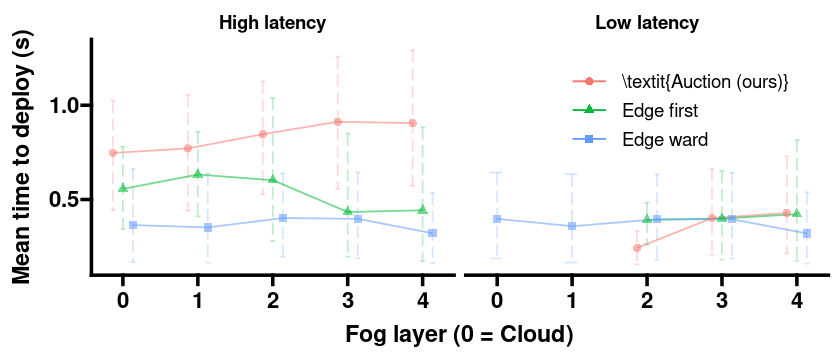

In [59]:
plots.deploymenttimes.line.w <- 7
plots.deploymenttimes.line.h <- 3
plots.deploymenttimes.line.caption = "Time to find a function location by Fog layers"
fig(plots.deploymenttimes.line.w, plots.deploymenttimes.line.h)

plots.deploymenttimes.line <- raw.deployment_times.plot.data %>% 
    inner_join(bids_won_function) %>%
    inner_join(raw.function_low_latency_load_category) %>%
    left_join(node_levels %>% rename(winner = name)) %>%
    # summarySE("value", c("level_value", "metric_group", "latency_type"), conf.interval = .99) %>%
    correct_names() %>%
    ggplot(aes(alpha=0, x = level_value, y = value, color = `Placement method`, fill = `Placement method`, shape =  `Placement method`)) +
    # stat_cdfinterval(position = "dodge") +
    # geom_beeswarm(dodge.width = 1) +
    # geom_point() +
    # geom_line() +
    # geom_errorbar(aes(ymax = value + ci, ymin = value -ci),
    #     size=0.5, width = .2, linetype ="longdash", alpha = .2) +
     stat_summary(geom = "errorbar", 
               fun.min = function(z) quantile(z, .025), 
               fun = mean,
               fun.max = function(z) quantile(z, 0.975),
               position=position_dodge(width=0.4),
               size=0.5, width = .2, linetype ="longdash", alpha = .25) +
    stat_summary(fun.y=mean,position=position_dodge(width=0.4),geom="line")+
    stat_summary(fun.y=mean,position=position_dodge(width=0.4),geom="point", size = 2)+
    # geom_errorbar(data = ecdf.jitter.mean, aes(x = fn_category, ymax = mean_jitter, ymin = mean_jitter),
    #     size=0.5, linetype = "longdash", inherit.aes = F, width = 1, color = "red") +
    # geom_text(data = ecdf.jitter.mean, aes(x = fn_category, y = mean_jitter, 
    #     label = sprintf("$\\overline{x}=%s$", round(mean_jitter, 2))), vjust = -0.5, inherit.aes = F, color = "red") + 
    # scale_y_continuous(trans = "log10") +
    scale_alpha_continuous(guide = "none") +
    # gghighlight(`Placement method` == "\\textit{Auction (ours)}") +
    labs(
    y = "Mean time to deploy (s)",
    x = "Fog layer (0 = Cloud)",
    ) +
       theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    theme(legend.position = c(.8, .7)) +
    guides(colour = guide_legend(ncol = 1)) +
    facet_wrap(vars(latency_type))

plots.deploymenttimes.line

[1] "folder"             "metric_group"       "metric_group_group"
[4] "winner"             "earnings"           "total"             
[7] "earnings_ratio"

Joining with `by = join_by(folder, metric_group)`
Joining with `by = join_by(folder, metric_group, category, requests)`
Joining with `by = join_by(folder, metric_group, metric_group_group, winner)`
`summarise()` has grouped output by 'folder', 'fn_category', 'winner', 'level_value', 'metric_group', 'category'. You can override
using the `.groups` argument.


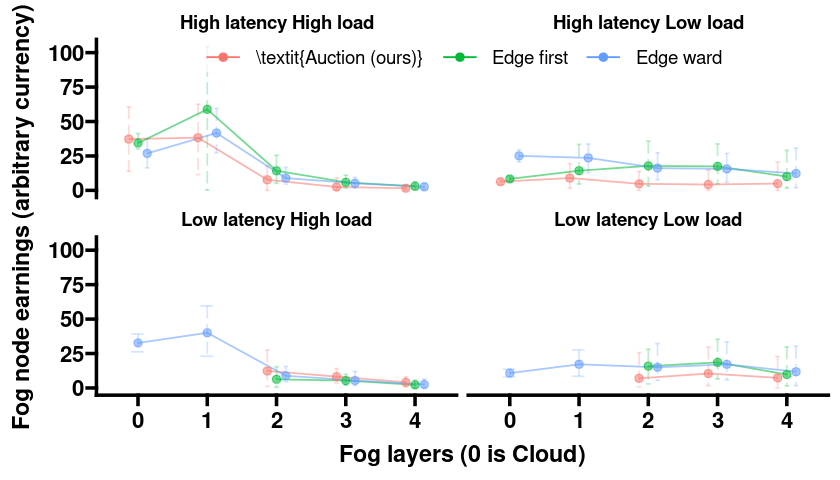

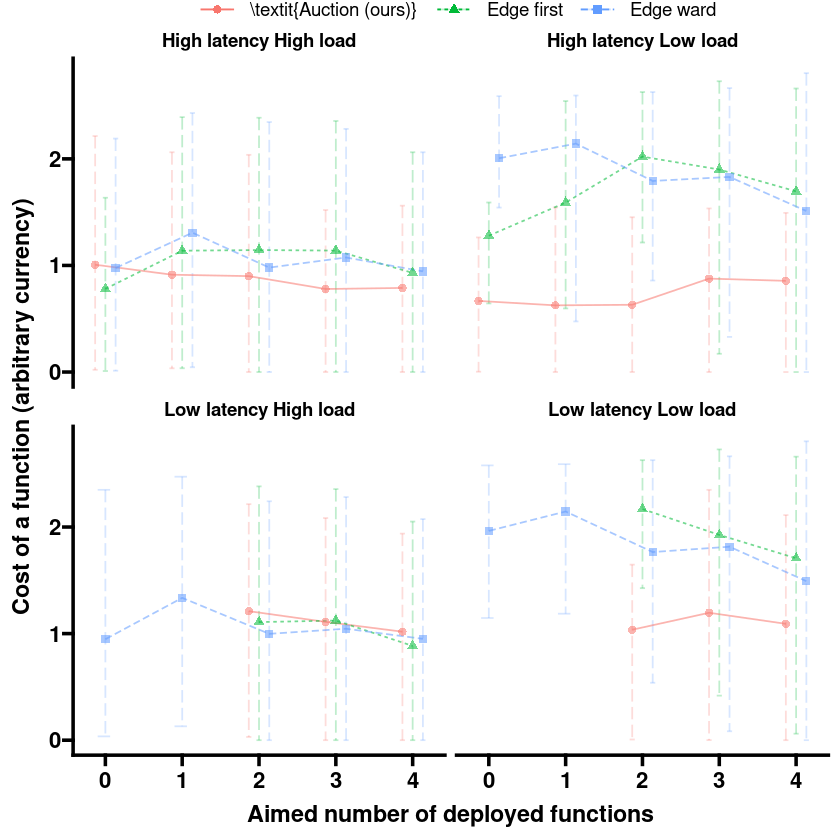

In [60]:
colnames(earnings.jain)

center_reduction <- function(data, colvar) {
    colvar <- rlang::sym(colvar)
    data %>%
        inner_join(data %>% summarise(mean = mean(!!colvar), sd = sd(!!colvar))) %>%
        mutate(!!colvar := (!!colvar - mean)/sd) %>%
        select(-c("sd", "mean"))
}

fig(20, 5)
earnings.jains.plot.data <- bids_won_function %>% 
    extract_function_name_info() %>%
    left_join(raw.function_low_latency_load_category) %>%
    left_join(raw.function_low_latency_load_category) %>%
    left_join(node_levels %>% rename(winner = name)) %>%
    mutate(fn_category = sprintf("%s %s", latency_type, load_type)) 

earnings.jains.nodes.plot.data <- earnings.jains.plot.data %>% 
    group_by(folder, fn_category, winner, level_value, metric_group, category, requests) %>%
    summarise(earnings = sum(cost)) 

plots.earnings.w = 7
plots.earnings.h = 4
plots.earnings.caption = "Earning of nodes per fog layer"
fig(plots.earnings.w, plots.earnings.h)

plots.earnings <- earnings.jains.nodes.plot.data %>%
    # group_by(level_value) %>%$
    # group_by(metric_group) %>%
    # ungroup() %>%
    # center_reduction("earnings") %>%
    # summarySE("earnings", c("metric_group", "level_value", "fn_category")) %>%
    correct_names() %>%
    ggplot(aes(alpha=1, x = factor(level_value), y = earnings, group = `Placement method`, color = `Placement method`, fill = `Placement method`)) +
    # stat_pointinterval(position = "dodge") +
    # geom_point() +
    # geom_line() +
    # geom_errorbar(aes(ymax = earnings + ci, ymin = earnings -ci),
    #     size=0.5, width = .2, linetype ="longdash", alpha = .2) +
    stat_summary(geom = "errorbar", 
            fun.min = function(z) quantile(z, .025), 
            fun = mean,
            fun.max = function(z) quantile(z, 0.975),
            position=position_dodge(width=0.4),
            size=0.5, width = .2, linetype ="longdash", alpha = .25) +
    stat_summary(fun.y=mean,position=position_dodge(width=0.4),geom="line")+
    stat_summary(fun.y=mean,position=position_dodge(width=0.4),geom="point", size = 2)+
    # stat_gradientinterval(position = "dodge") +
    # facet_grid(cols = vars(fn_category)) +
    scale_alpha_continuous(guide = "none") +
    labs(
    y = "Fog node earnings (arbitrary currency)",
    x = "Fog layers (0 is Cloud)",
    ) +
       theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    theme(legend.position = c(.5, .95)) +
    guides(colour = guide_legend(nrow = 1)) +
    facet_wrap(~fn_category)
plots.earnings

# earnings.jains.plot.data %>%
#     summarySE("cost")
#     correct_names() %>%
#     ggplot(aes(alpha=0, x = factor(level_value), y = cost, group = `Placement method`, color = `Placement method`, fill = `Placement method`)) +
#     geom_line() %>%
#     # stat_ccdfinterval(position = "dodge") +
#     stat_gradientinterval(position = "dodge") +
#     facet_grid(cols = vars(fn_category)) +
#     scale_alpha_continuous(guide = "none") +
#     labs(title = "Cost of a function per fog layer and accross targeted enumber of deployed functions",
#     # subtitle = "Secondary graph is the complementary CDF",
#     subtitle = "Secondary graph represents the distribution",
#     y = "Cost of a function (arbitrary currency)",
#     x = "Fog layers (0 is Cloud)",
#     ) +
#        theme( legend.background = element_rect(fill=alpha("white", .7),
#                                   size=0.2, color = alpha("white", .7))) +
#         theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
#     theme(legend.position = c(.5, .95)) +
#     guides(colour = guide_legend(nrow = 1))

plots.costs.w = 7
plots.costs.h = 7
plots.costs.caption = "Cost of a function per category and accross targeted enumber of deployed functions"
fig(plots.costs.w, plots.costs.h)

plots.costs <- earnings.jains.plot.data %>%
    # summarySE("cost", c("metric_group", "requests", "fn_category", "level_value"), conf.interval = .95) %>%
    correct_names() %>%
    ggplot(aes(alpha=0, x = level_value, y = cost,  linetype = `Placement method`, shape = `Placement method`, color = `Placement method`, fill = `Placement method`)) +
    # geom_point(aes(size = factor(requests))) +
    # geom_line(data = earnings.jains.plot.data %>%
    # stat_dotsinterval() +
    # geom_errorbar(aes(ymax = cost + ci, ymin = cost -ci),
    #     size=0.5, width = .2, linetype ="longdash", alpha = .2) +
      stat_summary(geom = "errorbar", 
               fun.min = function(z) quantile(z, .025), 
               fun = mean,
               fun.max = function(z) quantile(z, 0.975),
               position=position_dodge(width=0.4),
               size=0.5, width = .2, linetype ="longdash", alpha = .25) +
    stat_summary(fun.y=mean,position=position_dodge(width=0.4),geom="line")+
    stat_summary(fun.y=mean,position=position_dodge(width=0.4),geom="point", size = 2)+
    facet_wrap(~fn_category) +
    scale_alpha_continuous(guide = "none") +
    labs(
    y = "Cost of a function (arbitrary currency)",
    x = "Aimed number of deployed functions",
    ) +
    theme( legend.background = element_rect(fill=alpha("white", .7),
                                size=0.2, color = alpha("white", .7))) +
    theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    # theme(legend.position = c(.5, .93)) +
    theme(legend.position = "top") +
    guides(colour = guide_legend(nrow = 1))
    

plots.costs

In [61]:
plots.nb_functions.data <- load_csv("provisioned_functions.csv") %>%
    prepare() %>%
    extract_function_name_info() %>%
    group_by(folder, latency_type, load_type) %>%
    summarise(provisioned = sum(value)) %>%
    inner_join(raw.nb_functions.total %>% rename(target = total)) %>%
    inner_join(raw.function_low_latency_load_category) %>%
    mutate(ratio_deployed = provisioned / target) %>%
    mutate(fn_category = sprintf("%s %s", latency_type, load_type)) 

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
`summarise()` has grouped output by 'folder', 'latency_type'. You can override using the `.groups` argument.
Joining with `by = join_by(folder, latency_type, load_type)`
Joining with `by = join_by(folder, metric_group)`


In [62]:
slice_sample(plots.nb_functions.data %>% ungroup(), n= 5)

folder,latency_type,load_type,provisioned,metric_group_group,metric_group,target,category,requests,ratio_deployed,fn_category
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
metrics_equal_linear_pricing_big2.env.scenario_2-edge_first_valuation_rates_no-telemetry_2023-08-01-01-53,Low latency,Low load,787,small,edge_first,880,0.25,3520,0.8943182,Low latency Low load
metrics_equal_linear_pricing_big2.env.scenario_3-auction_valuation_rates_no-telemetry_2023-07-31-19-57,High latency,Low load,352,small,auction,880,0.25,3520,0.4000000,High latency Low load
metrics_equal_linear_pricing_big2.env.scenario_3-auction_valuation_rates_no-telemetry_2023-07-31-19-57,High latency,High load,338,small,auction,880,0.25,3520,0.3840909,High latency High load
metrics_equal_linear_pricing_big2.env.scenario_1-edge_ward_valuation_rates_no-telemetry_2023-07-31-17-57,High latency,High load,500,small,edge_ward,880,0.25,3520,0.5681818,High latency High load
metrics_equal_linear_pricing_big2.env.scenario_3-edge_first_valuation_rates_no-telemetry_2023-07-31-17-46,Low latency,High load,389,small,edge_first,880,0.25,3520,0.4420455,Low latency High load


In [63]:
fig(7, 7)
colnames(node_levels)
plots.nb_functions.line.data <- load_csv("provisioned_functions.csv") %>%
    prepare() %>%
    extract_function_name_info() %>%
    inner_join(bids_won_function) %>%
    group_by(folder, latency_type, load_type, winner) %>%
    summarise(provisioned = sum(value)) %>%
    inner_join(raw.nb_functions.total %>% rename(target = total))  %>%
    inner_join(raw.function_low_latency_load_category) %>%
    left_join(node_levels %>% rename(winner = name)) %>%
    mutate(ratio_deployed = provisioned / target) %>%
    mutate(fn_category = sprintf("%s %s", latency_type, load_type)) %>%
    summarySE("ratio_deployed", c("metric_group", "fn_category", "level_value"))

[1] "name"               "level_value"        "folder"            
[4] "metric_group"       "metric_group_group" "level"

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Joining with `by = join_by(function_name, sla_id, folder, metric_group, metric_group_group)`
`summarise()` has grouped output by 'folder', 'latency_type', 'load_type'. You can override using the `.groups` argument.
Joining with `by = join_by(folder, latency_type, load_type)`
Joining with `by = join_by(folder, metric_group)`
Joining with `by = join_by(folder, winner, metric_group_group, metric_group)`
`summarise()` has grouped output by 'metric_group', 'fn_category'. You can override using the `.groups` argument.


In [64]:
plots.nb_functions.data = load_csv("provisioned_functions.csv") %>%
    prepare() %>%
    extract_function_name_info() %>%
    inner_join(bids_won_function) %>%
    group_by(folder, latency_type, load_type, winner) %>%
    summarise(provisioned = sum(value)) %>%
    inner_join(raw.nb_functions.total %>% rename(target = total))  %>%
    inner_join(raw.function_low_latency_load_category) %>%
    left_join(node_levels %>% rename(winner = name)) %>%
    mutate(ratio_deployed = provisioned / target) %>%
    mutate(fn_category = sprintf("%s\n%s", latency_type, load_type))

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Joining with `by = join_by(function_name, sla_id, folder, metric_group, metric_group_group)`
`summarise()` has grouped output by 'folder', 'latency_type', 'load_type'. You can override using the `.groups` argument.
Joining with `by = join_by(folder, latency_type, load_type)`
Joining with `by = join_by(folder, metric_group)`
Joining with `by = join_by(folder, winner, metric_group_group, metric_group)`


In [ ]:
plots.nb_functions.line.w <- 7
plots.nb_functions.line.h <- 5
plots.nb_functions.line.caption = "TODO"
fig(plots.nb_functions.line.w, plots.nb_functions.line.h)

plots.nb_functions.line = plots.nb_functions.data %>%
    group_by(folder, metric_group, level_value, target, fn_category) %>%
    summarise(provisioned = sum(provisioned)) %>%
    mutate(ratio_deployed = provisioned / target) %>% 
    correct_names() %>%
    ggplot(aes(alpha=1, x = level_value, y = provisioned, linetype = `Placement method`, color = `Placement method`, fill = `Placement method`, shape =  `Placement method`)) +
    # stat_cdfinterval(position = "dodge") +
    # geom_beeswarm(dodge.width = 1) +
       stat_summary(geom = "errorbar", 
               fun.min = function(z) quantile(z, .025), 
               fun = mean,
               fun.max = function(z) quantile(z, 0.975),
               position=position_dodge(width=0.4),
               size=0.5, width = .2, linetype ="longdash", alpha = .25) +
    stat_summary(fun.y=mean,position=position_dodge(width=0.4),geom="line")+
    stat_summary(fun.y=mean,position=position_dodge(width=0.4),geom="point", size = 2)+
    scale_alpha_continuous(guide = "none") +
    labs(
    y = "Mean of provisioned functions",
    x = "Fog layer (0 = Cloud)",
    ) +
    #  scale_fill_brewer(palette = "Set2") +
    scale_color_brewer(palette = "Dark2", guide = "none") +
    theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
        theme(legend.spacing.y = unit(0, 'cm'), 
    legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,-10,-10,-10),) +
    theme(legend.position = c(.5, .95)) +
    guides(color = guide_legend(nrow = 1), fill = guide_legend(nrow = 1)) +
    facet_wrap(~fn_category)
plots.nb_functions.line


: 

In [66]:
colnames(plots.nb_functions.data)

plots.nb_functions.data.processed = plots.nb_functions.data %>%
    group_by(folder, metric_group, level_value, target) %>%
    summarise(provisioned = sum(provisioned)) %>%
    mutate(ratio_deployed = provisioned / target)

slice_sample(plots.nb_functions.data.processed %>% ungroup(), n = 5)

[1] "folder"             "latency_type"       "load_type"         
 [4] "winner"             "provisioned"        "metric_group_group"
 [7] "metric_group"       "target"             "category"          
[10] "requests"           "level_value"        "level"             
[13] "ratio_deployed"     "fn_category"

`summarise()` has grouped output by 'folder', 'metric_group', 'level_value'. You can override using the `.groups` argument.


folder,metric_group,level_value,target,provisioned,ratio_deployed
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
metrics_equal_linear_pricing_big2.env.scenario_1-edge_ward_valuation_rates_no-telemetry_2023-07-31-17-57,edge_ward,1,880,327,0.37159091
metrics_equal_linear_pricing_big2.env.scenario_2-auction_valuation_rates_no-telemetry_2023-08-01-00-00,auction,3,880,621,0.70568182
metrics_equal_linear_pricing_big2.env.scenario_2-edge_ward_valuation_rates_no-telemetry_2023-08-01-03-56,edge_ward,1,880,320,0.36363636
metrics_equal_linear_pricing_big2.env.scenario_2-auction_valuation_rates_no-telemetry_2023-08-01-00-00,auction,4,880,1657,1.88295455
metrics_equal_linear_pricing_big2.env.scenario_1-edge_ward_valuation_rates_no-telemetry_2023-07-31-17-57,edge_ward,0,880,80,0.09090909


`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.


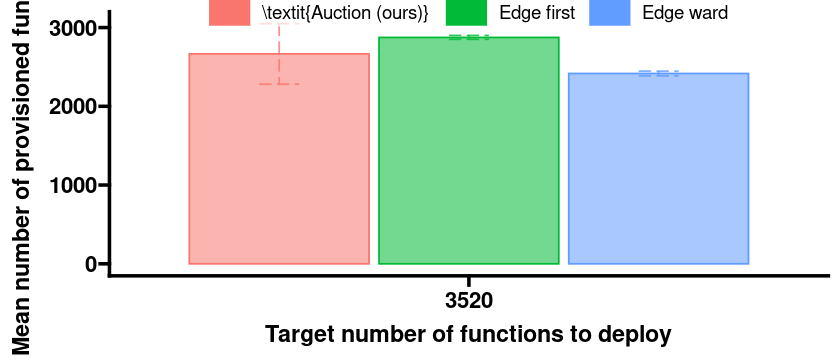

In [67]:
plots.nb_functions.w <- 7
plots.nb_functions.h <- 3
plots.nb_functions.caption <- "Number of deployed functions per method, for each deployment sizes"
fig(plots.nb_functions.w, plots.nb_functions.h)

plots.nb_functions.data.processed <- plots.nb_functions.data %>%
    group_by(folder, metric_group, requests) %>%
    summarise(provisioned = sum(provisioned)) %>%
    mutate(ratio_deployed = provisioned / requests)

plots.nb_functions <- plots.nb_functions.data.processed %>%
    correct_names() %>%
    ggplot(aes(alpha = 1, x = factor(requests), y = provisioned, color = `Placement method`, fill = `Placement method`, shape = `Placement method`)) +
    stat_summary(
        geom = "errorbar",
        fun.min = function(z) quantile(z, .025),
        fun = mean,
        fun.max = function(z) quantile(z, 0.975),
        position = position_dodge(width = 0.95),
        size = 0.5, width = .2, linetype = "longdash", alpha = .8
    ) +
    stat_summary(fun.y = mean, position = position_dodge(width = 0.95), geom = "bar") +
    scale_alpha_continuous(guide = "none") +
    labs(
        y = "Mean number of provisioned functions",
        x = "Target number of functions to deploy",
    ) +
    theme(legend.background = element_rect(
        fill = alpha("white", .7),
        size = 0.2, color = alpha("white", .7)
    )) +
    theme(
        legend.spacing.y = unit(0, "cm"),
        legend.margin = margin(0, 0, 0, 0),
        legend.box.margin = margin(-10, -10, -10, -10),
    ) +
    theme(legend.position = c(.5, 1)) +
    guides(color = guide_legend(nrow = 1), fill = guide_legend(nrow = 1))
plots.nb_functions


In [68]:
# plots.nb_functions.line.w <- 7
# plots.nb_functions.line.h <- 5
# plots.nb_functions.line.caption = "Provisioned functions compared to the Fog layers"
# fig(plots.nb_functions.line.w, plots.nb_functions.line.h)

# plots.nb_functions.line <- plots.nb_functions.line.data %>% 
#     correct_names() %>%
#     ggplot(aes(alpha=0, x = level_value, y = ratio_deployed, color = factor(`Placement method`), fill = factor(`Placement method`), shape =  factor(`Placement method`))) +
#     # stat_cdfinterval(position = "dodge") +
#     # geom_beeswarm(dodge.width = 1) +
#     geom_point() +
#     geom_line() +
#     # geom_errorbar(aes(ymax = ratio_deployed + ci, ymin = ratio_deployed -ci),
#     #     size=0.5, width = .2, linetype ="longdash", alpha = .2) +
#     # geom_errorbar(data = ecdf.jitter.mean, aes(x = fn_category, ymax = mean_jitter, ymin = mean_jitter),
#     #     size=0.5, linetype = "longdash", inherit.aes = F, width = 1, color = "red") +
#     # geom_text(data = ecdf.jitter.mean, aes(x = fn_category, y = mean_jitter, 
#     #     label = sprintf("$\\overline{x}=%s$", round(mean_jitter, 2))), vjust = -0.5, inherit.aes = F, color = "red") + 
#     # scale_y_continuous(trans = "log10") +
#     scale_alpha_continuous(guide = "none") +
#     labs(
#     y = "Mean ratio of provisioned functions",
#     x = "Fog layer (0 = Cloud)",
#     ) +
#     theme( legend.background = element_rect(fill=alpha("white", .7),
#                                   size=0.2, color = alpha("white", .7))) +
#         theme(legend.spacing.y = unit(0, 'cm'), 
#     legend.margin=margin(0,0,0,0),
#         legend.box.margin=margin(-10,-10,-10,-10),) +
#     theme(legend.position = c(.5, .95)) +
#     guides(colour = guide_legend(nrow = 1)) +
#     facet_wrap(vars(fn_category), scales = "free")
# plots.nb_functions.line


[1] "sla_id"             "function_name"      "folder"            
[4] "metric_group"       "metric_group_group" "winner"            
[7] "cost"

Joining with `by = join_by(sla_id, folder)`
Joining with `by = join_by(folder,
metric_group)`
Joining with `by = join_by(folder, metric_group,
metric_group_group, winner)`
`summarise()` has grouped output by
'fn_category'. You can override using the
`.groups` argument.


[1] "X"                               "sla_id"                         
 [3] "folder"                          "jitter"                         
 [5] "satisfied_count"                 "tolerating_count"               
 [7] "total"                           "apdex"                          
 [9] "jitter_above"                    "jitter_above_sla"               
[11] "mean_above_sla"                  "function_name"                  
[13] "metric_group"                    "metric_group_group"             
[15] "winner"                          "cost"                           
[17] "docker_fn_name"                  "function_index"                 
[19] "latency"                         "cpu"                            
[21] "mem"                             "load_type"                      
[23] "latency_type"                    "nb_fn_low_interval_low_latency" 
[25] "nb_fn_high_interval_low_latency" "category"                       
[27] "requests"                        "level_value"                    
[29] "level"                           "fn_category"

`geom_line()`: Each group consists of only one
observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one
observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one
observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one
observation.
ℹ Do you need to adjust the group aesthetic?
`summarise()` has grouped output by 'folder',
'metric_group', 'requests', 'level_value'. You
can override using the `.groups` argument.


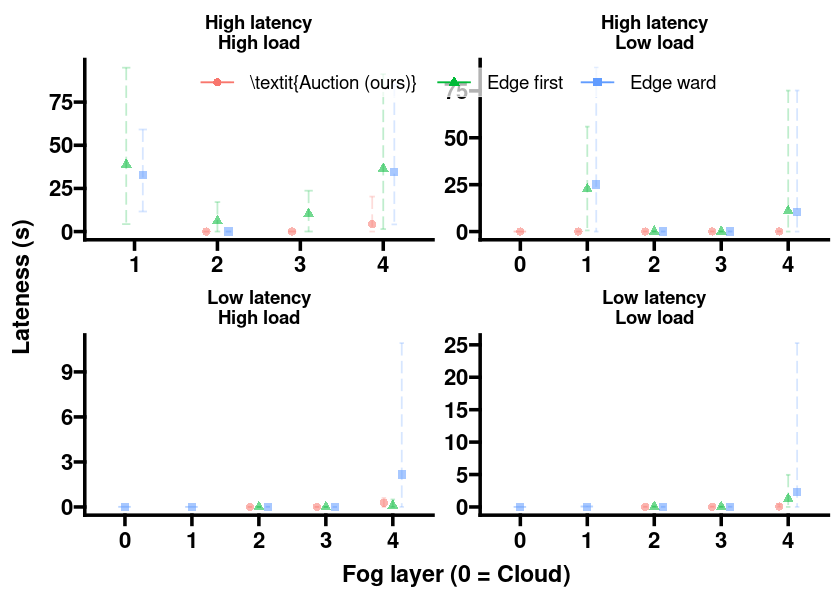

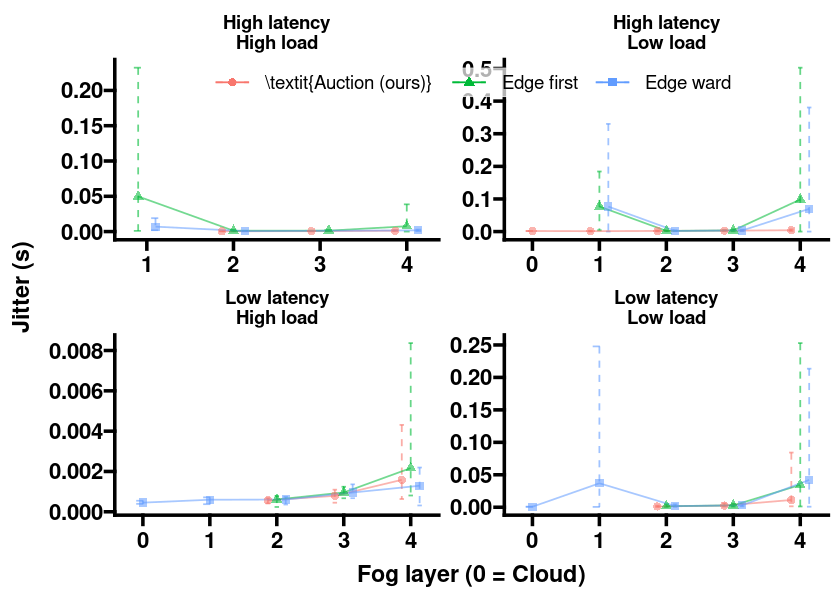

In [113]:
# slice_sample(apdex.jitter %>% ungroup(), n = 5)
colnames(bids_won_function)
ecdf.jitter <- apdex.jitter %>%
    left_join(bids_won_function %>% extract_function_name_info()) %>%
    left_join(raw.function_low_latency_load_category) %>%
    left_join(node_levels %>% rename(winner = name)) %>%
    mutate(fn_category = sprintf("%s\n%s", latency_type, load_type)) %>%
    mutate(mean_above_sla = ifelse(is.na(mean_above_sla), 0, mean_above_sla)) %>%
    mutate(jitter_above_sla = ifelse(is.na(jitter_above_sla), 0, jitter_above_sla)) %>%
    distinct()
# ungroup() %>%
# group_by(metric_group, fn_category, level_value) %>%
# mutate(quantile = base::cut(jitter_above_sla, breaks= c(-Inf, .1, 1, Inf), labels= c(0,1,2))) %>%
# group_by(metric_group, fn_category, level_value, quantile) %>%
# summarise(n_jitter_above_sla = n())

# ecdf.jitter <- ecdf.jitter %>%
#     inner_join(ecdf.jitter %>%
#         group_by(metric_group, fn_category, level_value) %>%
#         summarise(total_n = sum(n_jitter_above_sla))
#         ) %>%
#     mutate(ratio_jitter_above_sla = n_jitter_above_sla / total_n, median = total_n / 2)

# slice_sample(ecdf.jitter %>% ungroup(), n = 5)
plots.jitter.w <- 15
plots.jitter.h <- 15
fig(plots.jitter.w, plots.jitter.h)

ecdf.jitter.mean <- ecdf.jitter %>%
    group_by(fn_category, level_value) %>%
    summarise(mean_jitter = mean(jitter_above_sla))

# ecdf.jitter.mean

# plots.jitter <- ecdf.jitter %>%
#     correct_names() %>%
#     ggplot(aes(alpha=0, x = fn_category, y = jitter_above_sla, color = factor(`Placement method`), fill = factor(`Placement method`), shape =  factor(`Placement method`))) +
#     stat_cdfinterval(position = "dodge") +
#     geom_errorbar(data = ecdf.jitter.mean, aes(x = fn_category, ymax = mean_jitter, ymin = mean_jitter),
#         size=0.5, linetype = "longdash", inherit.aes = F, width = 1, color = "red") +
#     geom_text(data = ecdf.jitter.mean, aes(x = fn_category, y = mean_jitter,
#         label = sprintf("$\\overline{x}=%s$", round(mean_jitter, 2))), vjust = -0.5, inherit.aes = F, color = "red") +
#     scale_y_continuous(trans = "log10") +
#     scale_alpha_continuous(guide = "none") +
#     labs(title = "Jitter of latencies for requests above the SLA-defined threshold",
#     subtitle = "Secondary graph is the CDF",
#     y = "$log_{10}($Jitter$)$ (s)",
#     x = "Function category",
#     ) +
#     theme( legend.background = element_rect(fill=alpha("white", .7),
#                                 size=0.2, color = "white")) +
#     theme(legend.position = c(.5, .95)) +
#     guides(colour = guide_legend(nrow = 1)) +
#     facet_grid(rows = vars(level_value))

# plots.jitter

fig(7, 7)
plots.jitter.above_sla.line.w <- 7
plots.jitter.above_sla.line.h <- 5
plots.jitter.above_sla.line.caption <- "Lateness of requests above the SLA-defined threshold"
fig(plots.jitter.above_sla.line.w, plots.jitter.above_sla.line.h)

colnames(ecdf.jitter)

plots.jitter.above_sla.line <- ecdf.jitter %>%
    # summarySE("jitter_above_sla", c("metric_group", "level_value", "fn_category"), conf.interval = .99) %>%
    correct_names() %>%
    ggplot(aes(alpha = 0, x = factor(level_value), y = jitter_above_sla, color = factor(`Placement method`), fill = factor(`Placement method`), shape = factor(`Placement method`))) +
    # stat_cdfinterval(position = "dodge") +
    # geom_beeswarm(dodge.width = 1) +
    # geom_point() +
    # geom_line() +
    # geom_errorbar(aes(ymax = jitter_above_sla + ci, ymin = jitter_above_sla -ci),
    stat_summary(
        geom = "errorbar",
        fun.min = function(z) quantile(z, .025),
        fun = mean,
        fun.max = function(z) quantile(z, 0.975),
        position = position_dodge(width = 0.4),
        size = 0.5, width = .2, linetype = "longdash", alpha = .25
    ) +
    stat_summary(fun.y = mean, position = position_dodge(width = 0.4), geom = "line") +
    stat_summary(fun.y = mean, position = position_dodge(width = 0.4), geom = "point", size = 2) +
    scale_alpha_continuous(guide = "none") +
    labs(
        y = "Lateness (s)",
        x = "Fog layer (0 = Cloud)",
    ) +
    theme(legend.background = element_rect(
        fill = alpha("white", .7),
        size = 0.2, color = alpha("white", .7)
    )) +
    theme(legend.spacing.y = unit(0, "cm"), legend.margin = margin(0, 0, 0, 0), legend.box.margin = margin(-10, -10, -10, -10), ) +
    theme(legend.position = c(.5, .95)) +
    guides(colour = guide_legend(nrow = 1)) +
    facet_wrap(vars(fn_category), scales = "free")

plots.jitter.above_sla.line

plots.jitter.line.w <- 7
plots.jitter.line.h <- 5
plots.jitter.line.caption <- "Jitter of latencies for requests above the SLA-defined threshold"
fig(plots.jitter.line.w, plots.jitter.line.h)

plots.jitter.line.nb_functions.data = plots.nb_functions.data %>%
    group_by(folder, metric_group, requests, level_value, fn_category) %>%
    summarise(provisioned = sum(provisioned)) %>%
    mutate(ratio_deployed = provisioned / requests)

plots.jitter.line <- ecdf.jitter %>%
    # summarySE("jitter", c("metric_group", "level_value"), conf.interval = .99) %>%
    correct_names() %>%
    ggplot(aes(alpha = 0, x = level_value, y = jitter, color = factor(`Placement method`), fill = factor(`Placement method`), shape = factor(`Placement method`))) +
    # geom_point() +
    # geom_line() +
    # geom_errorbar(aes(ymax = jitter + ci, ymin = jitter -ci),
    #     size=0.5, width = .2, linetype ="longdash", alpha = .2) +
    # geom_beeswarm(dodge.width = .95) +
    # stat_summary(fun.data=mean_cl_normal,position=position_dodge(0.95),geom="errorbar") +
    # stat_summary(
    #     geom = "errorbar",
    #     fun.min = function(z) quantile(z, .005),
    #     fun = mean,
    #     fun.max = function(z) quantile(z, 0.995),
    #     position = position_dodge(width = 0.4),
    #     size = 0.5, width = .2, linetype = "longdash", alpha = .2, color = "red"
    # ) +
    stat_summary(
        geom = "errorbar",
        fun.min = function(z) quantile(z, .025),
        fun = mean,
        fun.max = function(z) quantile(z, 0.975),
        position = position_dodge(width = 0.4),
        size = 0.5, width = .2, linetype = "dashed", alpha = .6
    ) +
    stat_summary(fun.y = mean, position = position_dodge(width = 0.4), geom = "line") +
    stat_summary(fun.y = mean, position = position_dodge(width = 0.4), geom = "point", size = 2) +
    scale_alpha_continuous(guide = "none") +
    labs(
        y = "Jitter (s)",
        x = "Fog layer (0 = Cloud)",
    ) +
    theme(legend.background = element_rect(
        fill = alpha("white", .7),
        size = 0.2, color = alpha("white", .7)
    )) +
    theme(legend.spacing.y = unit(0, "cm"), legend.margin = margin(0, 0, 0, 0), legend.box.margin = margin(-10, -10, -10, -10), ) +
    theme(legend.position = c(.5, .95)) +
    guides(colour = guide_legend(nrow = 1)) +
    facet_wrap(~fn_category, scales = "free")
# facet_wrap(~fn_category)

plots.jitter.line


[1] "X"                               "sla_id"                         
 [3] "folder"                          "jitter"                         
 [5] "satisfied_count"                 "tolerating_count"               
 [7] "total"                           "apdex"                          
 [9] "jitter_above"                    "jitter_above_sla"               
[11] "mean_above_sla"                  "function_name"                  
[13] "metric_group"                    "metric_group_group"             
[15] "winner"                          "cost"                           
[17] "docker_fn_name"                  "function_index"                 
[19] "latency"                         "cpu"                            
[21] "mem"                             "load_type"                      
[23] "latency_type"                    "nb_fn_low_interval_low_latency" 
[25] "nb_fn_high_interval_low_latency" "category"                       
[27] "requests"                        "level_value"                    
[29] "level"                           "fn_category"

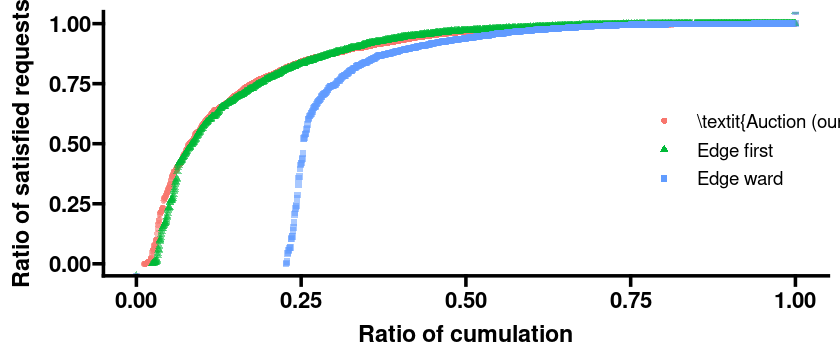

In [70]:
plots.ecdf.apdex.w = 7
plots.ecdf.apdex.h = 3
plots.ecdf.apdex.caption = "eCDF of ratio of satisfied requests over the total, per functions"
fig(plots.ecdf.apdex.w, plots.ecdf.apdex.h)
colnames(ecdf.jitter)

plots.ecdf.apdex <- ecdf.jitter  %>%
    # summarySE("apdex", c("metric_group", "folder", "winner")) %>%
    correct_names() %>%
    ggplot(aes(alpha = 1,y = satisfied_count / total, color = `Placement method`,  fill= `Placement method`, shape = `Placement method`)) +
    stat_ecdf(geom = "point") +
    labs(
    y = "Ratio of satisfied requests",
    x = "Ratio of cumulation",
    ) +
    scale_alpha_continuous(guide = "none") +
    theme(legend.position = c(.9, .5)) +
    guides(colour = guide_legend(ncol = 1)) 
    # facet_grid(cols = vars(requests))
plots.ecdf.apdex

# ggMarginal(ecdf.apdex.plot, type = "density", groupColour = TRUE, groupFill = TRUE)


In [71]:
# treemap.igraph <- graph_from_data_frame(node_connections %>% select(source, destination, latency) %>% distinct() %>% rename(from = source, to = destination, weight = latency), directed = TRUE)

# colors <- c("#FF0000", "#FF0000", "#FFAA00", "#FFFF00", "#FFFF00")
# node_level_map <- setNames(node_levels$level, node_levels$name)
# color_map <- setNames(colors, unique(node_levels$level))
# node_names <- merge(data.frame(name = V(treemap.igraph)$name, stringsAsFactors = FALSE), node_levels, by.x = "name", by.y = "name")
# node_names$name <- paste(node_names$name, paste("(", node_names$level, ")", sep = ""), sep = "\n")

# V(treemap.igraph)$color <- color_map[node_level_map[V(treemap.igraph)$name]]
# # V(net_connected)$name <- node_names$name
# # V(net_connected)$name <- ""
# # fig(15, 5)
# # coords <- layout_as_tree(net_connected)
# # # spacingfactor <- 40
# # # coords[, 1] <- coords[, 1] * spacingfactor
# # # coords[, 2] <- coords[, 2] * spacingfactor
# # node_graph <- plot(net_connected, layout = coords, asp = 0.22, margin = -0, vertex.label = E(net_connected)$name, edge.label = E(net_connected)$weight, edge.width = 1, vertex.size = 5, vertex.size2 = 3, vertex.label.cex = 1, vertex.dist = 20, edge.arrow.size = 0.5, edge.label.cex = 0.8, edge.label.dist = 1.5)
# # node_graph
# # treemap.df <- as_long_data_frame(treemap.igraph) 

# # slice_sample(treemap.df %>% ungroup(), n = 5)
# # treemap.df <- treemap.df %>%
# #     # rename(from = from_name, to = to_name) %>%
# #     full_join(ecdf.jitter %>% rename(from_name = winner)) %>%
# #     inner_join(node_levels %>% rename(from_name = name))


# treemap.igraph.vertices <- get.data.frame(graph, what = "vertices")
# treemap.igraph.edges <- get.data.frame(graph, what = "edges")


# # treemap.df$level1 <- sapply(strsplit(treemap.df$from, "\\."), "[", 1)
# # treemap.df$level2 <- sapply(strsplit(treemap.df$from, "\\."), "[", 2)
# # treemap.df$level3 <- sapply(strsplit(treemap.df$from, "\\."), "[", 3)

# # # Remove unnecessary columns
# # df$from <- NULL
# # df$to <- NULL

# treemap(treemap.df,
#         index = c("level_value", "from_name", "to_name"), 
#         vSize = "weight", 
#         vColor = "color", 
#         title = "Treemap")


`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.


folder,period,failed
<chr>,<dbl>,<dbl>


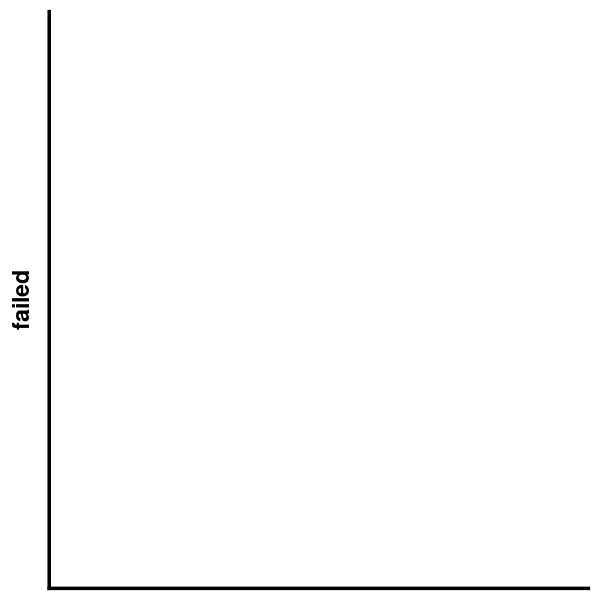

In [72]:
fails <- errors %>%
  group_by(folder, period) %>%
  summarise(failed = sum(value))

fails <- fails %>%
  # mutate(load = 1000 / period) %>%
  # inner_join(evol_sla_data, c("folder", "load")) %>%
  # mutate(dropped = failed / (above + respected + failed)) %>%
  {
    .
  }

fails

# fails <- evol_sla_data %>%
#     group_by(folder, target_offset) %>%
#     select(folder, target_offset) %>%
#     left_join(fails, by = c("folder")) %>%
#     {.}
# fails$dropped <- coalesce(fails$dropped, 0)


fails <- fails %>%
  ggplot(
    aes(
      x = folder,
      y = failed,
      # color = latency_type,
    )
  ) +
  # geom_line() +
  geom_point() +
  # geom_rug(sides="l") +
  # scale_y_reverse(label=scales::percent) +
  # scale_y_reverse()+
  # scale_x_discrete(position = "top") +
  # labs(
  #   x = "Load (req/s)",
  #   y = "Errors",
  #   # title = "Ratio of errors for send window vs load.",
  #   color = "Placment model"
  # ) +
  theme(
    axis.title.x = element_blank()
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE)

fig(5, 5)
fails
# cowplot::plot_grid(evol_sla, fails, ncol = 1, rel_heights = c(1, 0.75))


In [73]:
# deployment_times <- deployment_times_raw %>%
#   select(load_type, bid_id, latency_type, function_name, metric_group, value, metric_group_group) %>%
#   distinct() %>%
#   drop_na() %>%
#   group_by(load_type, latency_type, bid_id, function_name, metric_group, metric_group_group) %>%
#   summarize(min_time = min(value), avg_time = mean(value), max_time = max(value)) %>%
#   {
#     .
#   }

# # head(deployment_times)
# fig(10, 10)
# toto <- deployment_times %>%
#   ggplot(
#     aes(
#       x = avg_time * 1000,
#       # y = value,
#       color = metric_group,
#     )
#   ) +
#   stat_ecdf() +
#   gghighlight(metric_group == "auction", unhighlighted_params = list(colour = NULL, alpha = 0.3), label_params = list(linewidth = 10)) +
#   scale_x_continuous(trans = "log10") +
#   # facet_grid(rows = varslatency_type) +
#   # facet_grid(rows = vars(latency_type), cols = vars(load_type), scales = "free") +
#   labs(
#     x = "Deployment time (ms)",
#     y = "Cumulation",
#     title = "ECDF of time to deploy functions",
#     color = "Placement model"
#   )
# # scale_color_viridis(discrete = TRUE, option = "D") +
# # scale_fill_viridis(discrete = TRUE)


In [74]:
# deployment_times <- deployment_times_raw %>%
#   ungroup() %>%
#   select(latency_type, sla_id, folder, metric_group, value, metric_group_group) %>%
#   distinct() %>%
#   drop_na()

# top_1_percent <- deployment_times %>%
#   group_by(folder, metric_group, metric_group_group, latency_type) %>%
#   arrange(desc(value), .by_group = T) %>%
#   mutate(rank = row_number()) %>%
#   filter(rank <= ceiling(n() * 0.05)) %>%
#   group_by(folder, metric_group, metric_group_group, latency_type) %>%
#   summarize(avg_time_1_percent = mean(value))


# deployment_times <- deployment_times %>%
#   group_by(folder, metric_group, metric_group_group, latency_type) %>%
#   summarize(avg_time = mean(value)) %>%
#   inner_join(top_1_percent, by = c("folder", "metric_group", "metric_group_group", "latency_type")) %>%
#   gather(key = "average_type", value = "average", avg_time, avg_time_1_percent) %>%
#   mutate(average_type = case_when(
#     average_type == "avg_time" ~ "all",
#     average_type == "avg_time_1_percent" ~ "worst 5% (highest)",
#   )) %>%
#   {
#     .
#   }

# deployment_times <- deployment_times %>%
#   inner_join(total_low_latency, by = c("metric_group", "metric_group_group", "folder")) %>%
#   mutate(ratio_low_latency_functions = paste0(round(ratio_low_latency_functions * 100, 0), "%"))


# fig(12, 7)
# deployment_times_all <- deployment_times %>%
#   # filter(average_type == "all") %>%
#   correct_names() %>%
#   ggplot(
#     aes(
#       y = `Placement method`,
#       x = average,
#       color = latency_type,
#       shape = latency_type,
#       fill = latency_type,
#       # group = `Placement method`
#       # dotsize = 0.6,
#       # bindwidth=0.5,
#       # # group = average_type,
#       # linewidth=0,
#     )
#   ) +
#   stat_dotsinterval(slab_alpha = 0.6, position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 10, slab_linewidth = 0) +
#   gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
#   facet_grid2(cols = vars(average_type), scales = "free", axes = "all", remove_labels = "y") +
#   labs(
#     x = "Deployment time ($ms$)",
#     y = "Placement algorithm",
#     title = "Deployment time of placement models",
#     subtitle = "\\textit{Each point is an experiment run}",
#     color = "Function type",
#     shape = "Function type",
#     fill = "Function type",
#   ) +
#   theme(
#     legend.position = "bottom",
#     # legend.direction = "vertical",
#   ) +
#   coord_capped_cart(bottom = "both") +
#   scale_y_discrete(guide = guide_prism_bracket(width = 0.15))
# fig(12, 6)
# deployment_times_all


In [75]:
nb_experiences_per_categories <- raw.function_low_latency_load_category %>%
    ungroup()  %>%
    select(folder, metric_group, category, requests) %>%
    distinct() %>%
    group_by(metric_group, category, requests) %>%
    # summarize(n = n()) %>%
    filter(category < .25 | category > .75) %>%
    # pivot_wider(names_from = metric_group, values_from = n) %>%
    # correct_names() %>%
    # ungroup() %>%
    # select(-metric_group) %>%
    # select(`Placement method`, everything()) %>%
    {.}

nb_experiences_per_categories


folder,metric_group,category,requests
<chr>,<chr>,<dbl>,<dbl>


In [76]:
escape_latex_special_chars <- function(text) {
  # Define special characters to escape
  special_chars <- c("%", "&", "#", "_", "\\$", "\\{", "\\}", "\\^", "\\~")

  # Escape each special character with a backslash
  for (char in special_chars) {
    text <- gsub(char, paste0("\\", substring(char, nchar(char), nchar(char))), text, fixed = TRUE)
  }

  return(text)
}


tibble_to_latex_tabular <- function(data, file) {
  cat("\\begin{tabular}{", paste0(rep("c", ncol(data)), collapse = " "), "}\n", file = file)
  cat("\\hline\n", file = file, append = TRUE)

  # Print column names with escaped special characters
  cat(paste0(escape_latex_special_chars(colnames(data)), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  cat("\\hline\n", file = file, append = TRUE)

  # Print rows with escaped special characters
  for (i in 1:nrow(data)) {
    cat(paste0(escape_latex_special_chars(as.character(data[i, ])), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  }

  cat("\\hline\n", file = file, append = TRUE)
  cat("\\end{tabular}", file = file, append = TRUE)
}


In [77]:
if (length(find.package("tikzDevice", quiet = TRUE))) {
    library(tikzDevice)
    options(tikzDefaultEngine = "xetex")
    options(
        tikzSanitizeCharacters = c("%", "&", "#", "_", "\\$", "\\{", "\\}", "\\^", "\\~"),
        tikzReplacementCharacters = c("\\%", "\\&", "\\#", "\\_", "\\\\$", "\\\\{", "\\\\}", "\\\\^", "\\\\~")
    )
    options(tikzXelatexPackages = c(
        "\\usepackage{tikz}\n",
        "\\usepackage[active,tightpage,xetex]{preview}\n",
        "\\usepackage{fontspec,xunicode}\n",
        "\\PreviewEnvironment{pgfpicture}\n",
        "\\setlength\\PreviewBorder{0pt}\n"
    ))
    options(
        tikzMetricPackages = c(
        "\\usepackage[T1]{fontenc}\n",
        "\\usetikzlibrary{calc}\n"
        ),
        tikzUnicodeMetricPackages = c(
        "\\usepackage[T1]{fontenc}\n",
        "\\usetikzlibrary{calc}\n",
        "\\usepackage{fontspec,xunicode}\n"
        )
        )
    # options(tikzMetricPackages = c("\\usepackage{preview}", "\\usepackage{pgf}", "\\usepackage{xcolor}"))

    tikzDevice::tikzTest()

    column_width = 7

    export_graph <- function(name, plot, width, height, caption) {
        tikzDevice::tikz(name, width = width, height = height, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
        print(plot)
        dev.off()

        # read the existing content of the file
        existing_content <- readLines(name)

        tex_width = 1
        if (width > column_width) {
           tex_width = 2
        }

        new_content <- c( 
            sprintf("\\resizebox{%s\\columnwidth}{!}{", tex_width),
            existing_content,
            "}",
            sprintf("\\caption{%s}", caption)
            )

        # write the new content to the file
        writeLines(new_content, name)

    }


    # tikzDevice::tikz("./nodes.tex", width = 15, height = 5, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    # plot(net_connected, layout = coords, asp = 0.22, margin = -0, edge.label = E(net_connected)$weight, edge.width = 1, vertex.size = 5, vertex.label.cex = 1, vertex.dist = 20, edge.arrow.size = 0.5, edge.label.cex = 0.8, edge.label.dist = 1.5)
    # dev.off()

    export_graph("./deploymenttimes.tex", plots.deployment_times, plots.deployment_times.w, plots.deployment_times.h, plots.deployment_times.caption)
    export_graph("./apdex.tex", plots.ecdf.apdex, plots.ecdf.apdex.w, plots.ecdf.apdex.h, plots.ecdf.apdex.caption)
    # export_graph("./jitter.tex", plots.jitter, plots.jitter.w, plots.jitter.h, plots.jitter.caption)
    export_graph("./jitter.line.tex", plots.jitter.line, plots.jitter.line.w, plots.jitter.line.h, plots.jitter.line.caption)
    export_graph("./jitter.above_sla.line.tex", plots.jitter.above_sla.line, plots.jitter.above_sla.line.w, plots.jitter.above_sla.line.h, plots.jitter.above_sla.line.caption)
    export_graph("./earnings.tex", plots.earnings, plots.earnings.w, plots.earnings.h, plots.earnings.caption)
    export_graph("./costs.tex", plots.costs, plots.costs.w, plots.costs.h, plots.costs.caption)
    export_graph("./jain.tex", plots.jains, plots.jains.w, plots.jains.h, plots.jains.caption)
    export_graph("./nb_functions.tex", plots.nb_functions, plots.nb_functions.w, plots.nb_functions.h, plots.nb_functions.caption)
    export_graph("./nb_functions.line.tex", plots.nb_functions.line, plots.nb_functions.line.w, plots.nb_functions.line.h, plots.nb_functions.line.caption)
    export_graph("./deploymenttimes.line.tex", plots.deploymenttimes.line, plots.deploymenttimes.line.w, plots.deploymenttimes.line.h, plots.deploymenttimes.line.caption)

    # output_file <- "nb_experiences_per_categories.tex"
    # tibble_to_latex_tabular(nb_experiences_per_categories, output_file)
}




Active compiler:
	/nix/store/psjyf8770ygwyhw8pa7j4sddkhmaj60q-texlive-combined-full-2022-final/bin/xelatex
	XeTeX 3.141592653-2.6-0.999994 (Web2C 2022/nixos.org)
	kpathsea version 6.3.4



Measuring dimensions of: A

Running command: '/nix/store/psjyf8770ygwyhw8pa7j4sddkhmaj60q-texlive-combined-full-2022-final/bin/xelatex' -interaction=batchmode -halt-on-error -output-directory '/tmp/nix-shell.KVkd8p/RtmpR9ZOs2/tikzDevice1d046d375a2033' 'tikzStringWidthCalc.tex'



`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
